#  PRUEBAS
Responble: Oscar Fernandez

Usuario: OFERNA4
Repositorio: https://github.com/adldigitallabs/data-bbog-integration-bau-adquisicion/

In [1]:
import os
os.chdir("/home/sagemaker-user/data-bbog-integration-fabrica-personas/src")
import data_bbog_integration_fabrica_personas.pipelines.raw.nodes as raw
import data_bbog_integration_fabrica_personas.pipelines.primary.nodes as primary
import data_bbog_integration_fabrica_personas.pipelines.feature.nodes as feature
import data_bbog_integration_fabrica_personas.pipelines.model_input.nodes as mi
import data_bbog_integration_fabrica_personas.pipelines.models.nodes as models
import data_bbog_integration_fabrica_personas.pipelines.backtesting.nodes as backtesting
import data_bbog_integration_fabrica_personas.pipelines.model_output.nodes as mo

In [2]:
import logging
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pandas as pd
import time

from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
%load_ext kedro.ipython

[04/09/25 15:49:02] INFO     Resolved project path as:                                              ]8;id=971268;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=746243;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             /home/sagemaker-user/data-bbog-integration-fabrica-personas.                          
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/09/25 15:49:02] WARNING  /home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-p ]8;id=101620;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=877534;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             ackages/kedro/io/data_catalog.py:301: KedroDeprecationWarning:                        
                             Defining the 'layer' attribute at the top level is deprecated and will                
                             be removed in Kedro 0.19.0. Please move 'layer' inside the 'metadata'                 
                             -> 'kedro-viz' attributes. See                                                        
                             https://docs.kedro.org/en/latest/visualisation/kedro-viz_visualisation                
                             .html#visualise-layers for more information.                                          
                               warnings.warn(                                                                      
                                                                                                                   

[04/09/25 15:49:03] WARNING  /home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-p ]8;id=962428;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=692937;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                             ackages/kedro/io/data_catalog.py:301: KedroDeprecationWarning:                        
                             Defining the 'layer' attribute at the top level is deprecated and will                
                             be removed in Kedro 0.19.0. Please move 'layer' inside the 'metadata'                 
                             -> 'kedro-viz' attributes. See                                                        
                             https://docs.kedro.org/en/latest/visualisation/kedro-viz_visualisation                
                             .html#visualise-layers for more information.                                          
                               warnings.warn(                                                                      
                                                                                                                   

                    INFO     Kedro project data-bbog-integration-fabrica-personas                   ]8;id=260021;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=775555;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=630904;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=866342;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

In [4]:
params1= catalog.list
params = catalog.load("parameters")
#params

                    INFO     Loading data from 'parameters' (MemoryDataset)...                  ]8;id=266163;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=84118;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [5]:
import logging
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [ ]:
create_feature = catalog.load("master_primary_fp")
create_feature.head()

In [ ]:
def create_targets(
    df: pd.DataFrame, 
    variable_apertura: Any,
    target: Any,
    params: Dict[str, Any]
) -> pd.DataFrame:
    """
    Crea una variable target segun la variable_apertura marcando en x los resultados de x+1,x+2,..,x+shift_max  

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame que contiene los datos de entrada.

    variable_apertura: Any
        String de la variable existente en df sobre la cual se usara para crear la variable objetivo
        
    target: Any
        String para identificar la variable creada
    
    params: Dict[str, Any] 
        Diccionario de parámetros que contiene las variables necesarias.

    Returns
    -------
    pd.DataFrame: DataFrame del id, period_col, la variable_apertura y target.
    """
    #target = params['target']
    id_col = params['id']
    periodo_col = params['period_col']
    #variable_apertura = params['variable_apertura']
    shift_max = params['future_target_window'][variable_apertura]
    tenencia_target = params['modelar_tenencia']
    gc.collect()
    logger.info(f'Creando la variable {target} con la variable {variable_apertura}')
    logger.info(f'Usando {shift_max} periodos de rezago o los pronosticos cuentan con {shift_max} periodos de vida...')
    if variable_apertura in df.columns:
        temp_df = df[[id_col, periodo_col, variable_apertura]].copy()
    else:
        logger.info(f'No esta la variable {variable_apertura}')
        temp_df = pd.DataFrame(columns = [id_col,periodo_col])
    order_months = sorted(temp_df[periodo_col].unique())
    result_all = pd.DataFrame()
    period_all = []
    for t in range(len(order_months)-shift_max):
        gc.collect()

        period_window = []
        df_temps = pd.DataFrame()
        for i in range(0,shift_max+1,1):
            period_window.append(order_months[t+i])
            tempo = temp_df[temp_df[periodo_col]==order_months[t+i]].rename(columns = {variable_apertura:t+i})
            if i == 0:
                df_temps = tempo.copy()
            else:
                df_temps = pd.merge(df_temps,tempo[[id_col,t+i]], on = [id_col], how = 'left')
    #        df_temps.append(temp_df[temp_df[periodo_col]==order_months[t+i]].rename(columns = {variable_apertura:t+i}))
        df_temps = df_temps.sort_values(by = id_col)
        pto_partida = 0
        print(f'Para el periodo {period_window[pto_partida]}, se analiza el comportamiento de la variable objetivo en {period_window[pto_partida+1:]}')
        period_all = list(set(period_all + [period_window[0]]))
        #display(df_temps)
        # elimino las aperturas del momento 0 o las aperturas en el momento equivalente al periodo
        result = df_temps.set_index([id_col,periodo_col]).iloc[:,pto_partida+1:]
        # acumulo la cantidad de aerturas futuras
        result = result.sum(axis = 1).to_frame()
        # ajustamos el nombre de la variable objetivo
        result = result.rename(columns = {0:target}).reset_index()
        #display(result)
        # consolidamos los resultados
        result_all = pd.concat([result_all,result],axis = 0)
    # unificamos la data
    temp_df = pd.merge(temp_df,result_all, on = [id_col,periodo_col], how = 'left')
    # los los meses en donde el periodo+shift se conoce
    temp_df1 = temp_df[temp_df[periodo_col].isin(period_all)]
    
    # considerando la ventanda de tiempo periodo:periodo+shift_max se pierden los ultimos shift_max periodos
    temp_df2 = temp_df[~temp_df[periodo_col].isin(period_all)]
    rest_periods = sorted(list(temp_df2[periodo_col].unique()))
    # se contara la cantidad de aperturas realizadas conocidas en los ultimos shift_max periodos
    temp_df3 = pd.DataFrame() # aca guardaremos lo que sabemos que se aperturo en un futuro
    for t in range(shift_max):
        gc.collect()
        # filtramos del momento t hasta el fin de la data 
        temp_df2_temp = temp_df2[temp_df2['periodo'] >= rest_periods[t]].copy()
        # ordenamos de la data nueva a la mas vieja
        temp_df2_temp = temp_df2_temp.sort_values(by = periodo_col, ascending=False)
        # tomamos el momento t mas viejo como 0 porque en t=t no tenemos aperturas presentes
        temp_df2_temp.loc[temp_df2_temp[temp_df2_temp['periodo'] == rest_periods[t]].index,variable_apertura] = 0
        # agrupamos las aperturas futuras entre t hasta el fin de los tiempos y acumulamos las aperturas
        temp_df2_temp.loc[:,target] = temp_df2_temp.groupby([id_col]).cumsum()[variable_apertura].values.tolist()
        # en la variable target tenemos las aperturas acumuladas entre t+1 hasta el fin de los tiempo ubicado en el periodo t
        moment_target = rest_periods[t]
        fin_target = rest_periods[-1]
        print(f'Se incluyen los clientes que tuvieron tenencia despues de {moment_target} y hasta {fin_target}')
        temp_df2_temp = temp_df2_temp[temp_df2_temp[periodo_col]==moment_target].drop(variable_apertura,axis = 1)
        # consolidamos las acumulaciones de aperturas
        temp_df3 = pd.concat([temp_df3,temp_df2_temp], axis = 0)
    
    # ordenamos las aperturas del mas antiguo al reciente
    temp_df3 = temp_df3.sort_values(by = periodo_col, ascending=True)
    # En donde no tenemos aperturas acumuladas futuras no tenemos certeza si entre el fin de los tiempos o fin de la data
    # hasta el fin de la ventana shift max en realidad si se haga una apertura
    temp_df3 = temp_df3.replace(0, np.nan)
    # unificamos las aperturas de cada periodo con las aperutruas acumuladas futuras
    temp_df2 = pd.merge(temp_df2.drop(target,axis = 1),temp_df3, on = [id_col,periodo_col], how = 'left')
    # quitamos los clientes donde realmente no sabemos si van a aperturar porque no tenemos certeza desde el periodo en cuestion hasta periodo+shift_max
    temp_df2 = temp_df2[~temp_df2[target].isnull()]
    # se unifica la data completamente cierta contra la data recuperada:
    temp_df_final = pd.concat([temp_df1,temp_df2],axis = 0)
    if tenencia_target == True:
        logger.info(f'Ajustando la cantidad de aperturas por tenencia de apertura ....')
        temp_df_final[target] = (temp_df_final[target]>0).astype(int)
    logger.info(f'Finalizacion de creacion de variable {target}')
    gc.collect()
    return temp_df_final

In [9]:
dict_all_variables = params['todas_variables_apertura']
dict_all_variables


{
    'fid_cant_aper_mes': 'fid_cant_ap_group3',
    'leasing_cant_aper_mes': 'lea_target_ap_group3',
    'tc_cant_aper_mes': 'tc_target_ap_group3',
    'sus_cant_aper_mes': 'sus_target_ap_group3',
    'cs_cant_aper_mes': 'cs_target_ap_group3',
    'ld_cant_aper_mes': 'ld_target_ap_group3',
    'ah_cant_aper_mes': 'ah_target_ap_group3',
    'cc_cant_aper_mes': 'cc_target_ap_group3',
    'viv_cant_aper_mes': 'viv_cant_ap_group3',
    'cdt_cant_aper_mes': 'cdt_target_ap_group3',
    'lib_cant_aper_mes': 'lib_target_ap_group3',
    'veh_cant_aper_mes': 'veh_target_ap_group3',
    'micro_cant_aper_mes': 'micr_cant_ap_mes3',
    'fac_cant_aper_mes': 'fac_cant_ap_mes3'
}

In [13]:
id_col = params['id']
id_col

'hashvalue1'

In [34]:
periodo_col = params['period_col']
variable_apertura = params['variable_apertura']
variable_apertura = 'fid_cant_ap_group3'
variable_apertura

'fid_cant_ap_group3'

In [36]:
shift_max = 3 #params['future_target_window'][variable_apertura]
shift_max

3

In [37]:
tenencia_target = params['modelar_tenencia']
tenencia_target

True

In [38]:
create_feature = catalog.load("master_primary_fp")
create_feature.head()

[04/09/25 16:11:29] INFO     Loading data from 'master_primary_fp' (ParquetDataSet)...          ]8;id=230651;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=827940;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/site-packages/kedro/io/data_catalog.py#502\502]8;;\

hashvalue1  periodo   generacion  estrato departamento         ocupacion  \
0  CC1000000545   202308  _millennial        0  bogota_d_c_  empleado_privado   
1  CC1000000563   202308  _centennial        0  bogota_d_c_  empleado_privado   
2  CC1000003981   202308  _millennial        2  bogota_d_c_  empleado_privado   
3  CC1000018656   202308  _centennial        0  bogota_d_c_  empleado_privado   
4  CC1000020446   202308  _centennial        0  bogota_d_c_  empleado_privado   

   perfil_riesgo  mcro_sum_numero_cuotas_total aa_ciudad mar_status  ...  \
0            1.0                             0         _          s  ...   
1            1.0                             0         _          s  ...   
2            1.0                             0         _          s  ...   
3            1.0                             0         _          s  ...   
4            1.0                             0         _          s  ...   

   veh_cant_prev veh_sum_saldo_promedio veh_prom_plazo  \
0              0                    0.0            0.0   
1              0                    0.0            0.0   
2              0                    0.0            0.0   
3              0                    0.0            0.0   
4              0                    0.0            0.0   

   veh_sum_numero_cuotas_pagadas veh_sum_numero_cuotas_total  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           0   

   veh_sum_cuota_pactada fid_cant_prev  fid_cant  fid_sum_encargo  \
0                      0             0         0                0   
1                      0             0         0                0   
2                      0             0         0                0   
3                      0             0         0                0   
4                      0             0         0                0   

   fid_cant_ap_group3  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  

[5 rows x 255 columns]

In [99]:
params = {'period_col': 'periodo','id':'hashvalue1','variable_apertura':'fid_cant_ap_group3'}
params['future_target_window'] = {params['variable_apertura']:3}
variables_flujo = ['veh_cant_prev','fid_sum_encargo','edad_anios']
def variable_target_alertas(feature, variables_flujo, params):
    periodo_col = params['period_col']
    id_col = params['id']
    variable_apertura = params['variable_apertura']
    variable_apertura = 'fid_cant_ap_group3'
    shift_max = params['future_target_window'][variable_apertura]

    all_vars = [periodo_col,id_col,variable_apertura] + variables_flujo
    create_feature_filt = feature[all_vars]
    create_feature_filt

    periods_all = list(create_feature_filt[periodo_col].unique())
    periods_all = list(reversed(sorted(periods_all)))
    df_full = pd.DataFrame()
    for t in range(len(periods_all)-shift_max):
        temp = periods_all[t]
        logger.info(f'Corte actual {temp}')
        temp_shift = periods_all[t+shift_max]
        df_temp = create_feature_filt[create_feature_filt[periodo_col] == temp]
        df_temp_shift = create_feature_filt[create_feature_filt[periodo_col] == temp_shift]
        if t == 0:
            df_full = pd.merge(df_temp[[periodo_col,id_col,variable_apertura]],df_temp_shift[[id_col]+variables_flujo], on = id_col, how = 'left')
        else:
            df_temp_f = pd.merge(df_temp[[periodo_col,id_col,variable_apertura]],df_temp_shift[[id_col]+variables_flujo], on = id_col, how = 'left')
            df_full = pd.concat([df_full,df_temp_f], axis = 0)
    return df_full

In [109]:
df_full = variable_target_alertas(create_feature, variables_flujo, params)
df_full = df_full.dropna()

[04/09/25 17:06:18] INFO     Corte actual 202407                                                   ]8;id=26678;file:///tmp/ipykernel_352/2198655170.py\2198655170.py]8;;\:]8;id=982078;file:///tmp/ipykernel_352/2198655170.py#20\20]8;;\

[04/09/25 17:06:20] INFO     Corte actual 202406                                                   ]8;id=264491;file:///tmp/ipykernel_352/2198655170.py\2198655170.py]8;;\:]8;id=47724;file:///tmp/ipykernel_352/2198655170.py#20\20]8;;\

[04/09/25 17:06:22] INFO     Corte actual 202405                                                   ]8;id=904796;file:///tmp/ipykernel_352/2198655170.py\2198655170.py]8;;\:]8;id=279271;file:///tmp/ipykernel_352/2198655170.py#20\20]8;;\

[04/09/25 17:06:26] INFO     Corte actual 202404                                                   ]8;id=580060;file:///tmp/ipykernel_352/2198655170.py\2198655170.py]8;;\:]8;id=770154;file:///tmp/ipykernel_352/2198655170.py#20\20]8;;\

[04/09/25 17:06:30] INFO     Corte actual 202403                                                   ]8;id=975884;file:///tmp/ipykernel_352/2198655170.py\2198655170.py]8;;\:]8;id=252807;file:///tmp/ipykernel_352/2198655170.py#20\20]8;;\

[04/09/25 17:06:34] INFO     Corte actual 202402                                                   ]8;id=208248;file:///tmp/ipykernel_352/2198655170.py\2198655170.py]8;;\:]8;id=590732;file:///tmp/ipykernel_352/2198655170.py#20\20]8;;\

[04/09/25 17:06:38] INFO     Corte actual 202401                                                   ]8;id=690908;file:///tmp/ipykernel_352/2198655170.py\2198655170.py]8;;\:]8;id=156622;file:///tmp/ipykernel_352/2198655170.py#20\20]8;;\

[04/09/25 17:06:42] INFO     Corte actual 202312                                                   ]8;id=659995;file:///tmp/ipykernel_352/2198655170.py\2198655170.py]8;;\:]8;id=913347;file:///tmp/ipykernel_352/2198655170.py#20\20]8;;\

[04/09/25 17:06:46] INFO     Corte actual 202311                                                   ]8;id=395213;file:///tmp/ipykernel_352/2198655170.py\2198655170.py]8;;\:]8;id=945759;file:///tmp/ipykernel_352/2198655170.py#20\20]8;;\

In [111]:
create_feature.shape

(28242430, 255)

In [112]:
df_full.shape

(18422190, 6)

## Creacion de variables

In [7]:
print(create_feature.shape)
create_feature = feature.calculate_new_variables_pd(create_feature, params)
model_homolog = feature.modelo_homologacion_regiones(params)
create_feature = feature.homologate_region(create_feature, model_homolog)

(28090936, 255)


[03/21/25 15:28:04] INFO     Se construyo la variable "mes" con exito!                                  ]8;id=583816;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=626753;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

[03/21/25 15:28:18] INFO     Se construyo la variable "AAAA" con exito!                                 ]8;id=738320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=962885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

[03/21/25 15:28:19] INFO     Se construyo la variable "sum_saldo_activos" con exito!                    ]8;id=589766;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=384698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

                    INFO     Se construyo la variable "sum_saldo_pasivos" con exito!                    ]8;id=861569;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=532413;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

[03/21/25 15:28:20] INFO     Se construyo la variable "delta_ah_sum_monto_trx_credito" con exito!       ]8;id=590357;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=16684;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

[03/21/25 15:28:21] INFO     Se construyo la variable "delta_ah_sum_monto_trx_debito" con exito!        ]8;id=253879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=451707;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

                    INFO     Se construyo la variable "delta_tc_sum_facturacion_total" con exito!       ]8;id=928243;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=202941;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

                    INFO     Se construyo la variable "num_activos_prev" con exito!                     ]8;id=173147;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=137299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

[03/21/25 15:28:22] INFO     Se construyo la variable "num_pasivos_prev" con exito!                     ]8;id=617686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=753964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

                    INFO     Se construyo la variable "num_prod_activos" con exito!                     ]8;id=627534;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=724016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

[03/21/25 15:28:23] INFO     Se construyo la variable "num_prod_pasivos" con exito!                     ]8;id=117207;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=709656;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#84\84]8;;\

                    INFO     Nuevas variables calculadas completamente. Dimension de la data:           ]8;id=96064;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=77982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#90\90]8;;\
                             (28090936, 266)                                                                       

                    INFO     Guardando el pickle de como se homologan las regiones...                  ]8;id=930010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=693713;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#104\104]8;;\

[03/21/25 15:28:47] INFO     La nulidad se remplazara con Other_Region antes de la capa de model_input ]8;id=232882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=123592;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#141\141]8;;\

[03/21/25 15:28:50] INFO     Ok la homologacion de la variable region con departamento                 ]8;id=613236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=278353;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#144\144]8;;\

[03/21/25 15:29:18] INFO     La nulidad se manejara en la capa de model_input                          ]8;id=746576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=956957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#138\138]8;;\

[03/21/25 15:29:19] INFO     Ok la homologacion de la variable ocupacion2 con ocupacion                ]8;id=335723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=105595;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#144\144]8;;\

[03/21/25 15:29:38] INFO     La nulidad se manejara en la capa de model_input                          ]8;id=305191;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=857187;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#138\138]8;;\

[03/21/25 15:29:40] INFO     Ok la homologacion de la variable mar_status2 con mar_status              ]8;id=271927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=880785;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#144\144]8;;\

[03/21/25 15:30:03] INFO     La nulidad se manejara en la capa de model_input                          ]8;id=879795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=619805;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#138\138]8;;\

[03/21/25 15:30:05] INFO     Ok la homologacion de la variable grupo_etario2 con grupo_etario          ]8;id=3498;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=447516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#144\144]8;;\

[03/21/25 15:30:30] INFO     La nulidad se manejara en la capa de model_input                          ]8;id=868052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=506850;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#138\138]8;;\

[03/21/25 15:30:31] INFO     Ok la homologacion de la variable region3 con departamento                ]8;id=912261;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=128924;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#144\144]8;;\

                    INFO     Tamaño de la data: (28090936, 271)                                        ]8;id=947868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=920501;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#146\146]8;;\

## Eliminando variables no relevantes

In [15]:
print(f'Variables a eliminar inicialmente ')
params['cols_to_drop']

Variables a eliminar inicialmente 


['segmento_cliente', 'mono_multi_prod', 'tipo_id', 'aa_ciudad', 'seg_comercial']

In [9]:
print('Configurando las variables que no vamos a quitar de las definidas para eliminar')
no_dropp = ['periodo','departamento','mar_status','ocupacion']
no_dropp

Configurando las variables que no vamos a quitar de las definidas para eliminar


['periodo', 'departamento', 'mar_status', 'ocupacion']

In [10]:
print('Añadiendo otras columnas para eliminar')
add_drop = ['tipo_id']
add_drop

Añadiendo otras columnas para eliminar


['tipo_id']

In [11]:
lista_drops = params['cols_to_drop']
for col in no_dropp:
    if col in lista_drops:
        lista_drops.remove(col)
params['cols_to_drop'] = list(set(lista_drops+add_drop))
print('Columnas a eliminar del analisis:')
params['cols_to_drop']

Columnas a eliminar del analisis:


['segmento_cliente', 'mono_multi_prod', 'tipo_id', 'aa_ciudad', 'seg_comercial']

In [12]:
print(create_feature.shape)
create_feature = feature.eliminar_columnas(create_feature, params)
print(create_feature.shape)

(28090936, 271)


                    INFO     Segun la parametrizacion de la Fabrica se eliminara: ['segmento_cliente', ]8;id=180007;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=636359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#173\173]8;;\
                             'mono_multi_prod', 'aa_ciudad', 'seg_comercial']                                      

[03/21/25 15:30:59] INFO     Tamaño de mi df: (28090936, 267)                                          ]8;id=139928;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py\nodes.py]8;;\:]8;id=270410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/feature/nodes.py#176\176]8;;\

(28090936, 267)


**Otras columnas eliminadas manualmente:**

In [13]:
for col in create_feature:
    try:
        if (col.split("_")[1] == 'target') or (col in dropping):
           if (params['target'] != col) or (col in dropping):
               print('Eliminando: ',col) 
               create_feature.drop(col, axis = 1, inplace = True)
    except:
        pass

##### Preprocesamiento de datos

In [15]:
method = {'Outliers':{'Hacer_transformacion' : True,
                      'Sugerir_procesamiento' : True,
                      'method' : 'IQR',#Z-Score, IQR
                      'umbral' : 0.1 }}

method['id'] = params['id']
method['target'] = params['target']

In [ ]:
res = mi.treatment_outliers(create_feature,method)
res.T

[03/21/25 15:20:36] INFO     Iniciando la identificacion de outliers y definiendo como se              ]8;id=718477;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_input/nodes.py\nodes.py]8;;\:]8;id=632466;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/model_input/nodes.py#227\227]8;;\
                             transformaran los datos                                                               

In [ ]:
display(create_feature[res.index].head(3))

In [ ]:
create_feature2 = mi.adj_outliers(create_feature,res, method)
print(create_feature.shape)
print(create_feature2.shape)

In [ ]:
display(create_feature2[res.index].head(3))

In [ ]:
create_feature2 = pd.concat([create_feature2,create_feature[create_feature.columns[~create_feature.columns.isin(create_feature2.columns)]]], axis = 1)
create_feature2

## Analisis en variables categoricas

In [16]:
#X_categorical = create_feature2.select_dtypes(include=['object', 'bool'])
X_categorical = create_feature.select_dtypes(include=['object', 'bool'])
df_categoricas1 = X_categorical.replace(np.nan,'Null')

generacion


[03/21/25 15:33:01] WARNING  /tmp/ipykernel_1545/2985282720.py:9: FutureWarning:                    ]8;id=775557;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=783480;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')                
                                                                                                                   

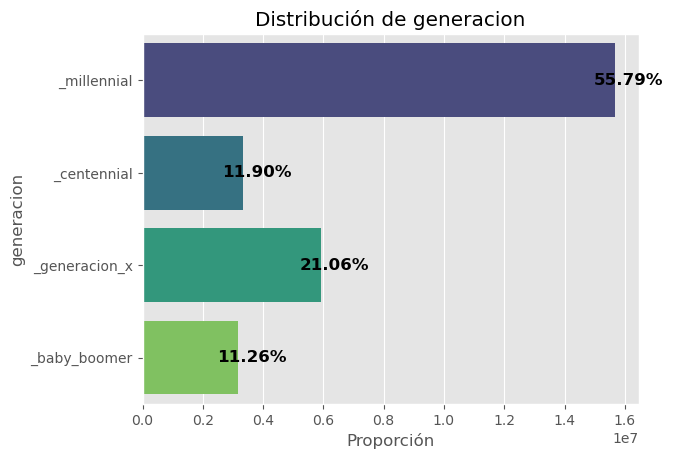

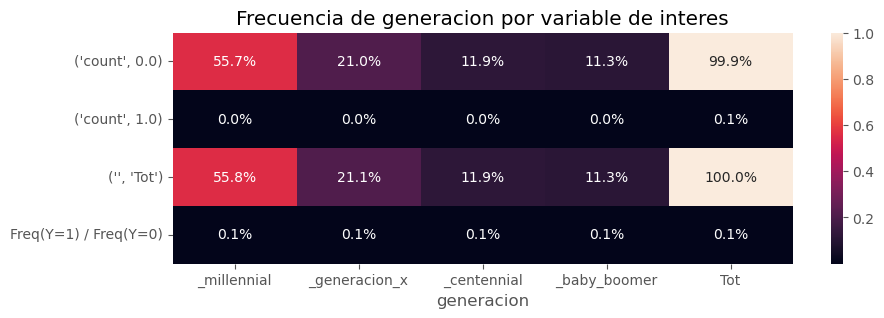

---------------------------------------------
departamento


[03/21/25 15:34:00] WARNING  /tmp/ipykernel_1545/2985282720.py:9: FutureWarning:                    ]8;id=212136;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=803569;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')                
                                                                                                                   

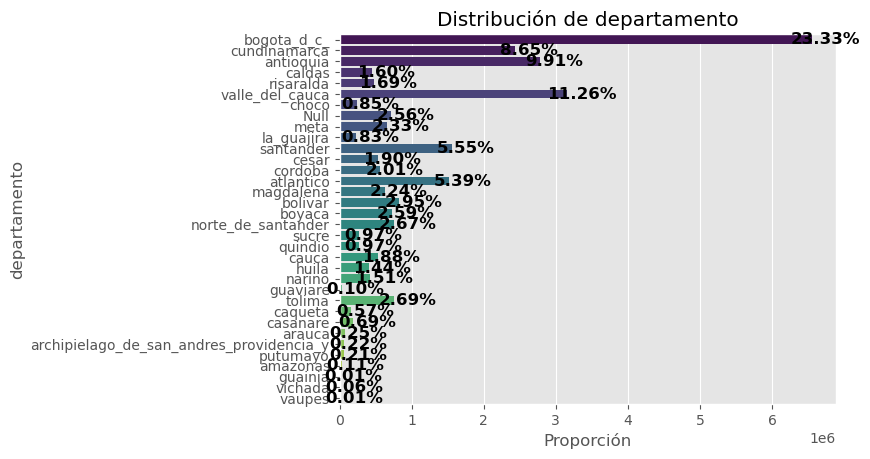

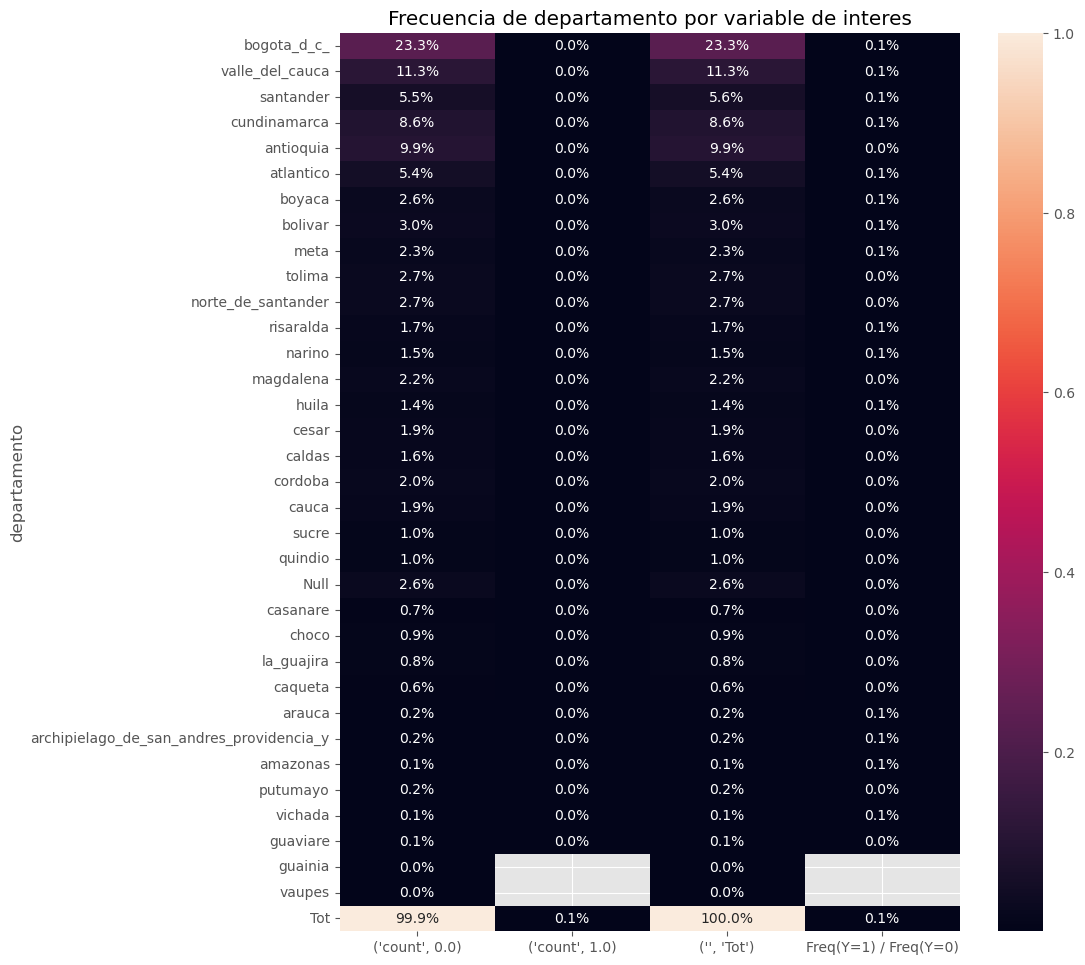

---------------------------------------------
ocupacion


[03/21/25 15:35:09] WARNING  /tmp/ipykernel_1545/2985282720.py:9: FutureWarning:                    ]8;id=617320;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=522583;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')                
                                                                                                                   

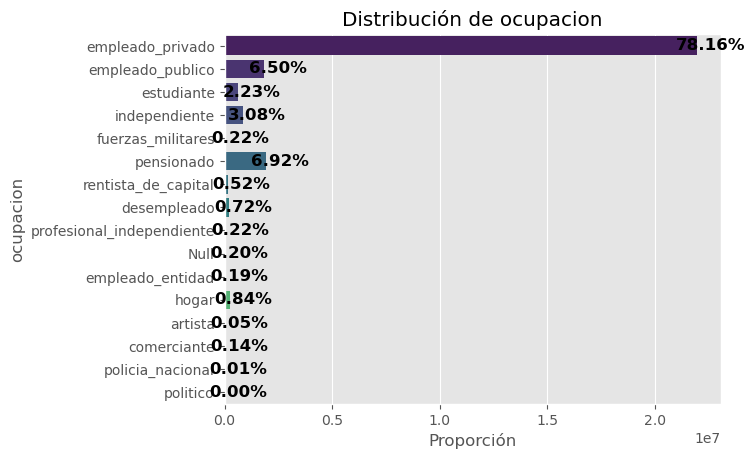

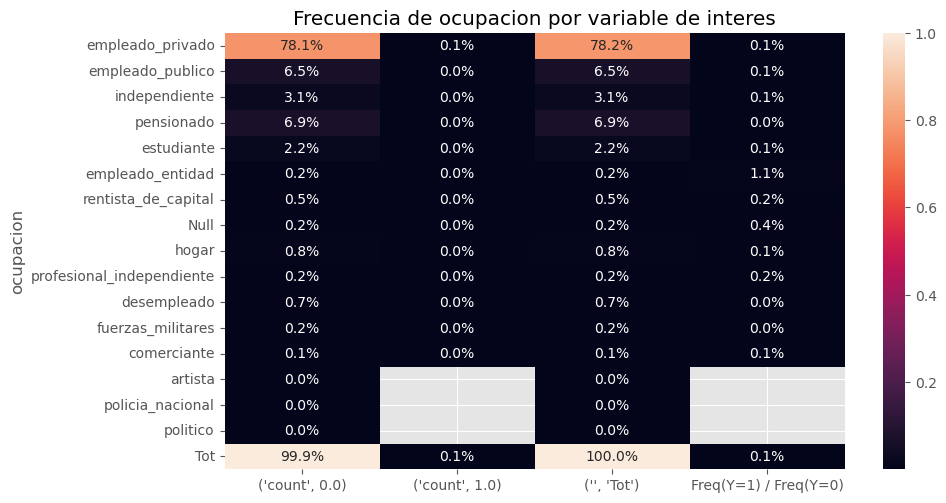

---------------------------------------------
mar_status


[03/21/25 15:36:17] WARNING  /tmp/ipykernel_1545/2985282720.py:9: FutureWarning:                    ]8;id=782566;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=840933;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')                
                                                                                                                   

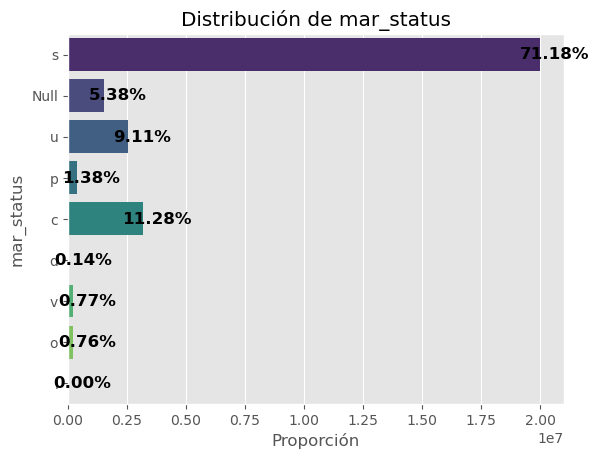

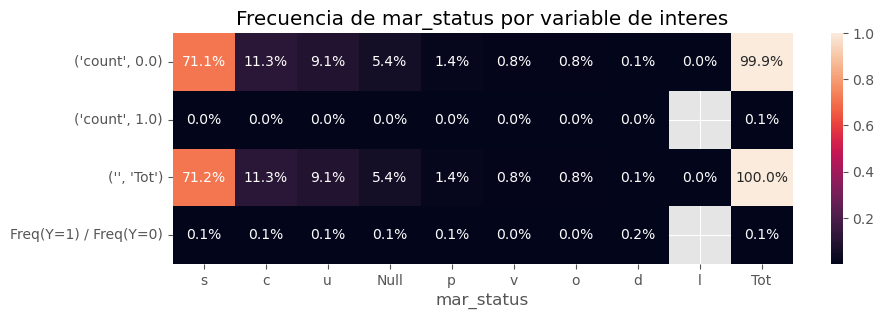

---------------------------------------------
grupo_etario


[03/21/25 15:37:21] WARNING  /tmp/ipykernel_1545/2985282720.py:9: FutureWarning:                    ]8;id=174599;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=484339;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')                
                                                                                                                   

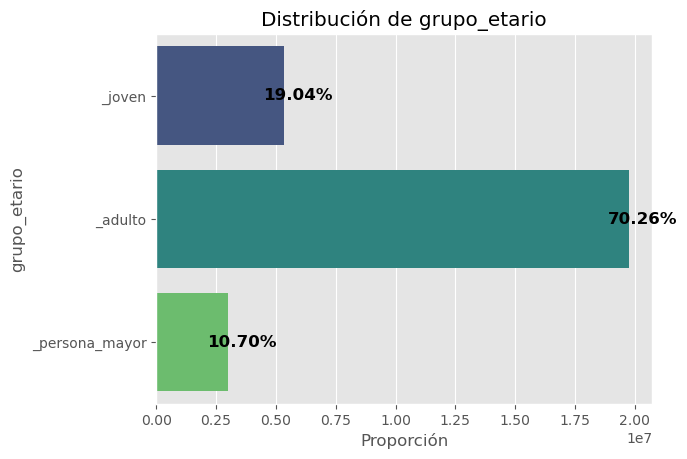

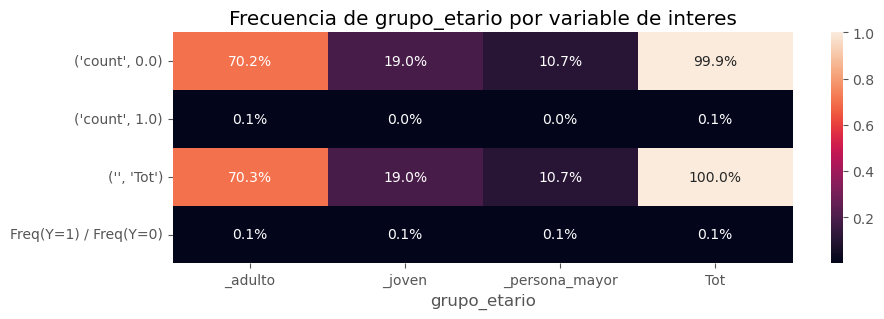

---------------------------------------------
region


[03/21/25 15:38:24] WARNING  /tmp/ipykernel_1545/2985282720.py:9: FutureWarning:                    ]8;id=798029;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=869782;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')                
                                                                                                                   

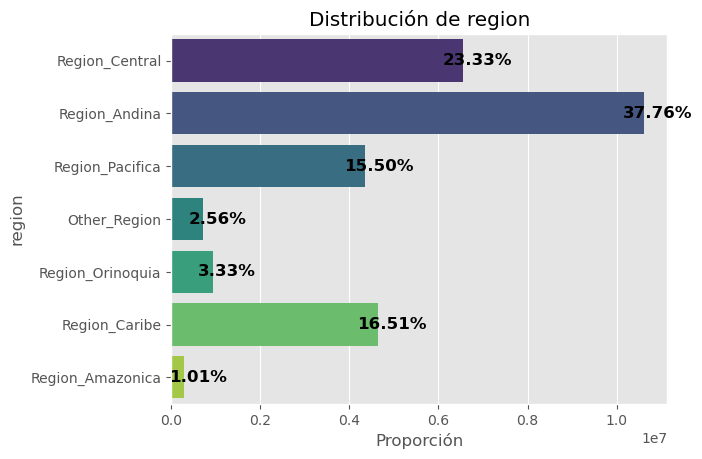

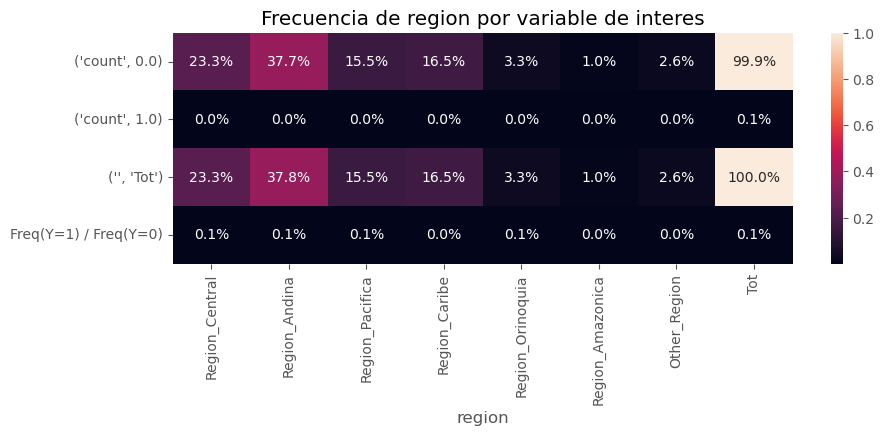

---------------------------------------------
ocupacion2


[03/21/25 15:39:25] WARNING  /tmp/ipykernel_1545/2985282720.py:9: FutureWarning:                    ]8;id=575208;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=749095;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')                
                                                                                                                   

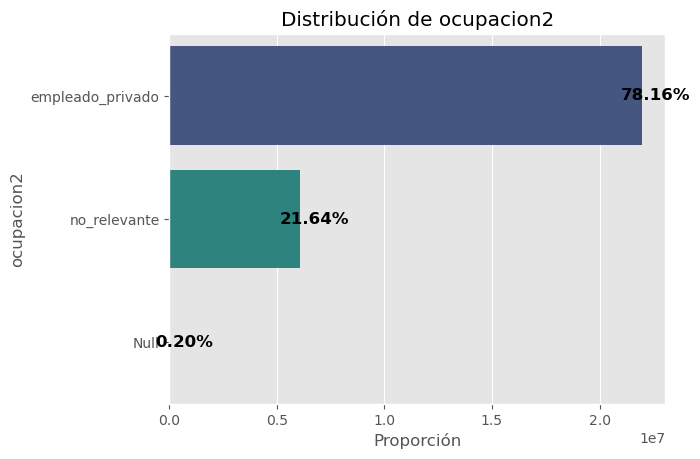

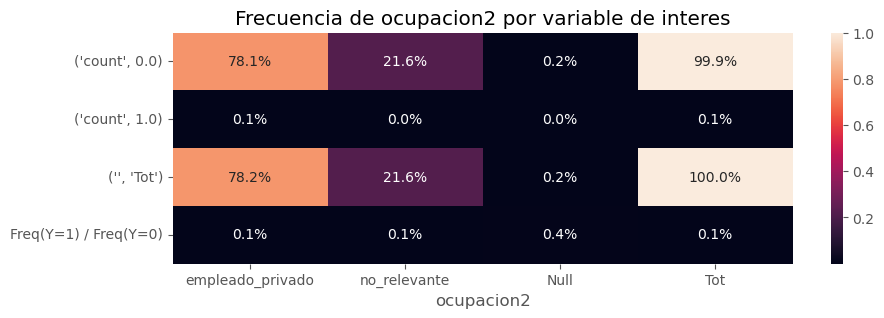

---------------------------------------------
mar_status2


[03/21/25 15:40:24] WARNING  /tmp/ipykernel_1545/2985282720.py:9: FutureWarning:                    ]8;id=94420;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=972730;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')                
                                                                                                                   

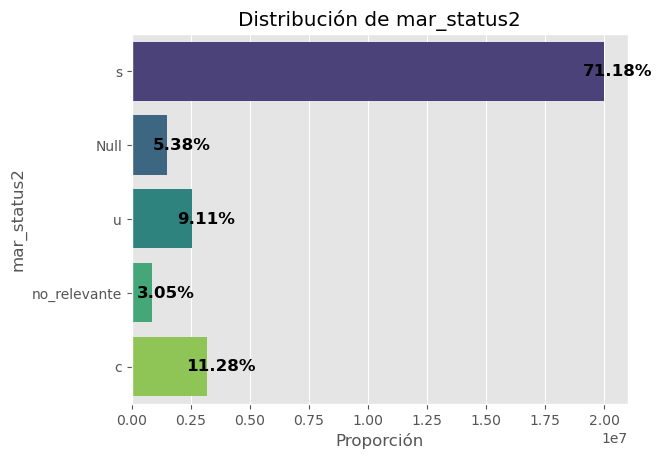

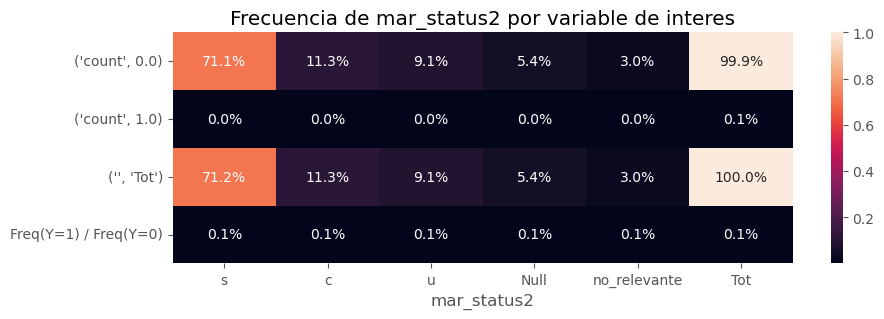

---------------------------------------------
grupo_etario2


[03/21/25 15:41:24] WARNING  /tmp/ipykernel_1545/2985282720.py:9: FutureWarning:                    ]8;id=671753;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=276413;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')                
                                                                                                                   

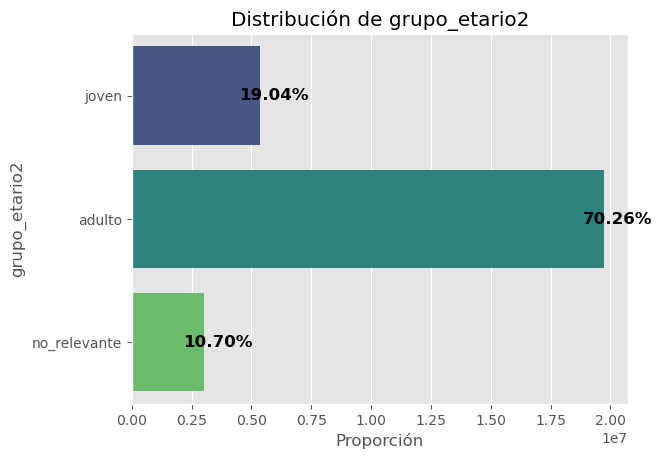

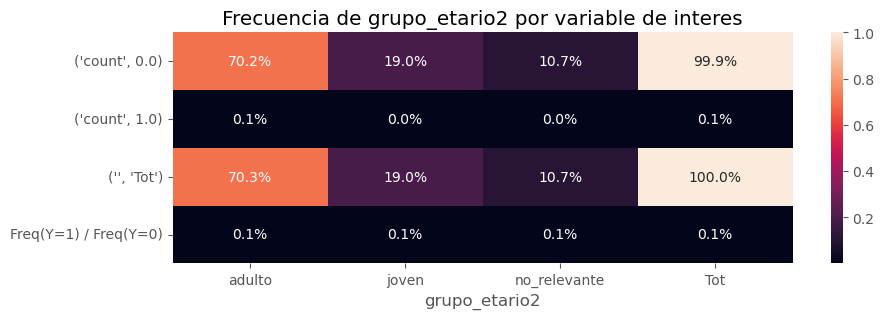

---------------------------------------------
region3


[03/21/25 15:42:25] WARNING  /tmp/ipykernel_1545/2985282720.py:9: FutureWarning:                    ]8;id=5425;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=590843;file:///home/sagemaker-user/.conda/envs/proyecto_fabrica/lib/python3.9/warnings.py#109\109]8;;\
                                                                                                                   
                             Passing `palette` without assigning `hue` is deprecated and will be                   
                             removed in v0.14.0. Assign the `y` variable to `hue` and set                          
                             `legend=False` for the same effect.                                                   
                                                                                                                   
                               ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')                
                                                                                                                   

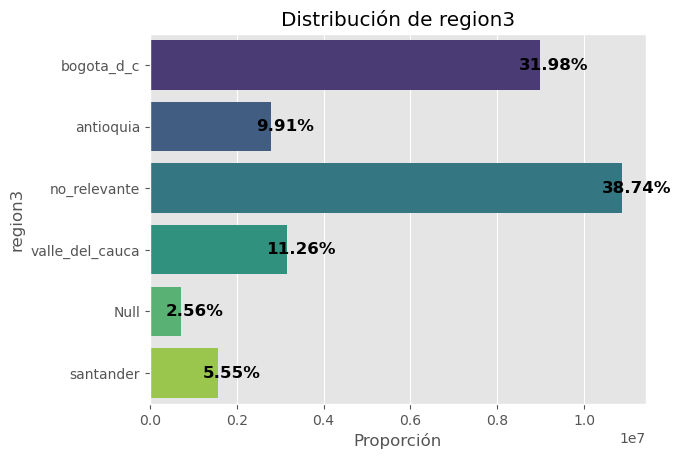

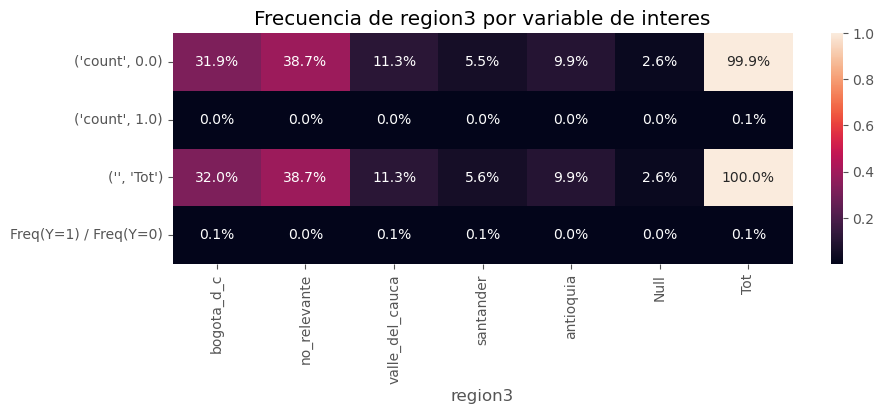

---------------------------------------------


In [17]:
y_target_plot = True
llaves_ids_unicos = [params['id']]
for col in df_categoricas1:
    if col not in llaves_ids_unicos:
        # Crear el gráfico de barras usando sns.countplot
        #plt.figure(figsize=(8, 6))
        print(col)
        plt.style.use('ggplot')
        ax = sns.countplot(y = col, data=df_categoricas1, palette='viridis')

        # Calcular las proporciones y etiquetar las barras
        for p in ax.patches:
            width = p.get_width()  # Usamos width en vez de height porque el gráfico es horizontal
            proportion = width / df_categoricas1.shape[0]  # Calcular la proporción
            ax.annotate(f'{proportion:.2%}',  # Formato en porcentaje
                        (width, p.get_y() + p.get_height() / 2.),  # Posición de la anotación
                        ha='center', va='center',  # Alinear la anotación
                        fontsize=12, color='black', fontweight='bold', xytext=(10, 0), textcoords='offset points')
        # Etiquetas y título
        plt.ylabel(col)
        plt.xlabel('Proporción')
        plt.title(f'Distribución de {col}')

        # Mostrar el gráfico
        plt.show()
        if y_target_plot == True:
        #df_temp = pd.concat([create_feature[params['target']],df_categoricas1[col]],axis = 1)
            df_temp = df_categoricas1[[col]]
            df_temp.index = create_feature[params['target']]
            df_temp = df_temp.reset_index().set_index([params['target'], col])
            df_temp['count'] = 1
            #df_temp.unstack(level = params['target'])#..to_frame()
            df_temp1 = df_temp.groupby([params['target'], col]).sum().unstack(level = params['target'])
            df_temp1 = df_temp1.sort_values(by = ('count',1), ascending= False).T
            df_temp1['Tot'] = df_temp1.sum(axis= 1)
            df_temp1 = df_temp1.T
            df_temp1[('','Tot')] = df_temp1.sum(axis= 1)
            df_temp1 = df_temp1.T
            mdf = df_temp1.index.names
            df_temp1.index.names = ['',mdf[1]]
            n = df_temp1.loc[('','Tot'),'Tot']
            df_temp1 = df_temp1/n
            atribucion =(df_temp1.loc[('count',1)] / df_temp1.loc[('count',0)]).to_frame()
            atribucion.columns = ['Freq(Y=1) / Freq(Y=0)']
            df_temp1 = pd.concat([df_temp1,atribucion.T], axis = 0)
            if df_temp1.shape[1] >10:
                df_temp1 = df_temp1.T
                dim  = (10,df_temp1.shape[0]/3)
            else:
                dim  = (10,3)
                #plt.figure(figsize = (10,3)) 
            plt.figure(figsize = dim)
            plt.title(f'Frecuencia de {col} por variable de interes')
            sns.heatmap(df_temp1, annot = True, fmt = '0.1%')
            plt.show()
        print("---------------------------------------------")

## Analisis en variables numericas

In [ ]:
# procesamiento con data original
dataset0 = create_feature.select_dtypes(exclude=['object', 'bool'])
y_target = create_feature[params['target']]
if 'periodo' in dataset0.columns:
    if 'AAAA' not in dataset0.columns:
        dataset0['AAAA'] = dataset0['periodo'].astype(str).str[:4].astype(float)
    if 'mes' not in dataset0.columns:
        dataset0['mes'] = dataset0['periodo'].astype(str).str[4:].astype(float)

**Segmentacion de datos numericos por enteros:**

In [ ]:
# Función para verificar si todos los valores son enteros (incluso en columnas de tipo float)
def check_if_all_integers(series):
    return (series.dropna() % 1 == 0).all()

In [ ]:
# Verificar el tipo y si los valores son enteros
enteros = []
for col in dataset0.columns:
    dtype = dataset0[col].dtype
    if pd.api.types.is_integer_dtype(dtype):
#        print(f'La columna "{col}" tiene tipo de dato entero (int).')
        if dataset0[col].unique().shape[0]<10:
            enteros.append(col)
        else:
            print(f'La columna "{col}" tiene muchos datos tipo  entero (int).')
    elif pd.api.types.is_float_dtype(dtype):
        if check_if_all_integers(dataset0[col]):
#            print(f'La columna "{col}" es de tipo flotante pero contiene solo enteros.')
            if dataset0[col].unique().shape[0]<10:
                enteros.append(col)
            else:
                print(f'La columna "{col}" tiene muchos datos tipo  entero (int).')
        else:
            print(f'La columna "{col}" tiene tipo de dato real (float).')
    else:
        print(f'La columna "{col}" tiene tipo de dato: {dtype}.')


In [ ]:
print(len(enteros))

In [ ]:
enteros

**Variables enteros con pocos valores unicos que son significantes:**

In [38]:
print('LiSTA DE VARIABLES QUE DESEO CONOCER SU DISTRIBUCION')
variables_filters = ['estrato',    'perfil_riesgo',    'nivel_educativo',    'fac_cant',    'ld_cant',    'ord_cant',    'ah_cant',
                     'tc_cant',    'tc_cant_mora',    'cc_cant',    'viv_cant',    'otras_ord_cant',    'sus_cant',    'cs_cant_mora',
                     'cs_cant',    'lib_cant',    'veh_cant',    'AAAA']
variables_filters

LiSTA DE VARIABLES QUE DESEO CONOCER SU DISTRIBUCION



[
    'estrato',
    'perfil_riesgo',
    'nivel_educativo',
    'fac_cant',
    'ld_cant',
    'ord_cant',
    'ah_cant',
    'tc_cant',
    'tc_cant_mora',
    'cc_cant',
    'viv_cant',
    'otras_ord_cant',
    'sus_cant',
    'cs_cant_mora',
    'cs_cant',
    'lib_cant',
    'veh_cant',
    'AAAA'
]

In [ ]:
# data
df_graph = dataset0
# variable target
y_target_plot = True
y_target

for col in df_graph:
    if (col in enteros) &(col in variables_filters):
        # Calcular la media y mediana
        df_graph[col] = df_graph[col].replace('Null',np.nan)
        media = df_graph[col].mean()
        mediana = df_graph[col].median()
        mini = df_graph[col].min()
        maxi = df_graph[col].max()
        # Crear el histograma con seaborn
        plt.figure(figsize=(5, 2))
        plt.subplot(121)
        sns.violinplot(df_graph[col].replace('Null', np.nan),orient='h')
        plt.title(f'Densidad de {col}')
        # Mostrar el gráfico
        #plt.show()
    
        plt.figure(figsize=(5, 2))
        plt.subplot(122)
        plt.style.use('ggplot')
        sns.histplot(df_graph[col], kde=True, color='skyblue', bins=100)
    
        # Añadir líneas para la media y mediana
        plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
        plt.axvline(mediana, color='green', linestyle='-', label=f'Mediana: {mediana:.2f}')
        plt.axvline(mini, color='orange', linestyle='-', label=f'Minimo: {mediana:.2f}')
        plt.axvline(maxi, color='purple', linestyle='-', label=f'Maximo: {mediana:.2f}')
        # Añadir las anotaciones
        #plt.text(media + 0.5, 80, f'Media: {media:.2f}', color='red', fontsize=12, fontweight='bold')
        #plt.text(mediana + 0.5, 80, f'Mediana: {mediana:.2f}', color='green', fontsize=12, fontweight='bold')
        # Etiquetas y título
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.title(f'Histograma de {col}')
        # Mostrar la leyenda
        plt.legend()
        # Mostrar el gráfico
        plt.show()
        if y_target_plot == True:
            df_temp = pd.concat([y_target,df_graph[[col]].fillna('Non')], axis = 1)
            if (col in enteros):
                df_temp = df_temp.value_counts().to_frame()
                df_temp = df_temp.unstack(level = params['target'])
                df_temp = df_temp.T
                mdf = df_temp.index.names
                df_temp['Tot'] = df_temp.sum(axis= 1)
                df_temp = df_temp.T
                df_temp[('','Tot')] = df_temp.sum(axis= 1)
                df_temp = df_temp.T
                df_temp = df_temp/df_temp.loc[('','Tot'),'Tot']
                atribucion =(df_temp.loc[('count',1)] / df_temp.loc[('count',0)]).to_frame()
                atribucion.columns = ['Freq(Y=1) / Freq(Y=0)']
                df_temp = pd.concat([df_temp,atribucion.T], axis = 0)
    
                #df_temp.index.names = ['',mdf[1]]
                plt.figure(figsize = (10,2))
                plt.title(f'Frecuencia del {col} segun la variable de interes ')
                sns.heatmap(df_temp, annot = True, fmt = '0.2%')
                plt.show()
            else:
                pass
        print("------------------------------------------------------------------------------------")
print('Ok!')

**Variables flotantes o enteros con muchos enteros y que sean relevantes**

In [ ]:
quiero_graficar = []
for col in df_graph:
    if col not in enteros:
        quiero_graficar.append(col)
quiero_graficar


[
    'periodo',
    'mcro_sum_numero_cuotas_total',
    'antiguedad_meses',
    'edad_anios',
    'fac_sum_numero_cuotas_pagadas',
    'fac_prom_plazo',
    'fac_sum_numero_cuotas_total',
    'fac_sum_pago_acumulado',
    'fac_sum_saldo_corte',
    'fac_sum_intereses',
    'fac_sum_saldo_promedio',
    'fac_sum_cuota_pactada',
    'fac_sum_monto',
    'fac_sum_pago_mes',
    'ld_sum_numero_cuotas_total',
    'ld_prom_plazo',
    'ld_sum_pago_mes',
    'ld_sum_cuota_pactada',
    'ld_sum_intereses',
    'ld_sum_pago_acumulado',
    'ld_sum_monto',
    'ld_sum_saldo_promedio',
    'ld_cant_prev',
    'ld_cant',
    'ld_sum_numero_cuotas_pagadas',
    'ld_sum_saldo_corte',
    'ord_sum_numero_cuotas_total',
    'ord_sum_monto',
    'ord_sum_saldo_corte',
    'ord_sum_saldo_promedio',
    'ord_sum_numero_cuotas_pagadas',
    'ord_prom_plazo',
    'ord_sum_pago_mes',
    'ord_sum_cuota_pactada',
    'ord_cant_prev',
    'ord_sum_pago_acumulado',
    'ord_sum_intereses',
    'leasing_sum_c

In [41]:
print('LiSTA DE VARIABLES QUE DESEO CONOCER SU DISTRIBUCION')
variables_filters = ['periodo',    'num_prod_activos','num_prod_pasivos',      'mes']
variables_filters

LiSTA DE VARIABLES QUE DESEO CONOCER SU DISTRIBUCION


['periodo', 'num_prod_activos', 'num_prod_pasivos', 'mes']

In [42]:
# data
df_graph = dataset0
# variable target
y_target_plot = True
y_target

quiero_graficar = []
for col in df_graph:
    if (col not in enteros) &(col in variables_filters):
        quiero_graficar.append(col)
len(quiero_graficar)

4

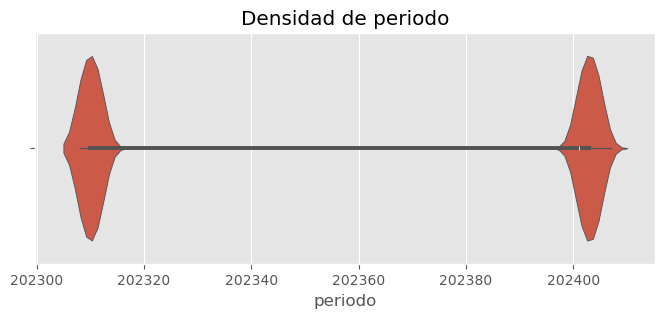

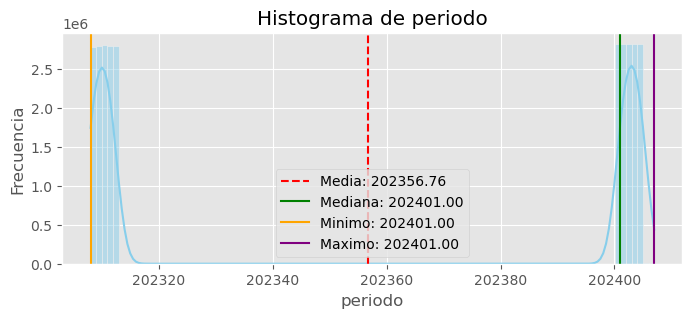

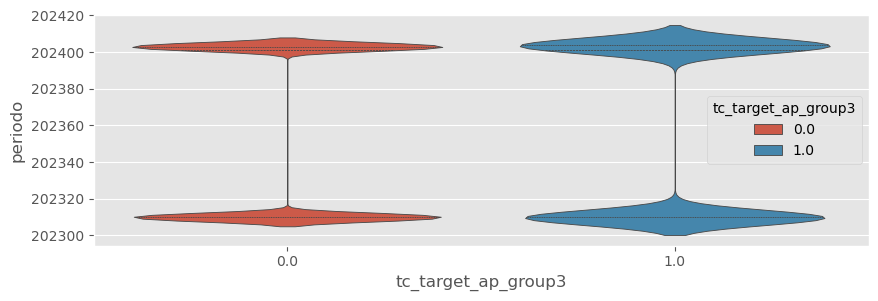

[01/09/25 16:52:31] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=417548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=472317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 16:52:34] INFO     Cantidad de Deciles 10                                                    ]8;id=971564;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=775324;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

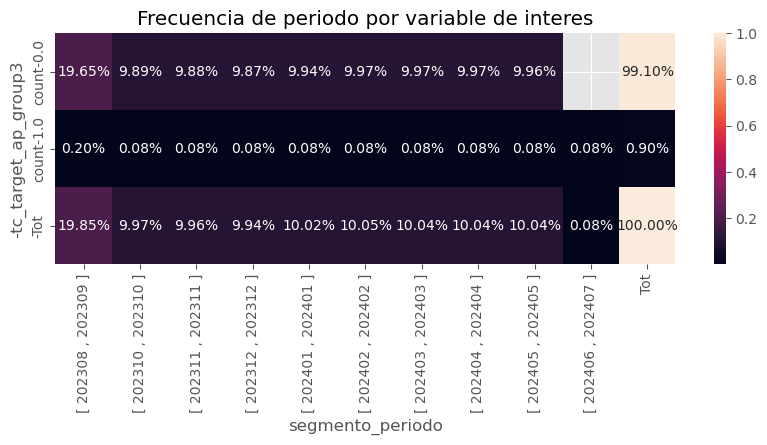

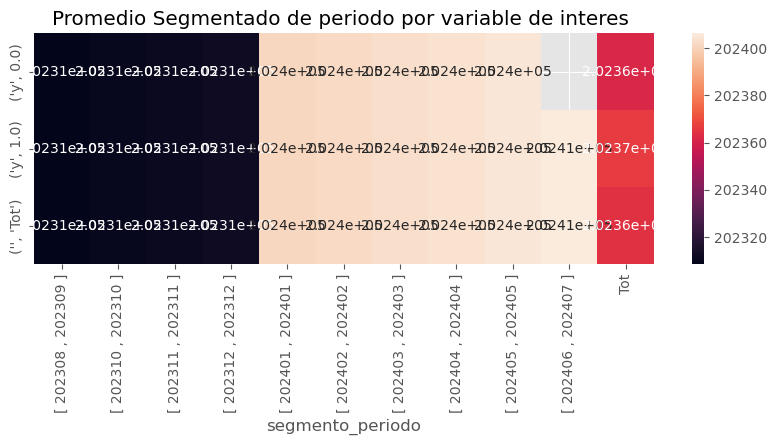

------------------------------------------------------------------------------------


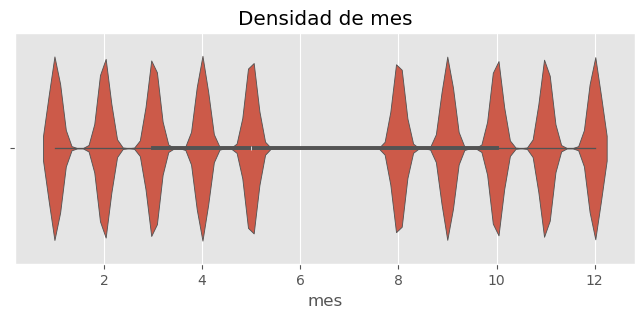

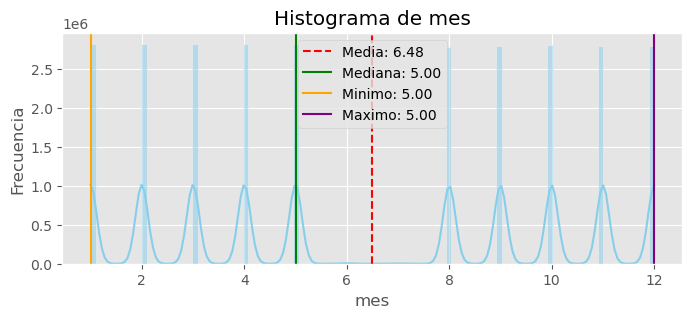

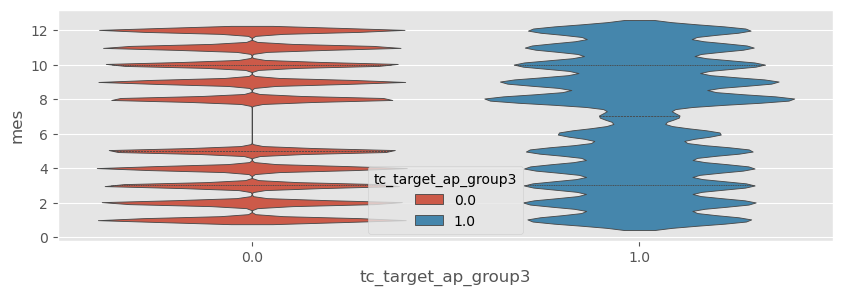

[01/09/25 16:57:54] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=551249;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=378897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 16:57:58] INFO     Cantidad de Deciles 9                                                     ]8;id=367848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=736895;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

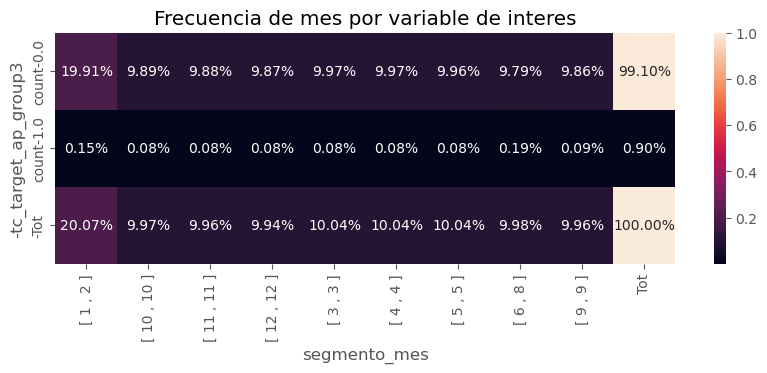

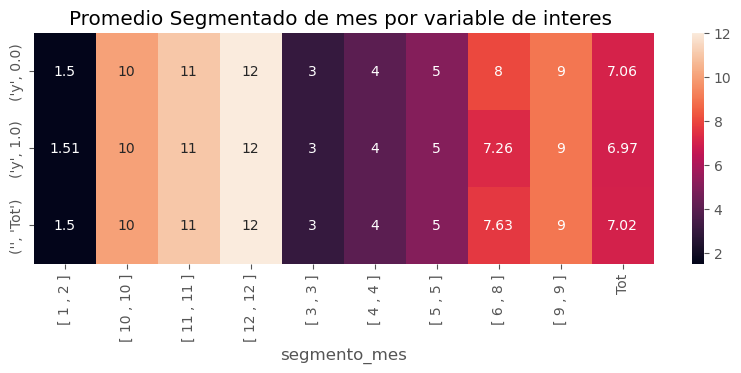

------------------------------------------------------------------------------------


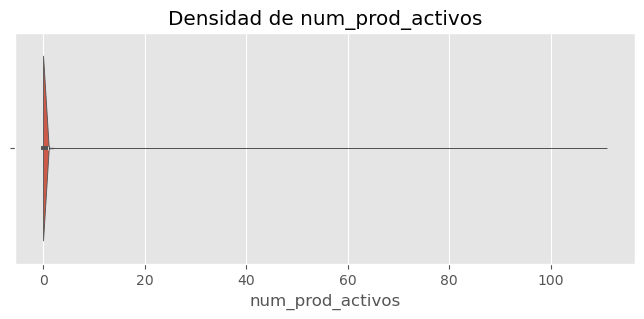

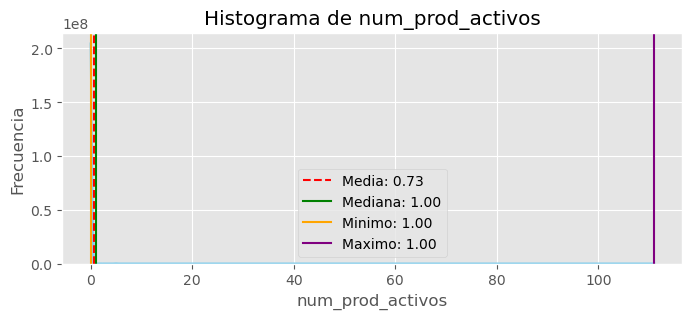

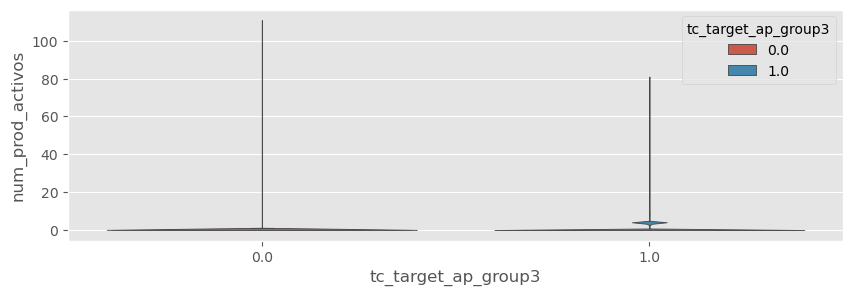

[01/09/25 17:03:16] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=864283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=431964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:03:20] INFO     Cantidad de Deciles 2                                                     ]8;id=747051;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=205654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:03:21] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=20676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=340882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:03:25] INFO     Cantidad de Deciles 3                                                     ]8;id=719166;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=654426;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=726559;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=116937;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:03:29] INFO     Cantidad de Deciles 3                                                     ]8;id=649392;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=469844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=551971;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=859423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:03:34] INFO     Cantidad de Deciles 3                                                     ]8;id=643575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=537195;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=43371;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=729818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:03:38] INFO     Cantidad de Deciles 3                                                     ]8;id=898072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=46149;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=973534;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=340483;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:03:42] INFO     Cantidad de Deciles 3                                                     ]8;id=657981;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=768155;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=982548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=742901;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:03:47] INFO     Cantidad de Deciles 3                                                     ]8;id=898800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=812654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=300783;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=404652;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:03:51] INFO     Cantidad de Deciles 3                                                     ]8;id=366001;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=716170;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=597465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=107231;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:03:55] INFO     Cantidad de Deciles 3                                                     ]8;id=280015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=361549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:03:56] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=607205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=912382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:00] INFO     Cantidad de Deciles 3                                                     ]8;id=596099;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=31737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=70286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=294016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:04] INFO     Cantidad de Deciles 3                                                     ]8;id=809551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=899447;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=571641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=659410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:08] INFO     Cantidad de Deciles 3                                                     ]8;id=212391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=165871;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:04:09] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=811369;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=308581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:13] INFO     Cantidad de Deciles 3                                                     ]8;id=600185;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=107587;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=260243;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=885858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:17] INFO     Cantidad de Deciles 3                                                     ]8;id=601573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=776029;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=333483;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=106845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:22] INFO     Cantidad de Deciles 3                                                     ]8;id=150248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=173231;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=720946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=205820;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:26] INFO     Cantidad de Deciles 3                                                     ]8;id=248756;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=783793;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=441533;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=902018;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:30] INFO     Cantidad de Deciles 3                                                     ]8;id=497836;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=375258;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=497282;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=502925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:35] INFO     Cantidad de Deciles 3                                                     ]8;id=654794;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=55710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=276013;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=87216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:39] INFO     Cantidad de Deciles 3                                                     ]8;id=708014;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=944399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=170473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=333800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:43] INFO     Cantidad de Deciles 3                                                     ]8;id=702425;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=567803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=528114;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=723947;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:48] INFO     Cantidad de Deciles 3                                                     ]8;id=215368;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=764439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=782560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=816653;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:52] INFO     Cantidad de Deciles 3                                                     ]8;id=180318;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=746924;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=189688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=361487;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:04:56] INFO     Cantidad de Deciles 3                                                     ]8;id=479081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=929517;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=267970;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=217924;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:01] INFO     Cantidad de Deciles 3                                                     ]8;id=815577;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=220796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=964831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=677647;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:05] INFO     Cantidad de Deciles 3                                                     ]8;id=151333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=929324;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=953111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=122226;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:09] INFO     Cantidad de Deciles 3                                                     ]8;id=76575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=417422;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=806141;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=810421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:14] INFO     Cantidad de Deciles 3                                                     ]8;id=259509;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=625549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=738551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=851700;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:18] INFO     Cantidad de Deciles 3                                                     ]8;id=483982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=881537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=916745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=34459;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:22] INFO     Cantidad de Deciles 3                                                     ]8;id=650956;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=805614;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=534578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=615090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:27] INFO     Cantidad de Deciles 3                                                     ]8;id=897531;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=150168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=199198;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=389682;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:31] INFO     Cantidad de Deciles 3                                                     ]8;id=671355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=512843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=917333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=932345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:35] INFO     Cantidad de Deciles 3                                                     ]8;id=313694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=875896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=903765;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=240805;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:40] INFO     Cantidad de Deciles 3                                                     ]8;id=546918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=185;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=901549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=945795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:44] INFO     Cantidad de Deciles 3                                                     ]8;id=427421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=536373;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=35661;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=995538;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:48] INFO     Cantidad de Deciles 3                                                     ]8;id=614887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=693902;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=974333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=835337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:53] INFO     Cantidad de Deciles 3                                                     ]8;id=796954;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=460335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=441831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=181088;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:05:57] INFO     Cantidad de Deciles 3                                                     ]8;id=232470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=223817;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=955189;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=405336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:01] INFO     Cantidad de Deciles 3                                                     ]8;id=597591;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=67490;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=611602;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=672159;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:06] INFO     Cantidad de Deciles 3                                                     ]8;id=741499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=319992;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=929296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=500746;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:10] INFO     Cantidad de Deciles 3                                                     ]8;id=316632;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=329169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=255513;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=397403;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:14] INFO     Cantidad de Deciles 3                                                     ]8;id=770284;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=726356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=536474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=23149;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:19] INFO     Cantidad de Deciles 3                                                     ]8;id=811909;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=828470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=329869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=775517;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:23] INFO     Cantidad de Deciles 3                                                     ]8;id=177625;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=423467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=261062;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=13888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:27] INFO     Cantidad de Deciles 3                                                     ]8;id=123856;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=680428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:06:28] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=687143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=41491;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:32] INFO     Cantidad de Deciles 3                                                     ]8;id=613650;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=338408;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=85685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=855744;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:36] INFO     Cantidad de Deciles 3                                                     ]8;id=2382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=355019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=289059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=736970;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:41] INFO     Cantidad de Deciles 3                                                     ]8;id=92396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=618194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=715035;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=743806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:45] INFO     Cantidad de Deciles 3                                                     ]8;id=137679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=222569;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=662230;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=505495;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:49] INFO     Cantidad de Deciles 3                                                     ]8;id=196664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=332952;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=737389;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=502387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:54] INFO     Cantidad de Deciles 3                                                     ]8;id=156200;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=509170;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=118612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=359951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:06:58] INFO     Cantidad de Deciles 3                                                     ]8;id=882554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=694296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=66753;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=887170;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:02] INFO     Cantidad de Deciles 3                                                     ]8;id=494318;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=438224;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:07:03] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=700540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=334956;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:07] INFO     Cantidad de Deciles 3                                                     ]8;id=257473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=147522;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=207533;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=73826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:11] INFO     Cantidad de Deciles 3                                                     ]8;id=265340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=941745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=707768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=779801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:15] INFO     Cantidad de Deciles 3                                                     ]8;id=31968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=700624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:07:16] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=434114;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=701260;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:20] INFO     Cantidad de Deciles 3                                                     ]8;id=314536;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=350384;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=254526;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=213679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:24] INFO     Cantidad de Deciles 3                                                     ]8;id=358149;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=490320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=867156;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=972246;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:28] INFO     Cantidad de Deciles 3                                                     ]8;id=111284;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=365047;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:07:29] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=202418;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=455960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:33] INFO     Cantidad de Deciles 3                                                     ]8;id=745227;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=389369;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=822639;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=800511;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:37] INFO     Cantidad de Deciles 3                                                     ]8;id=735519;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=765126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=717938;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=844573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:41] INFO     Cantidad de Deciles 3                                                     ]8;id=731129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=993341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:07:42] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=790097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=261888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:46] INFO     Cantidad de Deciles 3                                                     ]8;id=52827;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=522215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=553754;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=840276;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:50] INFO     Cantidad de Deciles 3                                                     ]8;id=467858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=766677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=225604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=838876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:54] INFO     Cantidad de Deciles 3                                                     ]8;id=373347;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=563913;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=762385;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=458957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:07:59] INFO     Cantidad de Deciles 3                                                     ]8;id=411178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=954455;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=287432;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=153494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:03] INFO     Cantidad de Deciles 3                                                     ]8;id=970670;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=162320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=770994;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=940428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:07] INFO     Cantidad de Deciles 3                                                     ]8;id=659105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=670746;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=819646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=717152;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:12] INFO     Cantidad de Deciles 3                                                     ]8;id=395440;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=261747;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=859423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=796228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:16] INFO     Cantidad de Deciles 3                                                     ]8;id=727284;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=198950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=996950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=429694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:20] INFO     Cantidad de Deciles 3                                                     ]8;id=350054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=764563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=580450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=848356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:25] INFO     Cantidad de Deciles 3                                                     ]8;id=596588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=694434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=717044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=435958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:29] INFO     Cantidad de Deciles 3                                                     ]8;id=584867;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=257654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=332039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=432950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:33] INFO     Cantidad de Deciles 3                                                     ]8;id=458788;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=35738;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=760809;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=574540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:38] INFO     Cantidad de Deciles 3                                                     ]8;id=421110;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=729873;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=238182;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=352345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:42] INFO     Cantidad de Deciles 3                                                     ]8;id=33858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=143195;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=873691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=265866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:46] INFO     Cantidad de Deciles 3                                                     ]8;id=808210;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=195387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=754336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=839031;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:51] INFO     Cantidad de Deciles 3                                                     ]8;id=861676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=910607;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=132742;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=184037;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:55] INFO     Cantidad de Deciles 3                                                     ]8;id=398391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=350643;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=818831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=237936;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:08:59] INFO     Cantidad de Deciles 3                                                     ]8;id=769175;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=189117;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=727627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=960322;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:04] INFO     Cantidad de Deciles 3                                                     ]8;id=338261;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=680521;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=62624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=435761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:08] INFO     Cantidad de Deciles 3                                                     ]8;id=58923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=594461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=155396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=965874;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:12] INFO     Cantidad de Deciles 3                                                     ]8;id=341228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=160883;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=474620;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=954552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:17] INFO     Cantidad de Deciles 3                                                     ]8;id=901344;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=272248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=207489;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=520530;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:21] INFO     Cantidad de Deciles 3                                                     ]8;id=11893;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=553033;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=851953;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=870174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:25] INFO     Cantidad de Deciles 3                                                     ]8;id=790851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=623943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=867486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=59778;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:29] INFO     Cantidad de Deciles 3                                                     ]8;id=661343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=879620;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:09:30] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=260460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=166930;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:34] INFO     Cantidad de Deciles 3                                                     ]8;id=686711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=593322;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=733709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=72897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:38] INFO     Cantidad de Deciles 3                                                     ]8;id=134396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=327844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=698105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=992136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:42] INFO     Cantidad de Deciles 3                                                     ]8;id=23567;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=590428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:09:43] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=83330;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=571410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:47] INFO     Cantidad de Deciles 3                                                     ]8;id=659981;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=274361;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=568358;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=874070;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:51] INFO     Cantidad de Deciles 3                                                     ]8;id=366534;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=141770;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=601816;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=929062;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:09:55] INFO     Cantidad de Deciles 3                                                     ]8;id=297415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=808080;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:09:56] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=271955;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=126035;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:00] INFO     Cantidad de Deciles 3                                                     ]8;id=144457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=5011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=721357;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=502711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:04] INFO     Cantidad de Deciles 3                                                     ]8;id=155406;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=160552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=144681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=51468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:08] INFO     Cantidad de Deciles 3                                                     ]8;id=907616;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=119638;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:10:09] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=367691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=766734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:13] INFO     Cantidad de Deciles 3                                                     ]8;id=880524;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=10564;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=447964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=503981;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:17] INFO     Cantidad de Deciles 3                                                     ]8;id=239612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=706110;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=663522;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=516126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:21] INFO     Cantidad de Deciles 3                                                     ]8;id=225320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=721660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:10:22] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=183372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=342302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:26] INFO     Cantidad de Deciles 3                                                     ]8;id=986199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=188401;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=744433;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=930962;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:30] INFO     Cantidad de Deciles 3                                                     ]8;id=206468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=422848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=664828;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=360898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:34] INFO     Cantidad de Deciles 3                                                     ]8;id=754142;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=185864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=666260;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=792749;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:39] INFO     Cantidad de Deciles 3                                                     ]8;id=732773;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=49734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=905748;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=710201;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:43] INFO     Cantidad de Deciles 3                                                     ]8;id=126719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=508;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=843123;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:47] INFO     Cantidad de Deciles 3                                                     ]8;id=54888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=964882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=983374;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=194876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:52] INFO     Cantidad de Deciles 3                                                     ]8;id=159446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=646505;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=557197;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=528168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:10:56] INFO     Cantidad de Deciles 3                                                     ]8;id=186046;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=830376;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=603056;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=850888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:00] INFO     Cantidad de Deciles 3                                                     ]8;id=57990;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=60488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=951705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=177695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:05] INFO     Cantidad de Deciles 3                                                     ]8;id=474003;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=233809;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=21069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=303472;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:09] INFO     Cantidad de Deciles 3                                                     ]8;id=703870;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=166992;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=634541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=709303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:13] INFO     Cantidad de Deciles 3                                                     ]8;id=358802;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=929794;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=875900;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=346308;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:18] INFO     Cantidad de Deciles 3                                                     ]8;id=664134;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=641904;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=780081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=339910;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:22] INFO     Cantidad de Deciles 3                                                     ]8;id=944782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=82416;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=136011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=481804;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:26] INFO     Cantidad de Deciles 3                                                     ]8;id=420463;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=271829;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=611363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=141299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:31] INFO     Cantidad de Deciles 3                                                     ]8;id=660432;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=861713;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=277506;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=490988;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:35] INFO     Cantidad de Deciles 3                                                     ]8;id=971556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=696216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=615479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=730908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:39] INFO     Cantidad de Deciles 3                                                     ]8;id=185270;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=426583;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=174268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=406434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:44] INFO     Cantidad de Deciles 3                                                     ]8;id=644751;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=142795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=557320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=39553;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:48] INFO     Cantidad de Deciles 3                                                     ]8;id=105687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=185678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=899493;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=851200;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:52] INFO     Cantidad de Deciles 3                                                     ]8;id=26774;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=399204;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=952902;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=10858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:11:57] INFO     Cantidad de Deciles 3                                                     ]8;id=104308;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=799940;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=854259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=70562;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:01] INFO     Cantidad de Deciles 3                                                     ]8;id=813886;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=676871;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=24292;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=194294;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:05] INFO     Cantidad de Deciles 3                                                     ]8;id=618894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=601927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=494678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=684794;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:10] INFO     Cantidad de Deciles 3                                                     ]8;id=427132;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=812588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=925016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=567552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:14] INFO     Cantidad de Deciles 3                                                     ]8;id=452693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=744706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=285208;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=386402;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:18] INFO     Cantidad de Deciles 3                                                     ]8;id=874616;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=722168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=816044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=571864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:23] INFO     Cantidad de Deciles 3                                                     ]8;id=819299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=814070;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=132894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=343328;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:27] INFO     Cantidad de Deciles 3                                                     ]8;id=972166;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=721312;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=290228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=400415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:31] INFO     Cantidad de Deciles 3                                                     ]8;id=849718;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=657067;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=639287;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=934540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:36] INFO     Cantidad de Deciles 3                                                     ]8;id=953406;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=540761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=248239;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=341048;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:40] INFO     Cantidad de Deciles 3                                                     ]8;id=644473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=463979;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=348105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=125727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:44] INFO     Cantidad de Deciles 3                                                     ]8;id=163790;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=597839;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=200023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=906017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:48] INFO     Cantidad de Deciles 3                                                     ]8;id=419788;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=850214;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:12:49] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=626237;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=259260;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:53] INFO     Cantidad de Deciles 3                                                     ]8;id=924325;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=31575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=19627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=720958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:12:57] INFO     Cantidad de Deciles 3                                                     ]8;id=59421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=898567;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=455336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=543215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:01] INFO     Cantidad de Deciles 3                                                     ]8;id=776806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=942049;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:13:02] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=468884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=35075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:06] INFO     Cantidad de Deciles 3                                                     ]8;id=446055;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=287464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=959216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=176526;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:10] INFO     Cantidad de Deciles 3                                                     ]8;id=928078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=757266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=849787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=393746;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:14] INFO     Cantidad de Deciles 3                                                     ]8;id=120708;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=493586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:13:15] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=575707;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=50944;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:19] INFO     Cantidad de Deciles 3                                                     ]8;id=937797;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=644763;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=34288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=644958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:23] INFO     Cantidad de Deciles 3                                                     ]8;id=443722;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=927526;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=834391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=260183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:27] INFO     Cantidad de Deciles 3                                                     ]8;id=985453;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=3382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=900792;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=383718;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:32] INFO     Cantidad de Deciles 3                                                     ]8;id=435470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=398650;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=702741;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=721843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:36] INFO     Cantidad de Deciles 3                                                     ]8;id=644958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=504675;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=752140;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=182285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:40] INFO     Cantidad de Deciles 3                                                     ]8;id=462898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=418572;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=319424;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=723154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:45] INFO     Cantidad de Deciles 3                                                     ]8;id=808112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=957739;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=928456;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=642031;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:49] INFO     Cantidad de Deciles 3                                                     ]8;id=53854;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=393406;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=841228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=289393;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:53] INFO     Cantidad de Deciles 3                                                     ]8;id=739850;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=962557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=813306;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=180005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:13:58] INFO     Cantidad de Deciles 3                                                     ]8;id=212469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=245531;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=598493;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=847287;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:02] INFO     Cantidad de Deciles 3                                                     ]8;id=908322;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=417804;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=892891;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=214940;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:06] INFO     Cantidad de Deciles 3                                                     ]8;id=726345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=408064;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=860540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=385992;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:11] INFO     Cantidad de Deciles 3                                                     ]8;id=156426;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=528286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=977967;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=657188;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:15] INFO     Cantidad de Deciles 3                                                     ]8;id=573594;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=559135;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=820911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=175437;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:19] INFO     Cantidad de Deciles 3                                                     ]8;id=305765;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=569718;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=988059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=942125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:24] INFO     Cantidad de Deciles 3                                                     ]8;id=732314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=578477;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=888168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=357974;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:28] INFO     Cantidad de Deciles 3                                                     ]8;id=659674;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=436970;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=246144;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=167174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:32] INFO     Cantidad de Deciles 3                                                     ]8;id=656569;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=55474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=891712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=71897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:37] INFO     Cantidad de Deciles 3                                                     ]8;id=847094;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=292107;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=162058;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=137029;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:41] INFO     Cantidad de Deciles 3                                                     ]8;id=199644;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=644806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=29339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=281338;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:45] INFO     Cantidad de Deciles 3                                                     ]8;id=280299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=647611;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=503332;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=510087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:50] INFO     Cantidad de Deciles 3                                                     ]8;id=227964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=457889;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=895950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=27585;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:54] INFO     Cantidad de Deciles 3                                                     ]8;id=240667;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=48180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=305322;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=752487;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:14:58] INFO     Cantidad de Deciles 3                                                     ]8;id=275305;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=808800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=639712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=400837;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:02] INFO     Cantidad de Deciles 3                                                     ]8;id=68310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=298662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:15:03] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=322899;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=771703;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:07] INFO     Cantidad de Deciles 3                                                     ]8;id=897090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=883259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=931418;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=102092;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:11] INFO     Cantidad de Deciles 3                                                     ]8;id=927059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=930793;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=155960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=280248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:15] INFO     Cantidad de Deciles 3                                                     ]8;id=458343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=766177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:15:16] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=904055;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=85346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:20] INFO     Cantidad de Deciles 3                                                     ]8;id=437228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=973524;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=449049;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=811883;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:24] INFO     Cantidad de Deciles 3                                                     ]8;id=369019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=64183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=113289;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=753751;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:28] INFO     Cantidad de Deciles 3                                                     ]8;id=393419;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=257493;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:15:29] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=455951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=233117;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:33] INFO     Cantidad de Deciles 3                                                     ]8;id=245988;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=270473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=939933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=66600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:37] INFO     Cantidad de Deciles 3                                                     ]8;id=669016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=83719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=482826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=657355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:41] INFO     Cantidad de Deciles 3                                                     ]8;id=346056;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=8944;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:15:42] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=892141;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=311129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:46] INFO     Cantidad de Deciles 3                                                     ]8;id=878847;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=491119;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=193514;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=707067;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:50] INFO     Cantidad de Deciles 3                                                     ]8;id=896877;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=953766;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=105631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=134748;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:54] INFO     Cantidad de Deciles 3                                                     ]8;id=70188;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=379337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:15:55] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=245494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=371810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:15:59] INFO     Cantidad de Deciles 3                                                     ]8;id=477358;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=663563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=948718;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=624826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:03] INFO     Cantidad de Deciles 3                                                     ]8;id=795495;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=719395;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=646927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=571253;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:07] INFO     Cantidad de Deciles 3                                                     ]8;id=791563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=827582;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=422737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=408935;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:12] INFO     Cantidad de Deciles 3                                                     ]8;id=533673;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=721749;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=742399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=932296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:16] INFO     Cantidad de Deciles 3                                                     ]8;id=110065;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=935651;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=211621;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=218113;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:20] INFO     Cantidad de Deciles 3                                                     ]8;id=310301;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=522434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=958831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=5036;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:25] INFO     Cantidad de Deciles 3                                                     ]8;id=682163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=838788;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=814452;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=644677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:29] INFO     Cantidad de Deciles 3                                                     ]8;id=690656;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=338876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=953153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=377304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:33] INFO     Cantidad de Deciles 3                                                     ]8;id=238986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=442885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=961701;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=239720;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:38] INFO     Cantidad de Deciles 3                                                     ]8;id=873835;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=120163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=134581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=945296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:42] INFO     Cantidad de Deciles 3                                                     ]8;id=981775;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=345172;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=865579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=772296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:46] INFO     Cantidad de Deciles 3                                                     ]8;id=673621;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=566100;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=422937;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=344439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:51] INFO     Cantidad de Deciles 3                                                     ]8;id=406017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=813704;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=644267;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=220022;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:55] INFO     Cantidad de Deciles 3                                                     ]8;id=843826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=148672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=421555;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=996900;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:16:59] INFO     Cantidad de Deciles 3                                                     ]8;id=547303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=979316;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:17:00] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=946410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=748150;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:04] INFO     Cantidad de Deciles 3                                                     ]8;id=119339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=616202;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=926787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140113;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:08] INFO     Cantidad de Deciles 3                                                     ]8;id=569200;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=299705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=818576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=96727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:12] INFO     Cantidad de Deciles 3                                                     ]8;id=976918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=319147;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:17:13] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=807054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=679448;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:17] INFO     Cantidad de Deciles 3                                                     ]8;id=307389;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=338599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=479065;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=57278;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:21] INFO     Cantidad de Deciles 3                                                     ]8;id=135923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=9731;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=240213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=131597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:26] INFO     Cantidad de Deciles 3                                                     ]8;id=754498;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=845402;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=801346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=927842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:30] INFO     Cantidad de Deciles 3                                                     ]8;id=867584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=555869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=56785;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=720360;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:34] INFO     Cantidad de Deciles 3                                                     ]8;id=830592;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=671107;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=445898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=217557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:39] INFO     Cantidad de Deciles 3                                                     ]8;id=669478;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=301332;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=852907;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=485028;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:43] INFO     Cantidad de Deciles 3                                                     ]8;id=819234;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=706717;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=111551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=714920;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:47] INFO     Cantidad de Deciles 3                                                     ]8;id=559427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=900035;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:17:48] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=752752;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=608912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:52] INFO     Cantidad de Deciles 3                                                     ]8;id=47302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=607379;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=648766;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=876884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:17:56] INFO     Cantidad de Deciles 3                                                     ]8;id=903418;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=219380;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=864288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=420760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:00] INFO     Cantidad de Deciles 3                                                     ]8;id=885269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=996363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:18:01] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=453043;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=128611;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:05] INFO     Cantidad de Deciles 3                                                     ]8;id=230317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=641504;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=935985;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=123287;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:09] INFO     Cantidad de Deciles 3                                                     ]8;id=918373;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=78735;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=929581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=814336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:14] INFO     Cantidad de Deciles 3                                                     ]8;id=530789;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=937403;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=475974;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=35982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:18] INFO     Cantidad de Deciles 3                                                     ]8;id=700446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=296332;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=456904;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=304282;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:22] INFO     Cantidad de Deciles 3                                                     ]8;id=492803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=30883;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=851371;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=135784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:27] INFO     Cantidad de Deciles 3                                                     ]8;id=809709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=539766;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=989342;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=12514;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:31] INFO     Cantidad de Deciles 3                                                     ]8;id=876291;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=29642;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=452359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=409330;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:35] INFO     Cantidad de Deciles 3                                                     ]8;id=55958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=529716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=725983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=784231;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:39] INFO     Cantidad de Deciles 3                                                     ]8;id=97;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=799540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:18:40] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=326235;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=48233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:44] INFO     Cantidad de Deciles 3                                                     ]8;id=221087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=128606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=394189;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=637730;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:48] INFO     Cantidad de Deciles 3                                                     ]8;id=448715;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=382192;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=769937;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=899129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:52] INFO     Cantidad de Deciles 3                                                     ]8;id=982939;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=481438;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:18:53] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=516160;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=543472;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:18:57] INFO     Cantidad de Deciles 3                                                     ]8;id=889551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=653837;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=851470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=591681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:01] INFO     Cantidad de Deciles 3                                                     ]8;id=513842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=801475;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=261390;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=957500;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:05] INFO     Cantidad de Deciles 3                                                     ]8;id=750321;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=527688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:19:06] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=405502;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=760958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:10] INFO     Cantidad de Deciles 3                                                     ]8;id=38949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=998389;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=944132;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=776370;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:14] INFO     Cantidad de Deciles 3                                                     ]8;id=698464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=792792;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=244378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=386320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:18] INFO     Cantidad de Deciles 3                                                     ]8;id=133234;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=324232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:19:19] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=390892;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=108102;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:23] INFO     Cantidad de Deciles 3                                                     ]8;id=27750;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=893828;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=366680;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=86391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:27] INFO     Cantidad de Deciles 3                                                     ]8;id=813595;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=469347;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=924626;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=316385;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:31] INFO     Cantidad de Deciles 3                                                     ]8;id=710540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=456366;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=701844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=834036;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:36] INFO     Cantidad de Deciles 3                                                     ]8;id=166541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=846918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=685131;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=192277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:40] INFO     Cantidad de Deciles 3                                                     ]8;id=315092;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=783468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=609724;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=606518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:44] INFO     Cantidad de Deciles 3                                                     ]8;id=882129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=318083;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=59731;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=742054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:49] INFO     Cantidad de Deciles 3                                                     ]8;id=601426;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=652660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=671911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=133089;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:53] INFO     Cantidad de Deciles 3                                                     ]8;id=768315;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=930633;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=729082;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=550406;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:19:57] INFO     Cantidad de Deciles 3                                                     ]8;id=581204;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=580084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=230880;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=297050;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:02] INFO     Cantidad de Deciles 3                                                     ]8;id=816100;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=328247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=914465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=608535;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:06] INFO     Cantidad de Deciles 3                                                     ]8;id=347793;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=818041;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=195735;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=861927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:10] INFO     Cantidad de Deciles 3                                                     ]8;id=531317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=694434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=231715;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=889145;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:15] INFO     Cantidad de Deciles 3                                                     ]8;id=818928;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=467194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=393983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=418153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:19] INFO     Cantidad de Deciles 3                                                     ]8;id=333028;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=778888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=818736;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=866187;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:23] INFO     Cantidad de Deciles 3                                                     ]8;id=49339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=902311;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=504829;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=970657;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:28] INFO     Cantidad de Deciles 3                                                     ]8;id=528443;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=51496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=273525;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=807407;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:32] INFO     Cantidad de Deciles 3                                                     ]8;id=669842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=839809;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=697038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=608695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:36] INFO     Cantidad de Deciles 3                                                     ]8;id=522561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=231837;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=621571;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=934824;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:41] INFO     Cantidad de Deciles 3                                                     ]8;id=500974;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=881605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=426524;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=580340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:45] INFO     Cantidad de Deciles 3                                                     ]8;id=574331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=609306;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=735930;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=77761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:49] INFO     Cantidad de Deciles 3                                                     ]8;id=156480;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=252933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=597708;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=617894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:54] INFO     Cantidad de Deciles 3                                                     ]8;id=159685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=297977;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=340499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=239606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:20:58] INFO     Cantidad de Deciles 3                                                     ]8;id=635635;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=30002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=902997;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=564089;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:02] INFO     Cantidad de Deciles 3                                                     ]8;id=299496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=662409;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=55579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=687891;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:07] INFO     Cantidad de Deciles 3                                                     ]8;id=623397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=303389;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=803356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=925261;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:11] INFO     Cantidad de Deciles 3                                                     ]8;id=254293;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=918060;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=810090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=407433;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:15] INFO     Cantidad de Deciles 3                                                     ]8;id=821075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=316787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=910723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=728679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:20] INFO     Cantidad de Deciles 3                                                     ]8;id=474224;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=775399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=708934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=249993;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:24] INFO     Cantidad de Deciles 3                                                     ]8;id=211761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=587509;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=424481;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=396694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:28] INFO     Cantidad de Deciles 3                                                     ]8;id=454253;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=664104;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=9869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=181535;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:33] INFO     Cantidad de Deciles 3                                                     ]8;id=938861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=646289;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=419468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=596020;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:37] INFO     Cantidad de Deciles 3                                                     ]8;id=824665;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=326176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=469268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=628450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:41] INFO     Cantidad de Deciles 3                                                     ]8;id=599566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=360156;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=182574;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=184329;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:46] INFO     Cantidad de Deciles 3                                                     ]8;id=29531;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=29282;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=201392;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=826020;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:50] INFO     Cantidad de Deciles 3                                                     ]8;id=819838;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=474709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=355988;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=987452;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:54] INFO     Cantidad de Deciles 3                                                     ]8;id=256054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=176283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=75431;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=984344;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:21:58] INFO     Cantidad de Deciles 3                                                     ]8;id=689240;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=422461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:21:59] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=193464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=499586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:03] INFO     Cantidad de Deciles 3                                                     ]8;id=376538;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=49253;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=201617;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=170903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:07] INFO     Cantidad de Deciles 3                                                     ]8;id=912875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=88695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=848693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=919112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:11] INFO     Cantidad de Deciles 3                                                     ]8;id=864336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=335877;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:22:12] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=86365;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=235687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:16] INFO     Cantidad de Deciles 3                                                     ]8;id=553845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=94858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=275668;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=245045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:20] INFO     Cantidad de Deciles 3                                                     ]8;id=27882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=358607;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=717338;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=244949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:24] INFO     Cantidad de Deciles 3                                                     ]8;id=820286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=698992;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:22:25] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=148852;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=185009;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:29] INFO     Cantidad de Deciles 3                                                     ]8;id=440307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=541089;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=197784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=399903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:33] INFO     Cantidad de Deciles 3                                                     ]8;id=859896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=820999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=179551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=268487;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:37] INFO     Cantidad de Deciles 3                                                     ]8;id=105855;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=310135;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:22:38] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=168986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=626023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:42] INFO     Cantidad de Deciles 3                                                     ]8;id=246552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=530377;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=182236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=461506;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:46] INFO     Cantidad de Deciles 3                                                     ]8;id=312292;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=197565;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=511521;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=24860;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:50] INFO     Cantidad de Deciles 3                                                     ]8;id=420345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=4861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:22:51] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=838684;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=260218;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:55] INFO     Cantidad de Deciles 3                                                     ]8;id=138322;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=164173;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=461874;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=408851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:22:59] INFO     Cantidad de Deciles 3                                                     ]8;id=745603;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=946200;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=22678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=709996;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:03] INFO     Cantidad de Deciles 3                                                     ]8;id=348849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=609646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=831595;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=946666;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:08] INFO     Cantidad de Deciles 3                                                     ]8;id=820324;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=267805;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=382735;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=557427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:12] INFO     Cantidad de Deciles 3                                                     ]8;id=515439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=342283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=124051;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=88543;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:16] INFO     Cantidad de Deciles 3                                                     ]8;id=153018;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=856760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=965247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=780372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:21] INFO     Cantidad de Deciles 3                                                     ]8;id=980597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=978990;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=443716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=34428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:25] INFO     Cantidad de Deciles 3                                                     ]8;id=520536;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=301428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=49428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=980965;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:29] INFO     Cantidad de Deciles 3                                                     ]8;id=617586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=539012;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=492933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=717040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:34] INFO     Cantidad de Deciles 3                                                     ]8;id=51926;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=699306;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=547241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=191090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:38] INFO     Cantidad de Deciles 3                                                     ]8;id=480591;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=33808;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=108286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=250592;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:42] INFO     Cantidad de Deciles 3                                                     ]8;id=388929;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=214139;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=451813;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=201576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:47] INFO     Cantidad de Deciles 3                                                     ]8;id=743598;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=914702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=24442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=809465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:51] INFO     Cantidad de Deciles 3                                                     ]8;id=486999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=893233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=526180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=251822;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:23:55] INFO     Cantidad de Deciles 3                                                     ]8;id=722608;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=841025;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=752001;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=491793;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:00] INFO     Cantidad de Deciles 3                                                     ]8;id=535806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=406634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=672226;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=487971;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:04] INFO     Cantidad de Deciles 3                                                     ]8;id=76886;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=381326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=379147;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=1997;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:08] INFO     Cantidad de Deciles 3                                                     ]8;id=304017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=258794;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=91138;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=514428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:13] INFO     Cantidad de Deciles 3                                                     ]8;id=4366;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=257598;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=400138;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=232288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:17] INFO     Cantidad de Deciles 3                                                     ]8;id=197061;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=740964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=647476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=532176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:21] INFO     Cantidad de Deciles 3                                                     ]8;id=472632;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=6884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=51990;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=61390;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:26] INFO     Cantidad de Deciles 3                                                     ]8;id=664208;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=241378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=524737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=682712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:30] INFO     Cantidad de Deciles 3                                                     ]8;id=128851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=397564;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=686171;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=402831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:34] INFO     Cantidad de Deciles 3                                                     ]8;id=202972;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=284471;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=796609;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=394070;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:39] INFO     Cantidad de Deciles 3                                                     ]8;id=268912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=324526;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=579266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=667023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:43] INFO     Cantidad de Deciles 3                                                     ]8;id=784205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=931826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=889269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=483561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:47] INFO     Cantidad de Deciles 3                                                     ]8;id=669526;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=315586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=952828;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=483464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:52] INFO     Cantidad de Deciles 3                                                     ]8;id=277466;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=752074;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=223114;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=551773;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:24:56] INFO     Cantidad de Deciles 3                                                     ]8;id=40938;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=953725;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=59441;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=911583;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:00] INFO     Cantidad de Deciles 3                                                     ]8;id=278095;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=200127;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=92481;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=870818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:04] INFO     Cantidad de Deciles 3                                                     ]8;id=917292;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=818255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:25:05] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=192326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=733892;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:09] INFO     Cantidad de Deciles 3                                                     ]8;id=448236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=606645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=339916;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=763118;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:13] INFO     Cantidad de Deciles 3                                                     ]8;id=158910;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=957279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=961011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=731932;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:17] INFO     Cantidad de Deciles 3                                                     ]8;id=851756;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=638843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:25:18] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=859060;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=730355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:22] INFO     Cantidad de Deciles 3                                                     ]8;id=948382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=882793;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=300425;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=504207;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:26] INFO     Cantidad de Deciles 3                                                     ]8;id=699250;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=728007;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=818832;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=751165;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:30] INFO     Cantidad de Deciles 3                                                     ]8;id=512729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=718799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:25:31] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=40590;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=984438;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:35] INFO     Cantidad de Deciles 3                                                     ]8;id=135887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=470888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=159845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=760329;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:39] INFO     Cantidad de Deciles 3                                                     ]8;id=643172;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=806302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=224662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=605777;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:43] INFO     Cantidad de Deciles 3                                                     ]8;id=301876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=625270;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:25:44] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=884354;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=114427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:48] INFO     Cantidad de Deciles 3                                                     ]8;id=617596;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=782596;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=745367;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=515931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:52] INFO     Cantidad de Deciles 3                                                     ]8;id=943663;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=536056;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=805882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=900683;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:25:56] INFO     Cantidad de Deciles 3                                                     ]8;id=348058;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=973832;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:25:57] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=153189;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=200296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:01] INFO     Cantidad de Deciles 3                                                     ]8;id=419973;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=369439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=369652;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=837729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:05] INFO     Cantidad de Deciles 3                                                     ]8;id=662569;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=967755;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=4277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=608309;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:09] INFO     Cantidad de Deciles 3                                                     ]8;id=970231;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=665376;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:26:10] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=161294;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=773071;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:14] INFO     Cantidad de Deciles 3                                                     ]8;id=784127;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=299178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=608897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=645169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:18] INFO     Cantidad de Deciles 3                                                     ]8;id=909862;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=677554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=396671;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=772191;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:22] INFO     Cantidad de Deciles 3                                                     ]8;id=758558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=139378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:26:23] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=69317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=94882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:27] INFO     Cantidad de Deciles 3                                                     ]8;id=734206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=898358;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=91643;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=437101;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:31] INFO     Cantidad de Deciles 3                                                     ]8;id=222435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=270475;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=29714;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=475373;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:35] INFO     Cantidad de Deciles 3                                                     ]8;id=1689;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=107471;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=270004;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=744017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:40] INFO     Cantidad de Deciles 3                                                     ]8;id=62183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=396310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=949947;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=903370;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:44] INFO     Cantidad de Deciles 3                                                     ]8;id=616538;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=491159;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=444174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=506848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:48] INFO     Cantidad de Deciles 3                                                     ]8;id=697098;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=880822;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=573338;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=883801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:53] INFO     Cantidad de Deciles 3                                                     ]8;id=109870;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=100779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=625004;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=270504;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:26:57] INFO     Cantidad de Deciles 3                                                     ]8;id=482559;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=94406;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=188479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=456806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:01] INFO     Cantidad de Deciles 3                                                     ]8;id=956939;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=565900;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=464589;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=913544;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:06] INFO     Cantidad de Deciles 3                                                     ]8;id=573402;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=897739;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=724117;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=692428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:10] INFO     Cantidad de Deciles 3                                                     ]8;id=259019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=141548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=693309;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=192887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:14] INFO     Cantidad de Deciles 3                                                     ]8;id=362112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=316531;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=580370;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=336382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:19] INFO     Cantidad de Deciles 3                                                     ]8;id=904988;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=206889;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=186193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=453283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:23] INFO     Cantidad de Deciles 3                                                     ]8;id=102191;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=901824;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=229003;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=293151;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:27] INFO     Cantidad de Deciles 3                                                     ]8;id=312330;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=86986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=734631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=584114;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:32] INFO     Cantidad de Deciles 3                                                     ]8;id=997052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=776156;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=446390;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=185689;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:36] INFO     Cantidad de Deciles 3                                                     ]8;id=908190;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=748961;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=227352;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=82163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:40] INFO     Cantidad de Deciles 3                                                     ]8;id=135501;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=178730;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=748816;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=416590;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:45] INFO     Cantidad de Deciles 3                                                     ]8;id=524194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=122431;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=526726;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=57536;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:49] INFO     Cantidad de Deciles 3                                                     ]8;id=186019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=164712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=414262;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=648232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:53] INFO     Cantidad de Deciles 3                                                     ]8;id=494026;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=79685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=580540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=46310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:27:58] INFO     Cantidad de Deciles 3                                                     ]8;id=438855;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=706041;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=70791;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=604255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:02] INFO     Cantidad de Deciles 3                                                     ]8;id=15780;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=833513;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=572569;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=108170;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:06] INFO     Cantidad de Deciles 3                                                     ]8;id=395734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=121345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=183041;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=573402;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:11] INFO     Cantidad de Deciles 3                                                     ]8;id=360321;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=91773;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=956193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=749602;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:15] INFO     Cantidad de Deciles 3                                                     ]8;id=219917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=474436;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=112726;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=807671;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:19] INFO     Cantidad de Deciles 3                                                     ]8;id=607271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=529158;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=257001;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=404798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:24] INFO     Cantidad de Deciles 3                                                     ]8;id=425285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=424153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=908290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=946655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:28] INFO     Cantidad de Deciles 3                                                     ]8;id=537418;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=640634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=223091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=407180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:32] INFO     Cantidad de Deciles 3                                                     ]8;id=354587;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=312081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=295130;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=275008;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:37] INFO     Cantidad de Deciles 3                                                     ]8;id=62116;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=490284;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=89651;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=503729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:41] INFO     Cantidad de Deciles 3                                                     ]8;id=979598;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=795455;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=257628;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=87702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:45] INFO     Cantidad de Deciles 3                                                     ]8;id=312682;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=649622;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=159392;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=352056;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:49] INFO     Cantidad de Deciles 3                                                     ]8;id=613416;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=366268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:28:50] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=524569;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=339553;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:54] INFO     Cantidad de Deciles 3                                                     ]8;id=339238;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=417726;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=536133;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=808544;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:28:58] INFO     Cantidad de Deciles 3                                                     ]8;id=256588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=647849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=820396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=331810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:02] INFO     Cantidad de Deciles 3                                                     ]8;id=839542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=862571;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:29:03] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=188647;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=192529;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:07] INFO     Cantidad de Deciles 3                                                     ]8;id=211864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=835469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=218647;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=922152;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:11] INFO     Cantidad de Deciles 3                                                     ]8;id=555259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=522860;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=476302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=956547;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:15] INFO     Cantidad de Deciles 3                                                     ]8;id=917361;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=945827;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:29:16] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=448818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=710525;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:20] INFO     Cantidad de Deciles 3                                                     ]8;id=557771;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=88137;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=773815;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=470236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:24] INFO     Cantidad de Deciles 3                                                     ]8;id=872695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=449630;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=782687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=729415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:28] INFO     Cantidad de Deciles 3                                                     ]8;id=524064;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=850369;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:29:29] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=434672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=710713;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:33] INFO     Cantidad de Deciles 3                                                     ]8;id=448267;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=900382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=777795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=678460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:37] INFO     Cantidad de Deciles 3                                                     ]8;id=567521;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=354898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=12143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=323895;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:41] INFO     Cantidad de Deciles 3                                                     ]8;id=86035;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=86285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:29:42] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=244556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=222808;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:46] INFO     Cantidad de Deciles 3                                                     ]8;id=24619;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=928684;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=454551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=324770;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:50] INFO     Cantidad de Deciles 3                                                     ]8;id=357511;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=281700;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=793201;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=984046;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:54] INFO     Cantidad de Deciles 3                                                     ]8;id=142851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=128052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:29:55] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=157056;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=270602;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:29:59] INFO     Cantidad de Deciles 3                                                     ]8;id=236538;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=942469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=94641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=848961;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:03] INFO     Cantidad de Deciles 3                                                     ]8;id=993941;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=360176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=416243;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=148227;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:07] INFO     Cantidad de Deciles 3                                                     ]8;id=494795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=942411;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=420063;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=515236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:12] INFO     Cantidad de Deciles 3                                                     ]8;id=705318;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=480108;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=306486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=15749;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:16] INFO     Cantidad de Deciles 3                                                     ]8;id=217711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=565412;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=445953;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=129109;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:20] INFO     Cantidad de Deciles 3                                                     ]8;id=723798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=252495;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=608530;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=898332;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:25] INFO     Cantidad de Deciles 3                                                     ]8;id=75169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=548310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=495931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=485822;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:29] INFO     Cantidad de Deciles 3                                                     ]8;id=770768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=621232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=65499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=202433;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:33] INFO     Cantidad de Deciles 3                                                     ]8;id=729645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=799821;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=601587;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=178290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:38] INFO     Cantidad de Deciles 3                                                     ]8;id=627154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=314571;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=839232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=989606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:42] INFO     Cantidad de Deciles 3                                                     ]8;id=351473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=424095;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=256282;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=579450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:46] INFO     Cantidad de Deciles 3                                                     ]8;id=987604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=469038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=887216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=7279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:51] INFO     Cantidad de Deciles 3                                                     ]8;id=12641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=732221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=829420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=694257;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:55] INFO     Cantidad de Deciles 3                                                     ]8;id=375708;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=552591;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=177423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=889652;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:30:59] INFO     Cantidad de Deciles 3                                                     ]8;id=545800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=819411;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=383479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=142755;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:04] INFO     Cantidad de Deciles 3                                                     ]8;id=726386;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=333954;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=286177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=754878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:08] INFO     Cantidad de Deciles 3                                                     ]8;id=64781;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=576712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=861255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=487195;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:12] INFO     Cantidad de Deciles 3                                                     ]8;id=835675;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=369702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=783344;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=560799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:17] INFO     Cantidad de Deciles 3                                                     ]8;id=403542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=123681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=329010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=923829;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:21] INFO     Cantidad de Deciles 3                                                     ]8;id=391484;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=375262;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=799133;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=914635;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:25] INFO     Cantidad de Deciles 3                                                     ]8;id=84354;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=912475;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=251558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:30] INFO     Cantidad de Deciles 3                                                     ]8;id=800981;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=990416;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=90963;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=674314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:34] INFO     Cantidad de Deciles 3                                                     ]8;id=858063;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140547;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=908139;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=157063;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:38] INFO     Cantidad de Deciles 3                                                     ]8;id=417024;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=526943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=188444;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=623179;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:43] INFO     Cantidad de Deciles 3                                                     ]8;id=159542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=858729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=627911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=451391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:47] INFO     Cantidad de Deciles 3                                                     ]8;id=731271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=652937;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=671446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=432763;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:51] INFO     Cantidad de Deciles 3                                                     ]8;id=517095;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=434804;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:31:52] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=122279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=356267;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:31:56] INFO     Cantidad de Deciles 3                                                     ]8;id=685024;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=654876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=602951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=188703;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:00] INFO     Cantidad de Deciles 3                                                     ]8;id=765228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=58036;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=918893;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=897973;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:04] INFO     Cantidad de Deciles 3                                                     ]8;id=718265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=868062;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=264798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=631767;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:09] INFO     Cantidad de Deciles 3                                                     ]8;id=857599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=97379;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=706264;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=185878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:13] INFO     Cantidad de Deciles 3                                                     ]8;id=157917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=943040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=433496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=434048;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:17] INFO     Cantidad de Deciles 3                                                     ]8;id=892904;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=112043;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=699662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=11716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:22] INFO     Cantidad de Deciles 3                                                     ]8;id=778970;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=863189;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=76946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=979846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:26] INFO     Cantidad de Deciles 3                                                     ]8;id=466963;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=2835;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=543865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=406217;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:30] INFO     Cantidad de Deciles 3                                                     ]8;id=34709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=731746;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=786551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=701419;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:35] INFO     Cantidad de Deciles 3                                                     ]8;id=49248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=264747;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=471944;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=393182;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:39] INFO     Cantidad de Deciles 3                                                     ]8;id=966087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=780015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=85335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=829567;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:43] INFO     Cantidad de Deciles 3                                                     ]8;id=995389;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=121834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=374206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=233518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:48] INFO     Cantidad de Deciles 3                                                     ]8;id=683042;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=891865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=50575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=894877;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:52] INFO     Cantidad de Deciles 3                                                     ]8;id=327854;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=368428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=902707;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=248143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:32:56] INFO     Cantidad de Deciles 3                                                     ]8;id=734323;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=888169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=136380;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=574607;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:01] INFO     Cantidad de Deciles 3                                                     ]8;id=484916;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=117322;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=591179;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=174128;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:05] INFO     Cantidad de Deciles 3                                                     ]8;id=613059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=171607;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=157937;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=543907;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:09] INFO     Cantidad de Deciles 3                                                     ]8;id=128282;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=249524;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=285283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=359206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:14] INFO     Cantidad de Deciles 3                                                     ]8;id=499786;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=536902;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=727451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=534396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:18] INFO     Cantidad de Deciles 3                                                     ]8;id=542435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=863920;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=987791;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=876010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:22] INFO     Cantidad de Deciles 3                                                     ]8;id=652643;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=220646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=226331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=245118;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:27] INFO     Cantidad de Deciles 3                                                     ]8;id=276864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=26780;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=299129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=261312;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:31] INFO     Cantidad de Deciles 3                                                     ]8;id=305727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=832272;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=234722;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=155623;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:35] INFO     Cantidad de Deciles 3                                                     ]8;id=70362;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=417548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=598053;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=939064;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:39] INFO     Cantidad de Deciles 3                                                     ]8;id=357021;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=749994;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:33:40] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=778830;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=321517;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:44] INFO     Cantidad de Deciles 3                                                     ]8;id=108276;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=490775;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=526096;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=849264;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:48] INFO     Cantidad de Deciles 3                                                     ]8;id=830598;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=419952;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=332464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=621405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:52] INFO     Cantidad de Deciles 3                                                     ]8;id=955136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=968283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:33:53] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=947213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=564537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:33:57] INFO     Cantidad de Deciles 3                                                     ]8;id=506523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=780644;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=287623;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=324547;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:01] INFO     Cantidad de Deciles 3                                                     ]8;id=169392;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=538145;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=990482;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=240420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:05] INFO     Cantidad de Deciles 3                                                     ]8;id=210441;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=988518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:34:06] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=109278;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=338144;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:10] INFO     Cantidad de Deciles 3                                                     ]8;id=234648;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=774047;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=901652;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=353515;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:14] INFO     Cantidad de Deciles 3                                                     ]8;id=212506;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=973845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=480282;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=660612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:18] INFO     Cantidad de Deciles 3                                                     ]8;id=325814;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=942592;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:34:19] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=314045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=559091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:23] INFO     Cantidad de Deciles 3                                                     ]8;id=425301;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=792092;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=760184;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=892274;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:27] INFO     Cantidad de Deciles 3                                                     ]8;id=978756;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=467326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=338277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=779495;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:31] INFO     Cantidad de Deciles 3                                                     ]8;id=560796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=575486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=593178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=592279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:36] INFO     Cantidad de Deciles 3                                                     ]8;id=435260;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=499243;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=790056;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=333037;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:40] INFO     Cantidad de Deciles 3                                                     ]8;id=13483;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=670125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=574627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=100862;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:44] INFO     Cantidad de Deciles 3                                                     ]8;id=934547;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=595379;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=335623;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=776387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:49] INFO     Cantidad de Deciles 3                                                     ]8;id=299680;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=507664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=895103;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=825349;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:53] INFO     Cantidad de Deciles 3                                                     ]8;id=294828;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=452397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=84546;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=597982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:34:57] INFO     Cantidad de Deciles 3                                                     ]8;id=532360;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=805742;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=456680;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=350960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:02] INFO     Cantidad de Deciles 3                                                     ]8;id=298705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=454;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=588481;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=156247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:06] INFO     Cantidad de Deciles 3                                                     ]8;id=91450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=838978;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=731420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=374728;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:10] INFO     Cantidad de Deciles 3                                                     ]8;id=664588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=924336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=640933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=809136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:15] INFO     Cantidad de Deciles 3                                                     ]8;id=215745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=376157;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=744117;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=760846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:19] INFO     Cantidad de Deciles 3                                                     ]8;id=200616;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=195600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=313002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=189581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:23] INFO     Cantidad de Deciles 3                                                     ]8;id=63834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=558799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=185295;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=884578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:28] INFO     Cantidad de Deciles 3                                                     ]8;id=92294;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=543222;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=996698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=758186;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:32] INFO     Cantidad de Deciles 3                                                     ]8;id=865396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=1495;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=241578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140158;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:36] INFO     Cantidad de Deciles 3                                                     ]8;id=350589;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=881767;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=763948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=747557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:41] INFO     Cantidad de Deciles 3                                                     ]8;id=961534;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=161320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=114168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=959802;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:45] INFO     Cantidad de Deciles 3                                                     ]8;id=843941;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=507670;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=414768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=963296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:49] INFO     Cantidad de Deciles 3                                                     ]8;id=139993;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=960181;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=406404;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=506325;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:54] INFO     Cantidad de Deciles 3                                                     ]8;id=120919;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=320572;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=420112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=764700;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:35:58] INFO     Cantidad de Deciles 3                                                     ]8;id=586441;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=235951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=977535;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=289605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:02] INFO     Cantidad de Deciles 3                                                     ]8;id=926174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=843603;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=796324;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=421723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:07] INFO     Cantidad de Deciles 3                                                     ]8;id=741466;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=870558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=573891;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=372854;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:11] INFO     Cantidad de Deciles 3                                                     ]8;id=599174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=672027;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=810692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=787064;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:15] INFO     Cantidad de Deciles 3                                                     ]8;id=140748;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=43355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=54790;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=808847;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:19] INFO     Cantidad de Deciles 3                                                     ]8;id=235362;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=411714;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:36:20] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=648562;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=13395;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:24] INFO     Cantidad de Deciles 3                                                     ]8;id=517352;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=374252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=389034;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=563905;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:28] INFO     Cantidad de Deciles 3                                                     ]8;id=490274;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=428174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=772557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=531558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:32] INFO     Cantidad de Deciles 3                                                     ]8;id=105803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=497246;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:36:33] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=604404;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=175382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:37] INFO     Cantidad de Deciles 3                                                     ]8;id=687664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=599873;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=131749;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=416704;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:41] INFO     Cantidad de Deciles 3                                                     ]8;id=704779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=66288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=571317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=745137;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:45] INFO     Cantidad de Deciles 3                                                     ]8;id=865134;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140699;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:36:46] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=810433;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=563360;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:50] INFO     Cantidad de Deciles 3                                                     ]8;id=869580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=123957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=883639;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=753337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:54] INFO     Cantidad de Deciles 3                                                     ]8;id=438662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=925459;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=566805;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=704861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:36:58] INFO     Cantidad de Deciles 3                                                     ]8;id=267990;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=47679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:36:59] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=653934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=354503;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:03] INFO     Cantidad de Deciles 3                                                     ]8;id=779483;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=91180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=998334;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=437279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:07] INFO     Cantidad de Deciles 3                                                     ]8;id=331655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=415659;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=61123;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=967530;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:11] INFO     Cantidad de Deciles 3                                                     ]8;id=116894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=335134;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:37:12] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=165214;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=81719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:16] INFO     Cantidad de Deciles 3                                                     ]8;id=789865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=359968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=329533;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=24625;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:20] INFO     Cantidad de Deciles 3                                                     ]8;id=220308;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=170291;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=424810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=716911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:24] INFO     Cantidad de Deciles 3                                                     ]8;id=945739;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=129349;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:37:25] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=713615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=83818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:29] INFO     Cantidad de Deciles 3                                                     ]8;id=620573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=716610;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=396441;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=34377;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:33] INFO     Cantidad de Deciles 3                                                     ]8;id=297725;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=774864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=769828;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=369563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:37] INFO     Cantidad de Deciles 3                                                     ]8;id=865683;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=385946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:37:38] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=224453;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=590446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:42] INFO     Cantidad de Deciles 3                                                     ]8;id=325086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=874826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=151842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=623436;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:46] INFO     Cantidad de Deciles 3                                                     ]8;id=51542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=805320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=535072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=33552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:50] INFO     Cantidad de Deciles 3                                                     ]8;id=949163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=542507;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=60363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:55] INFO     Cantidad de Deciles 3                                                     ]8;id=271278;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=859745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=430411;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=335507;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:37:59] INFO     Cantidad de Deciles 3                                                     ]8;id=113438;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=657018;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=561999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=380899;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:03] INFO     Cantidad de Deciles 3                                                     ]8;id=328196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=14706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=637289;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=935256;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:08] INFO     Cantidad de Deciles 3                                                     ]8;id=640765;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=547393;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=976341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=246102;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:12] INFO     Cantidad de Deciles 3                                                     ]8;id=747897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=678349;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=903090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=290848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:16] INFO     Cantidad de Deciles 3                                                     ]8;id=147141;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=155213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=930978;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=917464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:21] INFO     Cantidad de Deciles 3                                                     ]8;id=738486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=27276;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=962196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=586254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:25] INFO     Cantidad de Deciles 3                                                     ]8;id=82688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=601678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=182757;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=188273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:29] INFO     Cantidad de Deciles 3                                                     ]8;id=420832;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=581959;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=662471;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=736693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:34] INFO     Cantidad de Deciles 3                                                     ]8;id=690634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=456469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=571860;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=238321;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:38] INFO     Cantidad de Deciles 3                                                     ]8;id=940790;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788953;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=356631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=6161;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:42] INFO     Cantidad de Deciles 3                                                     ]8;id=711079;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=362893;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=143586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=925356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:47] INFO     Cantidad de Deciles 3                                                     ]8;id=851782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=386068;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=45021;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=309648;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:51] INFO     Cantidad de Deciles 3                                                     ]8;id=734768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=56685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=768713;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=325547;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:38:55] INFO     Cantidad de Deciles 3                                                     ]8;id=749062;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=636305;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=955537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=983676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:00] INFO     Cantidad de Deciles 3                                                     ]8;id=6151;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=706071;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=673491;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=184794;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:04] INFO     Cantidad de Deciles 3                                                     ]8;id=557705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=789910;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=414479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=542737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:08] INFO     Cantidad de Deciles 3                                                     ]8;id=23661;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=356447;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=473408;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=356259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:13] INFO     Cantidad de Deciles 3                                                     ]8;id=502782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=637842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=436470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=124202;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:17] INFO     Cantidad de Deciles 3                                                     ]8;id=794719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=584590;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=106617;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=942369;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:21] INFO     Cantidad de Deciles 3                                                     ]8;id=157817;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=551992;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=106900;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=941338;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:26] INFO     Cantidad de Deciles 3                                                     ]8;id=502486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=440132;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=144097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=170054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:30] INFO     Cantidad de Deciles 3                                                     ]8;id=343739;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=504959;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=864371;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=275163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:34] INFO     Cantidad de Deciles 3                                                     ]8;id=410771;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=424863;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=807426;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=392565;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:39] INFO     Cantidad de Deciles 3                                                     ]8;id=72793;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=65148;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=172946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=185862;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:43] INFO     Cantidad de Deciles 3                                                     ]8;id=506280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=533736;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=206062;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=436397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:47] INFO     Cantidad de Deciles 3                                                     ]8;id=546859;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=559752;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=490927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=499889;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:52] INFO     Cantidad de Deciles 3                                                     ]8;id=712813;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=228992;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=254828;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=345476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:39:56] INFO     Cantidad de Deciles 3                                                     ]8;id=697184;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=991579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=219584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=341283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:00] INFO     Cantidad de Deciles 3                                                     ]8;id=851118;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=205071;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=84002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=693615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:04] INFO     Cantidad de Deciles 3                                                     ]8;id=381634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=900654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:40:05] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=172607;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=755260;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:09] INFO     Cantidad de Deciles 3                                                     ]8;id=357125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=97399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=45284;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=697204;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:13] INFO     Cantidad de Deciles 3                                                     ]8;id=91584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=811213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=694646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=211514;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:17] INFO     Cantidad de Deciles 3                                                     ]8;id=534712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=135761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:40:18] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=415052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=386043;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:22] INFO     Cantidad de Deciles 3                                                     ]8;id=919736;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=928343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=70995;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=355826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:26] INFO     Cantidad de Deciles 3                                                     ]8;id=666982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=994256;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=687499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=648010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:30] INFO     Cantidad de Deciles 3                                                     ]8;id=359827;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=154642;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:40:31] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=836703;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=828125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:35] INFO     Cantidad de Deciles 3                                                     ]8;id=555703;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=116229;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=50440;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=327015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:39] INFO     Cantidad de Deciles 3                                                     ]8;id=219710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=883966;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=453285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=470788;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:43] INFO     Cantidad de Deciles 3                                                     ]8;id=434061;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=289045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:40:44] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=967787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=80216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:48] INFO     Cantidad de Deciles 3                                                     ]8;id=558529;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=37744;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=874101;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=814338;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:52] INFO     Cantidad de Deciles 3                                                     ]8;id=272851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=549150;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=669019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=34444;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:40:56] INFO     Cantidad de Deciles 3                                                     ]8;id=609016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=329411;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:40:57] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=241226;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=588211;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:01] INFO     Cantidad de Deciles 3                                                     ]8;id=344996;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=37952;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=993351;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=142884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:05] INFO     Cantidad de Deciles 3                                                     ]8;id=355180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=861326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=334767;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=138206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:09] INFO     Cantidad de Deciles 3                                                     ]8;id=795567;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=572710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:41:10] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=137382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=139154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:14] INFO     Cantidad de Deciles 3                                                     ]8;id=737322;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=371581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=458812;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=590412;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:18] INFO     Cantidad de Deciles 3                                                     ]8;id=93645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=306402;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=831631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=980578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:22] INFO     Cantidad de Deciles 3                                                     ]8;id=269812;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=610191;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=478363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=18136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:27] INFO     Cantidad de Deciles 3                                                     ]8;id=476725;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=562942;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=171523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=146835;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:31] INFO     Cantidad de Deciles 3                                                     ]8;id=562469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=975168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=830382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=968461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:35] INFO     Cantidad de Deciles 3                                                     ]8;id=933880;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=224763;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=595982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=790291;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:40] INFO     Cantidad de Deciles 3                                                     ]8;id=423393;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=71731;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=858692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=402306;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:44] INFO     Cantidad de Deciles 3                                                     ]8;id=8451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=374158;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=550136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=256069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:48] INFO     Cantidad de Deciles 3                                                     ]8;id=646422;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=609011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=617837;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=29566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:53] INFO     Cantidad de Deciles 3                                                     ]8;id=288814;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=66130;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=681317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=506606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:41:57] INFO     Cantidad de Deciles 3                                                     ]8;id=133060;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=797968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=262484;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=868717;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:01] INFO     Cantidad de Deciles 3                                                     ]8;id=867834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=433081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=38325;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=688335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:06] INFO     Cantidad de Deciles 3                                                     ]8;id=117402;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=652961;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=976922;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=866733;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:10] INFO     Cantidad de Deciles 3                                                     ]8;id=264337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=106448;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=109255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=76143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:14] INFO     Cantidad de Deciles 3                                                     ]8;id=578631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=860787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=494693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=539542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:19] INFO     Cantidad de Deciles 3                                                     ]8;id=979853;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=9648;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=432262;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=94828;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:23] INFO     Cantidad de Deciles 3                                                     ]8;id=331546;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=916842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=862078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=631962;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:27] INFO     Cantidad de Deciles 3                                                     ]8;id=968503;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=528287;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=715947;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=164136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:32] INFO     Cantidad de Deciles 3                                                     ]8;id=835075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=515215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=553932;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=899016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:36] INFO     Cantidad de Deciles 3                                                     ]8;id=964875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=681767;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=31364;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=401983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:40] INFO     Cantidad de Deciles 3                                                     ]8;id=888512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=326769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=13779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=618298;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:45] INFO     Cantidad de Deciles 3                                                     ]8;id=477505;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=183535;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=495293;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=554793;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:49] INFO     Cantidad de Deciles 3                                                     ]8;id=751546;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=933101;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=126810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=666427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:53] INFO     Cantidad de Deciles 3                                                     ]8;id=827189;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=284156;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=659935;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=202633;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:42:58] INFO     Cantidad de Deciles 3                                                     ]8;id=540209;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=869964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=279524;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=783560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:02] INFO     Cantidad de Deciles 3                                                     ]8;id=53808;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=486801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=344513;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=448927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:06] INFO     Cantidad de Deciles 3                                                     ]8;id=824216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=658903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=371016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=963464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:10] INFO     Cantidad de Deciles 3                                                     ]8;id=855576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=412782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:43:11] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=148685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=137195;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:15] INFO     Cantidad de Deciles 3                                                     ]8;id=709705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=306153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=312367;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=452032;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:19] INFO     Cantidad de Deciles 3                                                     ]8;id=534608;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=508818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=502052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=368394;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:23] INFO     Cantidad de Deciles 3                                                     ]8;id=693486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=970832;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:43:24] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=353937;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=393417;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:28] INFO     Cantidad de Deciles 3                                                     ]8;id=371166;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=858324;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=516119;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=814769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:32] INFO     Cantidad de Deciles 3                                                     ]8;id=60856;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=488679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=617894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=927212;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:36] INFO     Cantidad de Deciles 3                                                     ]8;id=350576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=523240;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:43:37] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=722101;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=602366;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:41] INFO     Cantidad de Deciles 3                                                     ]8;id=234606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=693800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=214425;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=227384;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:45] INFO     Cantidad de Deciles 3                                                     ]8;id=967447;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=868292;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=362328;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=125557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:49] INFO     Cantidad de Deciles 3                                                     ]8;id=282903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=123352;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:43:50] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=991884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=968481;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:54] INFO     Cantidad de Deciles 3                                                     ]8;id=600115;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=938325;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=801670;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=406931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:43:58] INFO     Cantidad de Deciles 3                                                     ]8;id=52774;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=894826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=630745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=801326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:02] INFO     Cantidad de Deciles 3                                                     ]8;id=262727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=109732;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:44:03] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=996931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=672913;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:07] INFO     Cantidad de Deciles 3                                                     ]8;id=935266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=350352;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=731361;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=449980;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:11] INFO     Cantidad de Deciles 3                                                     ]8;id=814108;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=360037;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=549675;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=655509;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:15] INFO     Cantidad de Deciles 3                                                     ]8;id=465687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=108553;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:44:16] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=17998;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=826783;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:20] INFO     Cantidad de Deciles 3                                                     ]8;id=502445;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=497396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=943195;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=932126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:24] INFO     Cantidad de Deciles 3                                                     ]8;id=303523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=641929;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=482656;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=72967;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:28] INFO     Cantidad de Deciles 3                                                     ]8;id=853194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=879153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:44:29] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=433903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=345027;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:33] INFO     Cantidad de Deciles 3                                                     ]8;id=908778;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=321311;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=743424;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=980298;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:37] INFO     Cantidad de Deciles 3                                                     ]8;id=758780;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=384997;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=993073;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=754091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:41] INFO     Cantidad de Deciles 3                                                     ]8;id=820584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=589460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:44:42] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=992658;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=918890;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:46] INFO     Cantidad de Deciles 3                                                     ]8;id=765046;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=258476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=617125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=751963;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:50] INFO     Cantidad de Deciles 3                                                     ]8;id=37479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=696485;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=397843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=899442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:54] INFO     Cantidad de Deciles 3                                                     ]8;id=471702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=291336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:44:55] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=845117;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=169376;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:44:59] INFO     Cantidad de Deciles 3                                                     ]8;id=364852;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=779549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=625965;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=356496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:03] INFO     Cantidad de Deciles 3                                                     ]8;id=192933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=72532;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=523715;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=209073;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:07] INFO     Cantidad de Deciles 3                                                     ]8;id=125818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=855548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:45:08] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=951022;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=117319;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:12] INFO     Cantidad de Deciles 3                                                     ]8;id=439884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=500303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=122164;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=498562;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:16] INFO     Cantidad de Deciles 3                                                     ]8;id=397816;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=652829;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=243696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=784886;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:20] INFO     Cantidad de Deciles 3                                                     ]8;id=831178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=302408;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:45:21] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=824659;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=827015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:25] INFO     Cantidad de Deciles 3                                                     ]8;id=3844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=561811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=247969;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=575029;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:29] INFO     Cantidad de Deciles 3                                                     ]8;id=739641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=105567;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=653131;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=480211;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:33] INFO     Cantidad de Deciles 3                                                     ]8;id=48461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=918495;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:45:34] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=462085;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=716464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:38] INFO     Cantidad de Deciles 3                                                     ]8;id=785512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=354299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=167566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=200608;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:42] INFO     Cantidad de Deciles 3                                                     ]8;id=403282;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=573694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=843809;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=653111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:46] INFO     Cantidad de Deciles 3                                                     ]8;id=744685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=51835;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:45:47] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=817185;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=747316;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:51] INFO     Cantidad de Deciles 3                                                     ]8;id=419698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=646855;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=615706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=529822;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:55] INFO     Cantidad de Deciles 3                                                     ]8;id=90243;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=37964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=981912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=129766;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:45:59] INFO     Cantidad de Deciles 3                                                     ]8;id=934801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=226642;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:46:00] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=601359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=657480;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:04] INFO     Cantidad de Deciles 3                                                     ]8;id=875201;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=185966;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=887869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=381376;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:08] INFO     Cantidad de Deciles 3                                                     ]8;id=150252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=920491;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=696460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=8956;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:12] INFO     Cantidad de Deciles 3                                                     ]8;id=471544;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=421550;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:46:13] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=765528;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=157843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:17] INFO     Cantidad de Deciles 3                                                     ]8;id=992868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=714627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=400362;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=808438;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:21] INFO     Cantidad de Deciles 3                                                     ]8;id=664057;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=332413;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=656541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=733125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:25] INFO     Cantidad de Deciles 3                                                     ]8;id=804427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=75879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:46:26] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=880176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=740176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:30] INFO     Cantidad de Deciles 3                                                     ]8;id=649851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=956460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=726233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=701013;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:34] INFO     Cantidad de Deciles 3                                                     ]8;id=996827;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=15576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=560390;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=632046;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:38] INFO     Cantidad de Deciles 3                                                     ]8;id=861894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=897693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:46:39] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=548591;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=416054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:43] INFO     Cantidad de Deciles 3                                                     ]8;id=44158;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=478270;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=664941;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=104434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:47] INFO     Cantidad de Deciles 3                                                     ]8;id=568768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=1472;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=233843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=275674;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:51] INFO     Cantidad de Deciles 3                                                     ]8;id=805525;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=357860;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:46:52] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=213138;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=81751;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:46:56] INFO     Cantidad de Deciles 3                                                     ]8;id=856474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=78834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=586160;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=503768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:00] INFO     Cantidad de Deciles 3                                                     ]8;id=126612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=391308;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=616801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603591;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:04] INFO     Cantidad de Deciles 3                                                     ]8;id=178775;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=428693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=106215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=10729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:09] INFO     Cantidad de Deciles 3                                                     ]8;id=892212;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=682572;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=413202;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=618204;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:13] INFO     Cantidad de Deciles 3                                                     ]8;id=326795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=256820;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=580550;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=518285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:17] INFO     Cantidad de Deciles 3                                                     ]8;id=639645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=135909;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=977225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=727509;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:22] INFO     Cantidad de Deciles 3                                                     ]8;id=37082;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=239302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=508355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=13573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:26] INFO     Cantidad de Deciles 3                                                     ]8;id=299444;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=590382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=491996;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=255070;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:30] INFO     Cantidad de Deciles 3                                                     ]8;id=512604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=317499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=760703;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=229363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:35] INFO     Cantidad de Deciles 3                                                     ]8;id=793054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=83439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=408050;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=928235;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:39] INFO     Cantidad de Deciles 3                                                     ]8;id=2926;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=64526;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=241426;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=18587;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:43] INFO     Cantidad de Deciles 3                                                     ]8;id=231919;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=709040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=926710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=156779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:48] INFO     Cantidad de Deciles 3                                                     ]8;id=342997;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=865008;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=337403;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=613825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:52] INFO     Cantidad de Deciles 3                                                     ]8;id=574556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=786812;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=121531;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=30951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:47:56] INFO     Cantidad de Deciles 3                                                     ]8;id=661175;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=723989;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=2669;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=900562;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:01] INFO     Cantidad de Deciles 3                                                     ]8;id=259054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=842399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=67401;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=503012;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:05] INFO     Cantidad de Deciles 3                                                     ]8;id=88028;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=826829;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=547466;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=1697;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:09] INFO     Cantidad de Deciles 3                                                     ]8;id=23348;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=627274;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=294495;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=812002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:14] INFO     Cantidad de Deciles 3                                                     ]8;id=408803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=54907;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=817893;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=933878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:18] INFO     Cantidad de Deciles 3                                                     ]8;id=746723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=813738;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=681025;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=493819;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:22] INFO     Cantidad de Deciles 3                                                     ]8;id=356037;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=860451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=456341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=202714;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:27] INFO     Cantidad de Deciles 3                                                     ]8;id=258740;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=552410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=36339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=425166;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:31] INFO     Cantidad de Deciles 3                                                     ]8;id=407419;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=25660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=969539;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=771724;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:35] INFO     Cantidad de Deciles 3                                                     ]8;id=675068;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=497663;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=887499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=13769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:40] INFO     Cantidad de Deciles 3                                                     ]8;id=163265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=16260;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=253058;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=568779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:44] INFO     Cantidad de Deciles 3                                                     ]8;id=373769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=744936;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=328354;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=927566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:48] INFO     Cantidad de Deciles 3                                                     ]8;id=194790;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=504605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=729438;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=468323;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:53] INFO     Cantidad de Deciles 3                                                     ]8;id=310800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=105120;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=651133;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=941559;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:48:57] INFO     Cantidad de Deciles 3                                                     ]8;id=89896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=6465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=599406;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=9720;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:01] INFO     Cantidad de Deciles 3                                                     ]8;id=997488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=557787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=325534;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=735111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:05] INFO     Cantidad de Deciles 3                                                     ]8;id=77023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=293968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:49:06] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=901417;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=119326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:10] INFO     Cantidad de Deciles 3                                                     ]8;id=876977;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=798869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=506126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=288398;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:14] INFO     Cantidad de Deciles 3                                                     ]8;id=431079;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=787032;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=853835;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=674998;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:18] INFO     Cantidad de Deciles 3                                                     ]8;id=877950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=966500;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:49:19] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=857608;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=62564;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:23] INFO     Cantidad de Deciles 3                                                     ]8;id=307460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=551808;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=299888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=738197;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:27] INFO     Cantidad de Deciles 3                                                     ]8;id=231293;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=183519;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=425647;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=245745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:31] INFO     Cantidad de Deciles 3                                                     ]8;id=640749;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=26354;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:49:32] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=510948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=54710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:36] INFO     Cantidad de Deciles 3                                                     ]8;id=509136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=298851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=907943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=181193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:40] INFO     Cantidad de Deciles 3                                                     ]8;id=158759;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=712390;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=244938;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=632462;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:44] INFO     Cantidad de Deciles 3                                                     ]8;id=328480;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=18503;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:49:45] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=864163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=305283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:49] INFO     Cantidad de Deciles 3                                                     ]8;id=177128;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=54467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=955259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=837978;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:53] INFO     Cantidad de Deciles 3                                                     ]8;id=306207;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=721036;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=241118;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=277430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:49:57] INFO     Cantidad de Deciles 3                                                     ]8;id=508201;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=672061;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:49:58] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=212051;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=505295;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:02] INFO     Cantidad de Deciles 3                                                     ]8;id=184105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=815139;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=610575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=932100;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:06] INFO     Cantidad de Deciles 3                                                     ]8;id=68716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=512228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=369458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=798918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:10] INFO     Cantidad de Deciles 3                                                     ]8;id=263597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=674449;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=936778;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=272136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:15] INFO     Cantidad de Deciles 3                                                     ]8;id=260722;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=196459;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=128032;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=626869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:19] INFO     Cantidad de Deciles 3                                                     ]8;id=998122;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=450485;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=580740;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=963844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:23] INFO     Cantidad de Deciles 3                                                     ]8;id=454825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=278468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=213704;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=508090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:28] INFO     Cantidad de Deciles 3                                                     ]8;id=674119;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=988233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=710451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=80496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:32] INFO     Cantidad de Deciles 3                                                     ]8;id=723896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=61874;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=624977;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=552239;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:36] INFO     Cantidad de Deciles 3                                                     ]8;id=876699;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=284917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=311256;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=937879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:41] INFO     Cantidad de Deciles 3                                                     ]8;id=80493;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=226849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=37577;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=999649;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:45] INFO     Cantidad de Deciles 3                                                     ]8;id=738172;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=492237;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=688272;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=494427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:49] INFO     Cantidad de Deciles 3                                                     ]8;id=352148;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=441051;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=284326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=59120;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:54] INFO     Cantidad de Deciles 3                                                     ]8;id=197344;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=147842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=637382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=334332;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:50:58] INFO     Cantidad de Deciles 3                                                     ]8;id=164583;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=982350;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=377057;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=555484;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:02] INFO     Cantidad de Deciles 3                                                     ]8;id=913192;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=734798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=595896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=270709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:07] INFO     Cantidad de Deciles 3                                                     ]8;id=787180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=22554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=210214;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=496048;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:11] INFO     Cantidad de Deciles 3                                                     ]8;id=682778;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=400772;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=142501;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=642040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:15] INFO     Cantidad de Deciles 3                                                     ]8;id=607668;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=206434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=965142;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=77285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:20] INFO     Cantidad de Deciles 3                                                     ]8;id=273038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=326303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=620425;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=73426;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:24] INFO     Cantidad de Deciles 3                                                     ]8;id=9688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=187279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=312895;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=626364;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:28] INFO     Cantidad de Deciles 3                                                     ]8;id=499416;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=39774;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=125263;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=736787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:33] INFO     Cantidad de Deciles 3                                                     ]8;id=767337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=571672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=17315;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=922388;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:37] INFO     Cantidad de Deciles 3                                                     ]8;id=322967;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=393959;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=29107;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=482499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:41] INFO     Cantidad de Deciles 3                                                     ]8;id=906679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=337339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=634303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=745847;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:46] INFO     Cantidad de Deciles 3                                                     ]8;id=676999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=910215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=940996;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=152999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:50] INFO     Cantidad de Deciles 3                                                     ]8;id=455887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=127475;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=494023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=541852;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:54] INFO     Cantidad de Deciles 3                                                     ]8;id=163321;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=510618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=738626;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=205313;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:51:59] INFO     Cantidad de Deciles 3                                                     ]8;id=278169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=469845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=636129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=310740;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:03] INFO     Cantidad de Deciles 3                                                     ]8;id=523078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=868143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=181444;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=807340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:07] INFO     Cantidad de Deciles 3                                                     ]8;id=414966;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=663216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=198958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=96719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:11] INFO     Cantidad de Deciles 3                                                     ]8;id=641079;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633088;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:52:12] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=714139;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=642514;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:16] INFO     Cantidad de Deciles 3                                                     ]8;id=444679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=1148;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=860760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=181259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:20] INFO     Cantidad de Deciles 3                                                     ]8;id=299386;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=757872;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=580784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=502779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:24] INFO     Cantidad de Deciles 3                                                     ]8;id=370528;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=494079;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:52:25] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=923858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=83867;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:29] INFO     Cantidad de Deciles 3                                                     ]8;id=850052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=803330;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=271006;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=43737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:33] INFO     Cantidad de Deciles 3                                                     ]8;id=509308;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=288699;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=370172;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=214826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:37] INFO     Cantidad de Deciles 3                                                     ]8;id=621880;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=510136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:52:38] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=951712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=224216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:42] INFO     Cantidad de Deciles 3                                                     ]8;id=769720;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=517370;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=356906;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=743249;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:46] INFO     Cantidad de Deciles 3                                                     ]8;id=342216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=724099;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=194608;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=99488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:50] INFO     Cantidad de Deciles 3                                                     ]8;id=757072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=28864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:52:51] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=853548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=485734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:55] INFO     Cantidad de Deciles 3                                                     ]8;id=51001;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=101157;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=510822;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=520536;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:52:59] INFO     Cantidad de Deciles 3                                                     ]8;id=550238;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=357954;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=904831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=469684;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:03] INFO     Cantidad de Deciles 3                                                     ]8;id=830378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=147639;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:53:04] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=480814;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=541460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:08] INFO     Cantidad de Deciles 3                                                     ]8;id=342005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=407376;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=999621;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=195373;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:12] INFO     Cantidad de Deciles 3                                                     ]8;id=564809;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=601405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=732472;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=11068;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:16] INFO     Cantidad de Deciles 3                                                     ]8;id=537990;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=245214;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:53:17] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=501422;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=717372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:21] INFO     Cantidad de Deciles 3                                                     ]8;id=501405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=76084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=171097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=726045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:25] INFO     Cantidad de Deciles 3                                                     ]8;id=53848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=146469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=740573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=405846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:29] INFO     Cantidad de Deciles 3                                                     ]8;id=377828;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=910692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:53:30] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=999889;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=41499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:34] INFO     Cantidad de Deciles 3                                                     ]8;id=388287;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=315021;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=991560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=997213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:38] INFO     Cantidad de Deciles 3                                                     ]8;id=780710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=904406;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=594163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=505347;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:42] INFO     Cantidad de Deciles 3                                                     ]8;id=618828;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=210320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=503373;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=639283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:47] INFO     Cantidad de Deciles 3                                                     ]8;id=885066;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=563072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=917631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=555951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:51] INFO     Cantidad de Deciles 3                                                     ]8;id=380563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=640614;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=792311;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=78802;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:53:55] INFO     Cantidad de Deciles 3                                                     ]8;id=915915;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=326901;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=660753;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=617304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:00] INFO     Cantidad de Deciles 3                                                     ]8;id=424572;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=974591;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=756733;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=973869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:04] INFO     Cantidad de Deciles 3                                                     ]8;id=620446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=624580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=678693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=755299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:08] INFO     Cantidad de Deciles 3                                                     ]8;id=681325;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=313889;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=678838;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=626981;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:13] INFO     Cantidad de Deciles 3                                                     ]8;id=230508;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=646093;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=523046;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=611648;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:17] INFO     Cantidad de Deciles 3                                                     ]8;id=364266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=678782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=68302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=269685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:21] INFO     Cantidad de Deciles 3                                                     ]8;id=245510;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=506710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=798093;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=483502;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:26] INFO     Cantidad de Deciles 3                                                     ]8;id=516219;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=295789;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=725530;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=360950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:30] INFO     Cantidad de Deciles 3                                                     ]8;id=869562;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=710656;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=620010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=932044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:34] INFO     Cantidad de Deciles 3                                                     ]8;id=964183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=61116;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=130541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=563356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:39] INFO     Cantidad de Deciles 3                                                     ]8;id=195221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=656593;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=871620;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=904333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:43] INFO     Cantidad de Deciles 3                                                     ]8;id=814562;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=385831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=421432;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=84576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:47] INFO     Cantidad de Deciles 3                                                     ]8;id=223012;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=991191;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=587823;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=390228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:52] INFO     Cantidad de Deciles 3                                                     ]8;id=598725;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=137163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=919285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=330269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:54:56] INFO     Cantidad de Deciles 3                                                     ]8;id=61333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=65470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=302345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=295691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:00] INFO     Cantidad de Deciles 3                                                     ]8;id=827288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=98762;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=626598;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=832943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:05] INFO     Cantidad de Deciles 3                                                     ]8;id=33044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=619899;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=816054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=464672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:09] INFO     Cantidad de Deciles 3                                                     ]8;id=637304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=673388;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=475435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=93036;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:13] INFO     Cantidad de Deciles 3                                                     ]8;id=471198;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=351395;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=653917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=626646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:18] INFO     Cantidad de Deciles 3                                                     ]8;id=249625;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=260306;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=479760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=966355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:22] INFO     Cantidad de Deciles 3                                                     ]8;id=869101;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=533880;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=108263;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=547893;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:26] INFO     Cantidad de Deciles 3                                                     ]8;id=420528;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=732383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=869657;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=890337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:30] INFO     Cantidad de Deciles 3                                                     ]8;id=972415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=841559;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:55:31] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=690126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=310476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:35] INFO     Cantidad de Deciles 3                                                     ]8;id=468488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=246708;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=681740;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=702875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:39] INFO     Cantidad de Deciles 3                                                     ]8;id=374675;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=60910;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=746342;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=374083;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:43] INFO     Cantidad de Deciles 3                                                     ]8;id=590508;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=319404;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:55:44] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=137087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=316513;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:48] INFO     Cantidad de Deciles 3                                                     ]8;id=364982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=659714;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=49938;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=930852;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:52] INFO     Cantidad de Deciles 3                                                     ]8;id=226962;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=118462;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=938285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=719723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:55:56] INFO     Cantidad de Deciles 3                                                     ]8;id=832055;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=26201;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:55:57] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=283629;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=334236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:01] INFO     Cantidad de Deciles 3                                                     ]8;id=911920;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=820011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=21230;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=280001;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:05] INFO     Cantidad de Deciles 3                                                     ]8;id=607461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=663242;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=309616;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=617681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:09] INFO     Cantidad de Deciles 3                                                     ]8;id=599934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=60541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:56:10] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=535858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=577627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:14] INFO     Cantidad de Deciles 3                                                     ]8;id=334978;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=749685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=83587;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=637057;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:18] INFO     Cantidad de Deciles 3                                                     ]8;id=550945;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=321390;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=547299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=692045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:22] INFO     Cantidad de Deciles 3                                                     ]8;id=405537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=591806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:56:23] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=52241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=401931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:27] INFO     Cantidad de Deciles 3                                                     ]8;id=548826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=230882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=114798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=368561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:31] INFO     Cantidad de Deciles 3                                                     ]8;id=521743;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=901054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=283757;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=97694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:35] INFO     Cantidad de Deciles 3                                                     ]8;id=475491;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=728122;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:56:36] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=76700;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=623168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:40] INFO     Cantidad de Deciles 3                                                     ]8;id=584314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=412928;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=924380;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=953005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:44] INFO     Cantidad de Deciles 3                                                     ]8;id=134685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=892688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=912073;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=253383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:48] INFO     Cantidad de Deciles 3                                                     ]8;id=117925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=812544;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=379064;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=828870;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:53] INFO     Cantidad de Deciles 3                                                     ]8;id=261617;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=618743;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=747942;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=128449;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:56:57] INFO     Cantidad de Deciles 3                                                     ]8;id=682397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=703394;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=605040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=734664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:01] INFO     Cantidad de Deciles 3                                                     ]8;id=936228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=864769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=59774;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=453259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:06] INFO     Cantidad de Deciles 3                                                     ]8;id=862688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=520921;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=216367;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=221232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:10] INFO     Cantidad de Deciles 3                                                     ]8;id=647439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=533185;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=717176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=554510;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:14] INFO     Cantidad de Deciles 3                                                     ]8;id=278752;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=337765;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=685359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=488287;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:19] INFO     Cantidad de Deciles 3                                                     ]8;id=486738;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=611544;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=748932;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633630;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:23] INFO     Cantidad de Deciles 3                                                     ]8;id=576848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=700998;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=214923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=252503;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:27] INFO     Cantidad de Deciles 3                                                     ]8;id=237978;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=714549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=708917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=919581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:32] INFO     Cantidad de Deciles 3                                                     ]8;id=345678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=725328;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=751745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=350586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:36] INFO     Cantidad de Deciles 3                                                     ]8;id=60200;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=341861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=904513;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:40] INFO     Cantidad de Deciles 3                                                     ]8;id=397748;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=360342;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=781356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=967479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:45] INFO     Cantidad de Deciles 3                                                     ]8;id=475624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=209762;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=177450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=469563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:49] INFO     Cantidad de Deciles 3                                                     ]8;id=223339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=322447;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=84084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=560826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:53] INFO     Cantidad de Deciles 3                                                     ]8;id=108653;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=330180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=12887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=103757;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:57:58] INFO     Cantidad de Deciles 3                                                     ]8;id=354440;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=170834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=770357;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=731735;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:02] INFO     Cantidad de Deciles 3                                                     ]8;id=388871;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=941153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=683001;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=304359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:06] INFO     Cantidad de Deciles 3                                                     ]8;id=760226;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=94672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=72009;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=400339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:11] INFO     Cantidad de Deciles 3                                                     ]8;id=151887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=660675;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=458401;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=348909;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:15] INFO     Cantidad de Deciles 3                                                     ]8;id=812930;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=244688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=200196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=613340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:19] INFO     Cantidad de Deciles 3                                                     ]8;id=137046;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=572600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=16984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=882944;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:23] INFO     Cantidad de Deciles 3                                                     ]8;id=564539;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=984598;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:58:24] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=32970;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=904630;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:28] INFO     Cantidad de Deciles 3                                                     ]8;id=827112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=416333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=302784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=371198;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:32] INFO     Cantidad de Deciles 3                                                     ]8;id=955033;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=657587;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=716222;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=621102;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:37] INFO     Cantidad de Deciles 3                                                     ]8;id=272490;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=679601;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=486654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=979810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:41] INFO     Cantidad de Deciles 3                                                     ]8;id=856325;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=361967;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=667202;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=588651;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:45] INFO     Cantidad de Deciles 3                                                     ]8;id=770765;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=528593;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=698341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=573785;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:50] INFO     Cantidad de Deciles 3                                                     ]8;id=920731;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140610;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=973208;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=959734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:54] INFO     Cantidad de Deciles 3                                                     ]8;id=385815;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=372670;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=746128;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=475089;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:58:58] INFO     Cantidad de Deciles 3                                                     ]8;id=817361;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=550827;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=184796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=671524;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:03] INFO     Cantidad de Deciles 3                                                     ]8;id=433727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=538268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=851923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=606017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:07] INFO     Cantidad de Deciles 3                                                     ]8;id=307933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=509920;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=367861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=183383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:11] INFO     Cantidad de Deciles 3                                                     ]8;id=268091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=178690;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=758443;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=313841;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:15] INFO     Cantidad de Deciles 3                                                     ]8;id=841734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=404952;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:59:16] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=42440;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=272411;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:20] INFO     Cantidad de Deciles 3                                                     ]8;id=763609;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=620117;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=708126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=173806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:24] INFO     Cantidad de Deciles 3                                                     ]8;id=888211;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=519315;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=373664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=495516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:28] INFO     Cantidad de Deciles 3                                                     ]8;id=99785;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=624356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:59:29] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=125072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=864473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:33] INFO     Cantidad de Deciles 3                                                     ]8;id=444135;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=751025;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=381257;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=542249;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:37] INFO     Cantidad de Deciles 3                                                     ]8;id=120158;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=367324;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=398363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=494392;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:41] INFO     Cantidad de Deciles 3                                                     ]8;id=914983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=187077;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:59:42] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=420655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=426516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:46] INFO     Cantidad de Deciles 3                                                     ]8;id=261558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=484879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=547421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=402864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:50] INFO     Cantidad de Deciles 3                                                     ]8;id=422624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=625907;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=24948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=747017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:54] INFO     Cantidad de Deciles 3                                                     ]8;id=478204;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=765264;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 17:59:55] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=551536;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=155538;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 17:59:59] INFO     Cantidad de Deciles 3                                                     ]8;id=302756;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=346579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=804457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=512470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:03] INFO     Cantidad de Deciles 3                                                     ]8;id=690999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=309973;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=773657;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=905509;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:07] INFO     Cantidad de Deciles 3                                                     ]8;id=177019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=674365;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:00:08] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=271875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=823636;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:12] INFO     Cantidad de Deciles 3                                                     ]8;id=247994;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=750290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=361380;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=733414;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:16] INFO     Cantidad de Deciles 3                                                     ]8;id=807770;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=149187;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=104628;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=834144;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:20] INFO     Cantidad de Deciles 3                                                     ]8;id=284879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=209399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:00:21] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=124512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=626849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:25] INFO     Cantidad de Deciles 3                                                     ]8;id=432033;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=282805;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=517378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=381195;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:29] INFO     Cantidad de Deciles 3                                                     ]8;id=199841;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=399153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=967339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=835185;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:33] INFO     Cantidad de Deciles 3                                                     ]8;id=721322;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=635356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:00:34] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=372563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=814302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:38] INFO     Cantidad de Deciles 3                                                     ]8;id=14262;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=270097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=96449;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=396968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:42] INFO     Cantidad de Deciles 3                                                     ]8;id=166945;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=725549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=90839;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=764658;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:46] INFO     Cantidad de Deciles 3                                                     ]8;id=218382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=150148;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:00:47] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=398717;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=172646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:51] INFO     Cantidad de Deciles 3                                                     ]8;id=4106;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=740039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=82782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=815568;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:55] INFO     Cantidad de Deciles 3                                                     ]8;id=723849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=863930;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=435760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=398296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:00:59] INFO     Cantidad de Deciles 3                                                     ]8;id=721109;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=511427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=472389;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=392250;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:04] INFO     Cantidad de Deciles 3                                                     ]8;id=243074;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=288946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=530117;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=637508;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:08] INFO     Cantidad de Deciles 3                                                     ]8;id=799163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=332489;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=738235;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=245244;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:12] INFO     Cantidad de Deciles 3                                                     ]8;id=748621;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=54718;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=422623;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=580221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:17] INFO     Cantidad de Deciles 3                                                     ]8;id=93284;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=671188;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=532467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:21] INFO     Cantidad de Deciles 3                                                     ]8;id=354454;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=958175;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=877975;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=387119;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:25] INFO     Cantidad de Deciles 3                                                     ]8;id=136178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=600858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=425044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=958002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:30] INFO     Cantidad de Deciles 3                                                     ]8;id=426032;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=648384;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=885943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=783958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:34] INFO     Cantidad de Deciles 3                                                     ]8;id=17572;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=282537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=623317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=744535;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:38] INFO     Cantidad de Deciles 3                                                     ]8;id=327597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=246125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=351204;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=169090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:43] INFO     Cantidad de Deciles 3                                                     ]8;id=736098;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=44130;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=837750;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=964349;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:47] INFO     Cantidad de Deciles 3                                                     ]8;id=445652;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=834590;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=3927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=650411;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:51] INFO     Cantidad de Deciles 3                                                     ]8;id=381596;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=219817;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=765597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=711352;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:01:56] INFO     Cantidad de Deciles 3                                                     ]8;id=999312;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=888335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=753938;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=655876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:00] INFO     Cantidad de Deciles 3                                                     ]8;id=327268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=747807;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=160515;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=934123;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:04] INFO     Cantidad de Deciles 3                                                     ]8;id=503727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=797576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=565639;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=948827;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:09] INFO     Cantidad de Deciles 3                                                     ]8;id=300972;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=972402;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=369581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=183716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:13] INFO     Cantidad de Deciles 3                                                     ]8;id=940724;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=851860;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=693525;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=904215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:17] INFO     Cantidad de Deciles 3                                                     ]8;id=927952;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=498509;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=204667;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=170750;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:22] INFO     Cantidad de Deciles 3                                                     ]8;id=920882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=472558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=148473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=339307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:26] INFO     Cantidad de Deciles 3                                                     ]8;id=223434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=863170;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=153819;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=71507;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:30] INFO     Cantidad de Deciles 3                                                     ]8;id=379514;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=168418;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=963793;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=541576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:35] INFO     Cantidad de Deciles 3                                                     ]8;id=920214;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=951102;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=915070;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=138113;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:39] INFO     Cantidad de Deciles 3                                                     ]8;id=285299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=253999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=968114;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=511584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:43] INFO     Cantidad de Deciles 3                                                     ]8;id=987017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=44464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=847058;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=241269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:48] INFO     Cantidad de Deciles 3                                                     ]8;id=142813;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=44879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=41177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=937628;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:52] INFO     Cantidad de Deciles 3                                                     ]8;id=457486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=962231;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=429351;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=691575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:02:56] INFO     Cantidad de Deciles 3                                                     ]8;id=405951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=450844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=5528;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=608280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:01] INFO     Cantidad de Deciles 3                                                     ]8;id=357111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=148842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=820300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=208950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:05] INFO     Cantidad de Deciles 3                                                     ]8;id=688572;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=8616;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=748737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=35664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:09] INFO     Cantidad de Deciles 3                                                     ]8;id=847480;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=34494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=393183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=815315;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:13] INFO     Cantidad de Deciles 3                                                     ]8;id=737016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=355401;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:03:14] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=588280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=172461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:18] INFO     Cantidad de Deciles 3                                                     ]8;id=699420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=575486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=101164;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=123715;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:22] INFO     Cantidad de Deciles 3                                                     ]8;id=371342;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=651076;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=531902;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=902897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:26] INFO     Cantidad de Deciles 3                                                     ]8;id=921081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=578370;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:03:27] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=321764;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=621819;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:31] INFO     Cantidad de Deciles 3                                                     ]8;id=197355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633893;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=870614;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=735317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:35] INFO     Cantidad de Deciles 3                                                     ]8;id=222618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=80645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=772221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=951522;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:39] INFO     Cantidad de Deciles 3                                                     ]8;id=253747;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=830593;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:03:40] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=538598;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=895561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:44] INFO     Cantidad de Deciles 3                                                     ]8;id=859420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=254222;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=511327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=153500;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:48] INFO     Cantidad de Deciles 3                                                     ]8;id=830769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=526346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=863970;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=807811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:52] INFO     Cantidad de Deciles 3                                                     ]8;id=981642;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=628720;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:03:53] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=760924;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=580908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:03:57] INFO     Cantidad de Deciles 3                                                     ]8;id=166152;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=248035;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=490590;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603941;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:01] INFO     Cantidad de Deciles 3                                                     ]8;id=907709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=831690;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=864864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=295936;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:05] INFO     Cantidad de Deciles 3                                                     ]8;id=140358;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=444810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:04:06] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=748345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=473930;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:10] INFO     Cantidad de Deciles 3                                                     ]8;id=961514;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=684365;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=998463;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=352720;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:14] INFO     Cantidad de Deciles 3                                                     ]8;id=362061;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=654277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=332190;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=25181;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:18] INFO     Cantidad de Deciles 3                                                     ]8;id=462008;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=33283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:04:19] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=733850;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=673395;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:23] INFO     Cantidad de Deciles 3                                                     ]8;id=233693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=801194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=807626;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=934458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:27] INFO     Cantidad de Deciles 3                                                     ]8;id=577829;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=524171;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=781661;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=34258;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:31] INFO     Cantidad de Deciles 3                                                     ]8;id=866203;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=162838;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:04:32] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=465279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=744769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:36] INFO     Cantidad de Deciles 3                                                     ]8;id=699290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=696248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=478675;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=534705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:40] INFO     Cantidad de Deciles 3                                                     ]8;id=64770;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=556463;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=228268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=833643;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:44] INFO     Cantidad de Deciles 3                                                     ]8;id=203751;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=502310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:04:45] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=826074;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=433887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:49] INFO     Cantidad de Deciles 3                                                     ]8;id=222775;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=165903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=410812;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=471821;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:53] INFO     Cantidad de Deciles 3                                                     ]8;id=863011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=73363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=575576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=446449;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:04:58] INFO     Cantidad de Deciles 3                                                     ]8;id=254188;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=956498;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=623706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=506010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:02] INFO     Cantidad de Deciles 3                                                     ]8;id=87366;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=348525;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=990139;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=172655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:06] INFO     Cantidad de Deciles 3                                                     ]8;id=372145;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=959647;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=359420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=569086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:11] INFO     Cantidad de Deciles 3                                                     ]8;id=496421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=728338;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=252560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=86447;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:15] INFO     Cantidad de Deciles 3                                                     ]8;id=569165;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=801027;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=267228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=529827;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:19] INFO     Cantidad de Deciles 3                                                     ]8;id=147346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=747174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=942955;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=336208;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:24] INFO     Cantidad de Deciles 3                                                     ]8;id=389255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=367144;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=499197;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=543427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:28] INFO     Cantidad de Deciles 3                                                     ]8;id=538634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=511545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=365572;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=890121;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:32] INFO     Cantidad de Deciles 3                                                     ]8;id=333263;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=7273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=780194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=463266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:36] INFO     Cantidad de Deciles 3                                                     ]8;id=785855;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=307363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:05:37] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=21343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=332643;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:41] INFO     Cantidad de Deciles 3                                                     ]8;id=982560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=514982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=53918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=921229;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:45] INFO     Cantidad de Deciles 3                                                     ]8;id=748290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=581685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=906480;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=333942;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:49] INFO     Cantidad de Deciles 3                                                     ]8;id=306350;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=741273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:05:50] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=285826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=563206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:54] INFO     Cantidad de Deciles 3                                                     ]8;id=739194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=168876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=480005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=199184;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:05:58] INFO     Cantidad de Deciles 3                                                     ]8;id=178282;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=345139;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=56305;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=508550;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:02] INFO     Cantidad de Deciles 3                                                     ]8;id=641379;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=646532;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:06:03] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=214136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=837341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:07] INFO     Cantidad de Deciles 3                                                     ]8;id=466495;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=430201;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=466061;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=702505;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:11] INFO     Cantidad de Deciles 3                                                     ]8;id=214826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=918700;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=46236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=76438;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:15] INFO     Cantidad de Deciles 3                                                     ]8;id=373690;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=153053;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:06:16] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=490328;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=995760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:20] INFO     Cantidad de Deciles 3                                                     ]8;id=261293;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=60903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=727793;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=262964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:24] INFO     Cantidad de Deciles 3                                                     ]8;id=189533;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=33899;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=11247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=762654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:28] INFO     Cantidad de Deciles 3                                                     ]8;id=596769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=635261;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:06:29] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=644400;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=48075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:33] INFO     Cantidad de Deciles 3                                                     ]8;id=858401;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=340561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=58655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=970091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:37] INFO     Cantidad de Deciles 3                                                     ]8;id=703924;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=510225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=45477;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=655323;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:41] INFO     Cantidad de Deciles 3                                                     ]8;id=500156;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=482918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:06:42] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=147421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=762279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:46] INFO     Cantidad de Deciles 3                                                     ]8;id=412002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=831523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=495566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=191756;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:50] INFO     Cantidad de Deciles 3                                                     ]8;id=286964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=441566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=39531;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=403567;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:54] INFO     Cantidad de Deciles 3                                                     ]8;id=384011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=318113;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:06:55] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=599122;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=229878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:06:59] INFO     Cantidad de Deciles 3                                                     ]8;id=797619;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=442778;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=348405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=257609;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:03] INFO     Cantidad de Deciles 3                                                     ]8;id=25561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=376170;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=280738;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=216496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:07] INFO     Cantidad de Deciles 3                                                     ]8;id=612513;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=518098;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:07:08] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=213196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=719183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:12] INFO     Cantidad de Deciles 3                                                     ]8;id=236870;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=329313;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=750251;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=175801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:16] INFO     Cantidad de Deciles 3                                                     ]8;id=181680;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=409452;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=736255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=391785;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:20] INFO     Cantidad de Deciles 3                                                     ]8;id=904460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=455242;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=89057;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=523315;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:25] INFO     Cantidad de Deciles 3                                                     ]8;id=610326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=629493;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=559929;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=544159;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:29] INFO     Cantidad de Deciles 3                                                     ]8;id=273678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=486122;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=649257;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=809254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:33] INFO     Cantidad de Deciles 3                                                     ]8;id=184674;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=622482;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=551180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=59112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:38] INFO     Cantidad de Deciles 3                                                     ]8;id=235216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=28669;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=743697;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=824716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:42] INFO     Cantidad de Deciles 3                                                     ]8;id=404252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=640627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=960129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=792329;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:46] INFO     Cantidad de Deciles 3                                                     ]8;id=431996;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=408267;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=422804;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=615696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:51] INFO     Cantidad de Deciles 3                                                     ]8;id=776205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=973410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=717476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=937663;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:55] INFO     Cantidad de Deciles 3                                                     ]8;id=347616;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=952534;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=931397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=535033;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:07:59] INFO     Cantidad de Deciles 3                                                     ]8;id=555233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=984326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=220303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=919719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:04] INFO     Cantidad de Deciles 3                                                     ]8;id=282420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=375359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=819310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=553786;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:08] INFO     Cantidad de Deciles 3                                                     ]8;id=382069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=850882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=29345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=740331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:12] INFO     Cantidad de Deciles 3                                                     ]8;id=103753;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=763901;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=503185;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=472601;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:17] INFO     Cantidad de Deciles 3                                                     ]8;id=134660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=352314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=32878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=389276;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:21] INFO     Cantidad de Deciles 3                                                     ]8;id=161798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=2604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=364913;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=39233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:25] INFO     Cantidad de Deciles 3                                                     ]8;id=365727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=232826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=9931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=777705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:30] INFO     Cantidad de Deciles 3                                                     ]8;id=500167;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=742830;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=726341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=650541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:34] INFO     Cantidad de Deciles 3                                                     ]8;id=237592;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=934964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=669623;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=900209;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:38] INFO     Cantidad de Deciles 3                                                     ]8;id=855824;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=617162;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=530647;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=590638;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:43] INFO     Cantidad de Deciles 3                                                     ]8;id=176216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=211082;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=253263;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=655664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:47] INFO     Cantidad de Deciles 3                                                     ]8;id=564730;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=16854;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=708887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=106067;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:51] INFO     Cantidad de Deciles 3                                                     ]8;id=178029;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=462627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=125073;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=200367;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:08:56] INFO     Cantidad de Deciles 3                                                     ]8;id=319463;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=301355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=813599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=110511;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:00] INFO     Cantidad de Deciles 3                                                     ]8;id=255766;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=866379;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=114058;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=287235;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:04] INFO     Cantidad de Deciles 3                                                     ]8;id=231742;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=423570;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=979656;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=674606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:08] INFO     Cantidad de Deciles 3                                                     ]8;id=299091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=205761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:09:09] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=620324;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=24536;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:13] INFO     Cantidad de Deciles 3                                                     ]8;id=780049;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=109519;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=928728;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=832952;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:17] INFO     Cantidad de Deciles 3                                                     ]8;id=961068;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=31294;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=388580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=342252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:21] INFO     Cantidad de Deciles 3                                                     ]8;id=257946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=23600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:09:22] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=341892;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=531294;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:26] INFO     Cantidad de Deciles 3                                                     ]8;id=372335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=657731;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=387796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=290753;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:30] INFO     Cantidad de Deciles 3                                                     ]8;id=981016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=763865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=414648;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=692643;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:34] INFO     Cantidad de Deciles 3                                                     ]8;id=318963;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=704985;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:09:35] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=505489;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=119482;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:39] INFO     Cantidad de Deciles 3                                                     ]8;id=153930;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=108810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=523194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=207446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:43] INFO     Cantidad de Deciles 3                                                     ]8;id=24875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=672170;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=527383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=10869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:47] INFO     Cantidad de Deciles 3                                                     ]8;id=892635;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=103700;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:09:48] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=730855;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=176446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:52] INFO     Cantidad de Deciles 3                                                     ]8;id=443815;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=15673;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=177118;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=358963;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:09:56] INFO     Cantidad de Deciles 3                                                     ]8;id=372711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=210347;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=667499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=618179;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:00] INFO     Cantidad de Deciles 3                                                     ]8;id=29330;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=104330;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:10:01] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=283568;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=79047;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:05] INFO     Cantidad de Deciles 3                                                     ]8;id=922657;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=113374;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=161156;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=653369;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:09] INFO     Cantidad de Deciles 3                                                     ]8;id=882727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=560458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=279836;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=507186;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:13] INFO     Cantidad de Deciles 3                                                     ]8;id=749135;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=923579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:10:14] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=954615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=190081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:18] INFO     Cantidad de Deciles 3                                                     ]8;id=122385;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=694333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=922581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=653702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:22] INFO     Cantidad de Deciles 3                                                     ]8;id=429948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=772474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=254288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603263;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:26] INFO     Cantidad de Deciles 3                                                     ]8;id=651080;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=933769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=597195;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=845093;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:31] INFO     Cantidad de Deciles 3                                                     ]8;id=438530;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=393097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=277669;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=485468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:35] INFO     Cantidad de Deciles 3                                                     ]8;id=724449;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=508529;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=254096;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=839058;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:39] INFO     Cantidad de Deciles 3                                                     ]8;id=195323;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=765842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=540729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=459960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:44] INFO     Cantidad de Deciles 3                                                     ]8;id=925039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=475763;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=545796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=72754;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:48] INFO     Cantidad de Deciles 3                                                     ]8;id=129663;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=681856;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=744938;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=670802;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:52] INFO     Cantidad de Deciles 3                                                     ]8;id=796629;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=35511;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=54028;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=31581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:10:57] INFO     Cantidad de Deciles 3                                                     ]8;id=32163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=27561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=558707;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=659738;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:01] INFO     Cantidad de Deciles 3                                                     ]8;id=298038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=221632;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=746773;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=811795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:05] INFO     Cantidad de Deciles 3                                                     ]8;id=612698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=483829;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=854652;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=928637;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:10] INFO     Cantidad de Deciles 3                                                     ]8;id=125934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=756402;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=902388;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=24092;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:14] INFO     Cantidad de Deciles 3                                                     ]8;id=924211;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=762443;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=614335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=504052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:18] INFO     Cantidad de Deciles 3                                                     ]8;id=299706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=348651;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=502651;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=299663;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:23] INFO     Cantidad de Deciles 3                                                     ]8;id=810512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=28197;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=113469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=836327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:27] INFO     Cantidad de Deciles 3                                                     ]8;id=860975;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=969770;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=39226;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=699653;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:31] INFO     Cantidad de Deciles 3                                                     ]8;id=88456;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=952934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=528772;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=333746;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:36] INFO     Cantidad de Deciles 3                                                     ]8;id=747424;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=112175;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=925305;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=324563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:40] INFO     Cantidad de Deciles 3                                                     ]8;id=119652;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=36419;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=519457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=350918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:44] INFO     Cantidad de Deciles 3                                                     ]8;id=529788;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=414961;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=647946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=637123;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:49] INFO     Cantidad de Deciles 3                                                     ]8;id=104805;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=900452;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=467426;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=882376;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:53] INFO     Cantidad de Deciles 3                                                     ]8;id=395856;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=569112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=798849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=645339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:11:57] INFO     Cantidad de Deciles 3                                                     ]8;id=566886;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=238873;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=184273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=243386;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:02] INFO     Cantidad de Deciles 3                                                     ]8;id=672708;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=459303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=956547;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=695361;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:06] INFO     Cantidad de Deciles 3                                                     ]8;id=267004;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=307726;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=425834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=437811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:10] INFO     Cantidad de Deciles 3                                                     ]8;id=970386;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=171475;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=158238;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=368504;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:15] INFO     Cantidad de Deciles 3                                                     ]8;id=399068;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=391846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=903612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=635026;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:19] INFO     Cantidad de Deciles 3                                                     ]8;id=589279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=406727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=528176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=363135;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:23] INFO     Cantidad de Deciles 3                                                     ]8;id=41841;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=405590;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=537259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=372836;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:28] INFO     Cantidad de Deciles 3                                                     ]8;id=605344;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=676544;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=455955;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=536911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:32] INFO     Cantidad de Deciles 3                                                     ]8;id=168564;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=992835;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=222819;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=999233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:36] INFO     Cantidad de Deciles 3                                                     ]8;id=41844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=389254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=490146;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=829240;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:40] INFO     Cantidad de Deciles 3                                                     ]8;id=14328;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=68694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:12:41] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=474140;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=717597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:45] INFO     Cantidad de Deciles 3                                                     ]8;id=81598;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=571444;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=363078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=828953;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:49] INFO     Cantidad de Deciles 3                                                     ]8;id=286439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=197848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=607748;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=926399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:53] INFO     Cantidad de Deciles 3                                                     ]8;id=386165;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=892775;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:12:54] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=584259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=532323;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:12:58] INFO     Cantidad de Deciles 3                                                     ]8;id=900449;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=71442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=739569;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=144181;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:02] INFO     Cantidad de Deciles 3                                                     ]8;id=49492;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=702288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=733405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=906887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:06] INFO     Cantidad de Deciles 3                                                     ]8;id=202603;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=784618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:13:07] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=739584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=592858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:11] INFO     Cantidad de Deciles 3                                                     ]8;id=550900;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=453098;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=479687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=883866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:15] INFO     Cantidad de Deciles 3                                                     ]8;id=483208;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=172914;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=187089;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=442406;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:19] INFO     Cantidad de Deciles 3                                                     ]8;id=499506;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=819059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:13:20] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=798950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=787197;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:24] INFO     Cantidad de Deciles 3                                                     ]8;id=574486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=304040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=844196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=896310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:28] INFO     Cantidad de Deciles 3                                                     ]8;id=879610;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=677370;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=531592;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=508712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:32] INFO     Cantidad de Deciles 3                                                     ]8;id=733892;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=179254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:13:33] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=102897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=79807;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:37] INFO     Cantidad de Deciles 3                                                     ]8;id=342678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=950505;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=685118;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=687692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:41] INFO     Cantidad de Deciles 3                                                     ]8;id=123833;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=670544;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=132791;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=184600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:45] INFO     Cantidad de Deciles 3                                                     ]8;id=390942;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=241028;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:13:46] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=89000;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=365710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:50] INFO     Cantidad de Deciles 3                                                     ]8;id=580997;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=868697;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=845622;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=701651;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:54] INFO     Cantidad de Deciles 3                                                     ]8;id=990575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=527983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=626281;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=6953;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:13:58] INFO     Cantidad de Deciles 3                                                     ]8;id=938496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=388121;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:13:59] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=918794;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=209959;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:03] INFO     Cantidad de Deciles 3                                                     ]8;id=744996;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=284984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=681898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=133734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:07] INFO     Cantidad de Deciles 3                                                     ]8;id=141046;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=530631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=777140;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=277954;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:11] INFO     Cantidad de Deciles 3                                                     ]8;id=206244;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=620343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:14:12] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=913575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=426549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:16] INFO     Cantidad de Deciles 3                                                     ]8;id=816685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=515654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=360207;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=214798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:20] INFO     Cantidad de Deciles 3                                                     ]8;id=105263;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=590428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=554010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=647918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:24] INFO     Cantidad de Deciles 3                                                     ]8;id=398510;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=404482;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=724623;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=730948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:29] INFO     Cantidad de Deciles 3                                                     ]8;id=878178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=435476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=572660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=217578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:33] INFO     Cantidad de Deciles 3                                                     ]8;id=753648;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=277770;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=116079;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=401695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:37] INFO     Cantidad de Deciles 3                                                     ]8;id=408949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=462715;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=734348;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=918953;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:42] INFO     Cantidad de Deciles 3                                                     ]8;id=905767;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=898387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=436009;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=56923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:46] INFO     Cantidad de Deciles 3                                                     ]8;id=838842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=978925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=250395;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=119574;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:50] INFO     Cantidad de Deciles 3                                                     ]8;id=642609;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=925024;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=313798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=187779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:55] INFO     Cantidad de Deciles 3                                                     ]8;id=37127;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=700542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=219337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=88193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:14:59] INFO     Cantidad de Deciles 3                                                     ]8;id=374690;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=5515;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=766439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=299333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:03] INFO     Cantidad de Deciles 3                                                     ]8;id=554970;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=412861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=345939;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=785337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:08] INFO     Cantidad de Deciles 3                                                     ]8;id=124380;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=732127;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=445314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=651866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:12] INFO     Cantidad de Deciles 3                                                     ]8;id=811260;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=738619;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=773963;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=587657;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:16] INFO     Cantidad de Deciles 3                                                     ]8;id=909422;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=604258;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=331787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=184457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:21] INFO     Cantidad de Deciles 3                                                     ]8;id=744801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=561321;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=522169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=269776;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:25] INFO     Cantidad de Deciles 3                                                     ]8;id=291097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=538589;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=313928;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=492273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:29] INFO     Cantidad de Deciles 3                                                     ]8;id=199461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=619468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=237282;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=356799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:34] INFO     Cantidad de Deciles 3                                                     ]8;id=860300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=378386;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=275923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=678676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:38] INFO     Cantidad de Deciles 3                                                     ]8;id=987973;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=517340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=655505;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=469371;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:42] INFO     Cantidad de Deciles 3                                                     ]8;id=112044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=715907;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=334357;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=493729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:47] INFO     Cantidad de Deciles 3                                                     ]8;id=63933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=110610;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=534258;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=275411;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:51] INFO     Cantidad de Deciles 3                                                     ]8;id=989518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=762996;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=972147;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=294135;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:55] INFO     Cantidad de Deciles 3                                                     ]8;id=839215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=551131;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=705192;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=157492;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:15:59] INFO     Cantidad de Deciles 3                                                     ]8;id=889559;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=5456;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:16:00] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=831181;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=322848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:04] INFO     Cantidad de Deciles 3                                                     ]8;id=85575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=333835;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=78199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140214;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:08] INFO     Cantidad de Deciles 3                                                     ]8;id=692602;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=95410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=848647;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=67783;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:12] INFO     Cantidad de Deciles 3                                                     ]8;id=285145;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=162782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:16:13] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=568658;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=374940;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:17] INFO     Cantidad de Deciles 3                                                     ]8;id=509183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=285281;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=7394;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=861634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:21] INFO     Cantidad de Deciles 3                                                     ]8;id=377310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=665785;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=288563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=823710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:25] INFO     Cantidad de Deciles 3                                                     ]8;id=750300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=443311;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:16:26] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=19849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=911935;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:30] INFO     Cantidad de Deciles 3                                                     ]8;id=547264;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=179747;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=757514;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=862912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:34] INFO     Cantidad de Deciles 3                                                     ]8;id=221768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=250587;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=878120;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=14094;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:38] INFO     Cantidad de Deciles 3                                                     ]8;id=871271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=142518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:16:39] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=786303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=425604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:43] INFO     Cantidad de Deciles 3                                                     ]8;id=917273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=440390;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=697133;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=776869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:47] INFO     Cantidad de Deciles 3                                                     ]8;id=192831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=399729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=989518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=287286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:51] INFO     Cantidad de Deciles 3                                                     ]8;id=359866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=220648;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:16:52] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=879285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=672037;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:16:56] INFO     Cantidad de Deciles 3                                                     ]8;id=877916;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=655435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=922050;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=254521;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:00] INFO     Cantidad de Deciles 3                                                     ]8;id=13529;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=303474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=685523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:04] INFO     Cantidad de Deciles 3                                                     ]8;id=526547;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=253329;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:17:05] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=595977;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=570172;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:09] INFO     Cantidad de Deciles 3                                                     ]8;id=586623;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=761656;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=995736;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=381182;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:13] INFO     Cantidad de Deciles 3                                                     ]8;id=479532;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=959625;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=348497;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=68869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:17] INFO     Cantidad de Deciles 3                                                     ]8;id=476127;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=653957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=559268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=224114;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:22] INFO     Cantidad de Deciles 3                                                     ]8;id=160845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=958262;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=488408;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=498898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:26] INFO     Cantidad de Deciles 3                                                     ]8;id=673888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=78445;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=748580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=230427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:30] INFO     Cantidad de Deciles 3                                                     ]8;id=710288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=884480;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=222461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=483957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:35] INFO     Cantidad de Deciles 3                                                     ]8;id=114338;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=249413;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=148610;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=587154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:39] INFO     Cantidad de Deciles 3                                                     ]8;id=958911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=80779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=717959;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=755234;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:43] INFO     Cantidad de Deciles 3                                                     ]8;id=504444;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=372201;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=241371;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=18160;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:48] INFO     Cantidad de Deciles 3                                                     ]8;id=529977;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=263452;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=111638;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=696942;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:52] INFO     Cantidad de Deciles 3                                                     ]8;id=384303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=472457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=555564;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=59923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:17:56] INFO     Cantidad de Deciles 3                                                     ]8;id=412769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=419328;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=966774;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=773904;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:01] INFO     Cantidad de Deciles 3                                                     ]8;id=851658;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=878586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=619122;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=352171;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:05] INFO     Cantidad de Deciles 3                                                     ]8;id=678409;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=240265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=641028;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=805714;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:09] INFO     Cantidad de Deciles 3                                                     ]8;id=528087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=676758;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=338078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=818965;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:14] INFO     Cantidad de Deciles 3                                                     ]8;id=110462;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=855857;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=400796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=120441;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:18] INFO     Cantidad de Deciles 3                                                     ]8;id=742275;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=34315;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=785758;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=250882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:22] INFO     Cantidad de Deciles 3                                                     ]8;id=51204;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=678929;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=686773;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=247145;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:27] INFO     Cantidad de Deciles 3                                                     ]8;id=312241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=8609;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=797299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=855457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:31] INFO     Cantidad de Deciles 3                                                     ]8;id=54868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=299913;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=890460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=604268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:35] INFO     Cantidad de Deciles 3                                                     ]8;id=287271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=690296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=449209;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=562280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:40] INFO     Cantidad de Deciles 3                                                     ]8;id=6706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=419650;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=18245;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=475735;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:44] INFO     Cantidad de Deciles 3                                                     ]8;id=191341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=182716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=615115;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=197045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:48] INFO     Cantidad de Deciles 3                                                     ]8;id=238381;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=204795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=493966;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=90979;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:53] INFO     Cantidad de Deciles 3                                                     ]8;id=889523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=774171;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=108477;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=430238;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:18:57] INFO     Cantidad de Deciles 3                                                     ]8;id=498196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=440703;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=468845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=486666;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:01] INFO     Cantidad de Deciles 3                                                     ]8;id=354765;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=771300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=116875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=668073;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:06] INFO     Cantidad de Deciles 3                                                     ]8;id=4861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=5084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=536167;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=713926;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:10] INFO     Cantidad de Deciles 3                                                     ]8;id=650629;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=247700;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=843247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=799059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:14] INFO     Cantidad de Deciles 3                                                     ]8;id=493563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=373328;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=778253;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=947677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:18] INFO     Cantidad de Deciles 3                                                     ]8;id=345167;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=447513;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:19:19] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=226310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=205512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:23] INFO     Cantidad de Deciles 3                                                     ]8;id=174227;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=811844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=689280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=894950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:27] INFO     Cantidad de Deciles 3                                                     ]8;id=625932;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=810488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=479013;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=159153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:31] INFO     Cantidad de Deciles 3                                                     ]8;id=983111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=684309;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:19:32] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=749373;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=857302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:36] INFO     Cantidad de Deciles 3                                                     ]8;id=35079;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=729553;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=762709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=77384;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:40] INFO     Cantidad de Deciles 3                                                     ]8;id=866353;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=578293;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=955443;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=713248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:44] INFO     Cantidad de Deciles 3                                                     ]8;id=282302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=237255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:19:45] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=485758;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=577143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:49] INFO     Cantidad de Deciles 3                                                     ]8;id=434284;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=187326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=454789;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=35615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:53] INFO     Cantidad de Deciles 3                                                     ]8;id=179884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=742199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=587086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=992073;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:19:57] INFO     Cantidad de Deciles 3                                                     ]8;id=950745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=651222;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:19:58] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=79364;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=588513;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:02] INFO     Cantidad de Deciles 3                                                     ]8;id=497;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=964588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=841792;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=257691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:06] INFO     Cantidad de Deciles 3                                                     ]8;id=543931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=796841;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=192380;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=321507;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:10] INFO     Cantidad de Deciles 3                                                     ]8;id=7343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=180564;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:20:11] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=681580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=923881;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:15] INFO     Cantidad de Deciles 3                                                     ]8;id=334889;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=144591;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=999901;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=610078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:19] INFO     Cantidad de Deciles 3                                                     ]8;id=593016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=433885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=164521;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=9070;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:23] INFO     Cantidad de Deciles 3                                                     ]8;id=658580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=172965;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:20:24] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=420428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=884173;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:28] INFO     Cantidad de Deciles 3                                                     ]8;id=619478;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=505052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=293819;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=316460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:32] INFO     Cantidad de Deciles 3                                                     ]8;id=641614;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=228005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=221748;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=601538;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:36] INFO     Cantidad de Deciles 3                                                     ]8;id=49157;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=474204;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:20:37] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=262320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=831320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:41] INFO     Cantidad de Deciles 3                                                     ]8;id=75443;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=872933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=721254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=586951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:45] INFO     Cantidad de Deciles 3                                                     ]8;id=584791;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=691097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=418584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=613546;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:49] INFO     Cantidad de Deciles 3                                                     ]8;id=959395;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=773114;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:20:50] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=843242;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=668457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:54] INFO     Cantidad de Deciles 3                                                     ]8;id=586221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=589215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=389318;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=712825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:20:58] INFO     Cantidad de Deciles 3                                                     ]8;id=977129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=442662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=680336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=516906;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:02] INFO     Cantidad de Deciles 3                                                     ]8;id=380009;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=949964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=977541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=169093;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:07] INFO     Cantidad de Deciles 3                                                     ]8;id=840552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=935364;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=963037;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=801930;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:11] INFO     Cantidad de Deciles 3                                                     ]8;id=297288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=515250;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=645728;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=843379;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:15] INFO     Cantidad de Deciles 3                                                     ]8;id=6775;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=242575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=795285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=26183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:20] INFO     Cantidad de Deciles 3                                                     ]8;id=59724;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=490190;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=321512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=661531;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:24] INFO     Cantidad de Deciles 3                                                     ]8;id=249399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=937751;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=544349;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=795183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:28] INFO     Cantidad de Deciles 3                                                     ]8;id=155702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=425940;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=79541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=216926;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:33] INFO     Cantidad de Deciles 3                                                     ]8;id=143071;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=895824;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=947043;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=322213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:37] INFO     Cantidad de Deciles 3                                                     ]8;id=790140;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=39217;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=595205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=596420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:41] INFO     Cantidad de Deciles 3                                                     ]8;id=597335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=954059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=491925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=703444;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:46] INFO     Cantidad de Deciles 3                                                     ]8;id=487621;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=270476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=209990;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=113875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:50] INFO     Cantidad de Deciles 3                                                     ]8;id=867396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=910927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=515199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=673672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:54] INFO     Cantidad de Deciles 3                                                     ]8;id=336918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=744549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=249225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=746225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:21:59] INFO     Cantidad de Deciles 3                                                     ]8;id=616739;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=989556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=249654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=519341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:03] INFO     Cantidad de Deciles 3                                                     ]8;id=254661;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=517817;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=211278;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=429130;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:07] INFO     Cantidad de Deciles 3                                                     ]8;id=888883;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=938219;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=780271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=430581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:12] INFO     Cantidad de Deciles 3                                                     ]8;id=657718;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=730463;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=70874;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=867151;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:16] INFO     Cantidad de Deciles 3                                                     ]8;id=71462;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=528538;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=228856;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=304667;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:20] INFO     Cantidad de Deciles 3                                                     ]8;id=311388;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=953205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=633371;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=848435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:25] INFO     Cantidad de Deciles 3                                                     ]8;id=266208;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=985355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=91105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=87613;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:29] INFO     Cantidad de Deciles 3                                                     ]8;id=982889;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=744842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=630851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=105233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:33] INFO     Cantidad de Deciles 3                                                     ]8;id=974298;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=586842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=917917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=873713;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:38] INFO     Cantidad de Deciles 3                                                     ]8;id=489554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=87714;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=253468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=757547;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:42] INFO     Cantidad de Deciles 3                                                     ]8;id=598271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=606794;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=101614;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=170470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:46] INFO     Cantidad de Deciles 3                                                     ]8;id=943445;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=447226;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=113999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=129252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:51] INFO     Cantidad de Deciles 3                                                     ]8;id=38199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=184905;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=219939;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=628496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:55] INFO     Cantidad de Deciles 3                                                     ]8;id=939394;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=854582;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=24149;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=146966;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:22:59] INFO     Cantidad de Deciles 3                                                     ]8;id=425776;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=958578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=707050;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:04] INFO     Cantidad de Deciles 3                                                     ]8;id=897093;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=326057;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=569015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=497487;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:08] INFO     Cantidad de Deciles 3                                                     ]8;id=475090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=266330;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=992307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=262044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:12] INFO     Cantidad de Deciles 3                                                     ]8;id=173425;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=565713;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=387148;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=169579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:17] INFO     Cantidad de Deciles 3                                                     ]8;id=420152;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=699725;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=144873;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=965704;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:21] INFO     Cantidad de Deciles 3                                                     ]8;id=235984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=236372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=179125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=246860;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:25] INFO     Cantidad de Deciles 3                                                     ]8;id=607992;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=729081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=272106;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=712948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:29] INFO     Cantidad de Deciles 3                                                     ]8;id=44882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=278065;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:23:30] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=590597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=443601;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:34] INFO     Cantidad de Deciles 3                                                     ]8;id=455767;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=667666;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=183627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=639544;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:38] INFO     Cantidad de Deciles 3                                                     ]8;id=600962;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=86304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=441691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=680969;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:42] INFO     Cantidad de Deciles 3                                                     ]8;id=985604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=29244;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:23:43] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=838831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=388532;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:47] INFO     Cantidad de Deciles 3                                                     ]8;id=990415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=465250;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=402777;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=342551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:51] INFO     Cantidad de Deciles 3                                                     ]8;id=76005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=902591;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=100014;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=195019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:23:55] INFO     Cantidad de Deciles 3                                                     ]8;id=36696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=337070;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:23:56] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=179825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=59071;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:00] INFO     Cantidad de Deciles 3                                                     ]8;id=254983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=25803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=322070;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=645549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:04] INFO     Cantidad de Deciles 3                                                     ]8;id=934100;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=659064;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=884403;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=591084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:08] INFO     Cantidad de Deciles 3                                                     ]8;id=784894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=920097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:24:09] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=205013;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=598655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:13] INFO     Cantidad de Deciles 3                                                     ]8;id=796027;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=945422;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=279848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=790224;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:17] INFO     Cantidad de Deciles 3                                                     ]8;id=996911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=573701;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=339108;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=860836;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:21] INFO     Cantidad de Deciles 3                                                     ]8;id=933698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=719190;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:24:22] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=623673;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=920111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:26] INFO     Cantidad de Deciles 3                                                     ]8;id=280436;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=75576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=838567;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=375286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:30] INFO     Cantidad de Deciles 3                                                     ]8;id=162086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=296604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=20808;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=529693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:34] INFO     Cantidad de Deciles 3                                                     ]8;id=748;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=593175;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:24:35] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=864831;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=955667;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:39] INFO     Cantidad de Deciles 3                                                     ]8;id=580779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=923438;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=922610;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:43] INFO     Cantidad de Deciles 3                                                     ]8;id=278103;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=947283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=929222;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=202188;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:47] INFO     Cantidad de Deciles 3                                                     ]8;id=615287;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=335600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:24:48] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=829007;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=712172;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:52] INFO     Cantidad de Deciles 3                                                     ]8;id=3848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=133458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=228135;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=376527;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:24:56] INFO     Cantidad de Deciles 3                                                     ]8;id=233530;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=279105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=870764;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=966688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:00] INFO     Cantidad de Deciles 3                                                     ]8;id=67321;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=398918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=412908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=646370;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:05] INFO     Cantidad de Deciles 3                                                     ]8;id=203020;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=996031;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=608358;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=200959;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:09] INFO     Cantidad de Deciles 3                                                     ]8;id=201115;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=188737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=451453;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=74396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:13] INFO     Cantidad de Deciles 3                                                     ]8;id=98632;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=268078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=945976;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=792799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:18] INFO     Cantidad de Deciles 3                                                     ]8;id=71563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=343856;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=417320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=859487;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:22] INFO     Cantidad de Deciles 3                                                     ]8;id=942294;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=862348;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=554557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=971952;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:26] INFO     Cantidad de Deciles 3                                                     ]8;id=816592;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=539812;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=453553;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=241995;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:31] INFO     Cantidad de Deciles 3                                                     ]8;id=260233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=531971;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=210488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=136604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:35] INFO     Cantidad de Deciles 3                                                     ]8;id=100357;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=826917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=710691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=481459;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:39] INFO     Cantidad de Deciles 3                                                     ]8;id=56161;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=57123;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=206300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=283337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:44] INFO     Cantidad de Deciles 3                                                     ]8;id=88733;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=451098;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=339383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=981817;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:48] INFO     Cantidad de Deciles 3                                                     ]8;id=565268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=210138;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=842041;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=180360;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:52] INFO     Cantidad de Deciles 3                                                     ]8;id=887568;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=519847;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=842830;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=573895;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:25:57] INFO     Cantidad de Deciles 3                                                     ]8;id=680203;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=404363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=122099;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=312792;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:01] INFO     Cantidad de Deciles 3                                                     ]8;id=364130;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=708018;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=410951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=463154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:05] INFO     Cantidad de Deciles 3                                                     ]8;id=454537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=55605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=186677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=814097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:10] INFO     Cantidad de Deciles 3                                                     ]8;id=287911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=14672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=681932;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=844845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:14] INFO     Cantidad de Deciles 3                                                     ]8;id=260942;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=256489;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=747615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:18] INFO     Cantidad de Deciles 3                                                     ]8;id=803542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=588552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=304633;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=97152;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:23] INFO     Cantidad de Deciles 3                                                     ]8;id=187369;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=32109;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=829617;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=342715;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:27] INFO     Cantidad de Deciles 3                                                     ]8;id=488292;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=652437;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=582286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=10632;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:31] INFO     Cantidad de Deciles 3                                                     ]8;id=623214;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=286613;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=806904;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=144672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:36] INFO     Cantidad de Deciles 3                                                     ]8;id=151647;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=842083;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=232706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=599360;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:40] INFO     Cantidad de Deciles 3                                                     ]8;id=579133;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=473572;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=288448;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=189805;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:44] INFO     Cantidad de Deciles 3                                                     ]8;id=492707;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=889411;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=238142;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=665138;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:49] INFO     Cantidad de Deciles 3                                                     ]8;id=915421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=748396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=499800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=284797;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:53] INFO     Cantidad de Deciles 3                                                     ]8;id=98708;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=590168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=970233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=964252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:26:57] INFO     Cantidad de Deciles 3                                                     ]8;id=82790;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=422486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=517533;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=10195;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:02] INFO     Cantidad de Deciles 3                                                     ]8;id=199240;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=381566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=229023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=346992;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:06] INFO     Cantidad de Deciles 3                                                     ]8;id=855152;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=425025;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=414322;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=456913;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:10] INFO     Cantidad de Deciles 3                                                     ]8;id=984196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=861098;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=801541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=944221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:15] INFO     Cantidad de Deciles 3                                                     ]8;id=793456;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=801293;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=579255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=366866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:19] INFO     Cantidad de Deciles 3                                                     ]8;id=280186;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=646283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=439240;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=490982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:23] INFO     Cantidad de Deciles 3                                                     ]8;id=986361;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=982657;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=456009;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=243582;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:28] INFO     Cantidad de Deciles 3                                                     ]8;id=850065;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=117560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=226715;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=645512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:32] INFO     Cantidad de Deciles 3                                                     ]8;id=751742;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=591429;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=927472;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=66746;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:36] INFO     Cantidad de Deciles 3                                                     ]8;id=454541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=105458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=977220;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=75781;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:41] INFO     Cantidad de Deciles 3                                                     ]8;id=477698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=332014;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=609596;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=668656;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:45] INFO     Cantidad de Deciles 3                                                     ]8;id=535852;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=391104;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=998643;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=988849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:49] INFO     Cantidad de Deciles 3                                                     ]8;id=689287;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=350921;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=151402;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=382821;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:54] INFO     Cantidad de Deciles 3                                                     ]8;id=53065;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=738594;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=965649;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=296121;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:27:58] INFO     Cantidad de Deciles 3                                                     ]8;id=214208;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=615584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=945666;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=855445;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:02] INFO     Cantidad de Deciles 3                                                     ]8;id=247290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=643903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=731189;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=215983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:07] INFO     Cantidad de Deciles 3                                                     ]8;id=368241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=554632;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=850397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=688888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:11] INFO     Cantidad de Deciles 3                                                     ]8;id=193382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=846931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=815959;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=976945;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:15] INFO     Cantidad de Deciles 3                                                     ]8;id=129541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=169729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=510949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=823995;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:19] INFO     Cantidad de Deciles 3                                                     ]8;id=376484;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=467425;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:28:20] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=99372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=878327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:24] INFO     Cantidad de Deciles 3                                                     ]8;id=360949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=163901;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=555691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=846177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:28] INFO     Cantidad de Deciles 3                                                     ]8;id=595691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=427094;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=309561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=618420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:32] INFO     Cantidad de Deciles 3                                                     ]8;id=986178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788403;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:28:33] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=565899;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=503592;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:37] INFO     Cantidad de Deciles 3                                                     ]8;id=797186;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=949499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=582728;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=743143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:41] INFO     Cantidad de Deciles 3                                                     ]8;id=422677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=440175;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=949906;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=720569;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:45] INFO     Cantidad de Deciles 3                                                     ]8;id=739646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=497868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:28:46] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=756879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=63393;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:50] INFO     Cantidad de Deciles 3                                                     ]8;id=143558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=155845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=394310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=367446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:54] INFO     Cantidad de Deciles 3                                                     ]8;id=965423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=784131;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=110589;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=242771;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:28:58] INFO     Cantidad de Deciles 3                                                     ]8;id=558797;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=445241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:28:59] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=160091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=949091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:03] INFO     Cantidad de Deciles 3                                                     ]8;id=149844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=640235;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=587449;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=490099;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:07] INFO     Cantidad de Deciles 3                                                     ]8;id=650462;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=932851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=832658;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=992299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:11] INFO     Cantidad de Deciles 3                                                     ]8;id=320536;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=659957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:29:12] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=135015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=909659;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:16] INFO     Cantidad de Deciles 3                                                     ]8;id=459428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=358083;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=491695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=196455;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:20] INFO     Cantidad de Deciles 3                                                     ]8;id=345075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=911986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=834925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=847588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:24] INFO     Cantidad de Deciles 3                                                     ]8;id=417626;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=840357;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:29:25] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=298612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=669009;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:29] INFO     Cantidad de Deciles 3                                                     ]8;id=930279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=241813;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=68151;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=163719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:33] INFO     Cantidad de Deciles 3                                                     ]8;id=124936;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=746960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=511606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=731288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:37] INFO     Cantidad de Deciles 3                                                     ]8;id=533157;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=255676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:29:38] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=824700;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=465281;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:42] INFO     Cantidad de Deciles 3                                                     ]8;id=587776;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=885194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=858978;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=459543;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:46] INFO     Cantidad de Deciles 3                                                     ]8;id=288581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=653273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=687554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=211798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:50] INFO     Cantidad de Deciles 3                                                     ]8;id=767677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=700694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:29:51] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=286394;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=298815;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:55] INFO     Cantidad de Deciles 3                                                     ]8;id=437025;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=397863;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=225158;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=924329;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:29:59] INFO     Cantidad de Deciles 3                                                     ]8;id=70040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=802397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=425128;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=699887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:03] INFO     Cantidad de Deciles 3                                                     ]8;id=710659;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=538839;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:30:04] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=47107;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=527687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:08] INFO     Cantidad de Deciles 3                                                     ]8;id=932164;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=855054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=840968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=792336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:12] INFO     Cantidad de Deciles 3                                                     ]8;id=75041;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=93904;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=355425;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=427750;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:16] INFO     Cantidad de Deciles 3                                                     ]8;id=394458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=424672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:30:17] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=813826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=109046;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:21] INFO     Cantidad de Deciles 3                                                     ]8;id=182982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=498123;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=672449;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=353938;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:25] INFO     Cantidad de Deciles 3                                                     ]8;id=249005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=499488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=996962;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=472308;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:29] INFO     Cantidad de Deciles 3                                                     ]8;id=67490;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=975401;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:30:30] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=638433;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=675829;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:34] INFO     Cantidad de Deciles 3                                                     ]8;id=648304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=35738;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=148474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=920300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:38] INFO     Cantidad de Deciles 3                                                     ]8;id=637779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=154960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=70595;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=876518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:42] INFO     Cantidad de Deciles 3                                                     ]8;id=440076;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=154779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=30723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=305529;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:47] INFO     Cantidad de Deciles 3                                                     ]8;id=917040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=300744;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=838637;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=663801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:51] INFO     Cantidad de Deciles 3                                                     ]8;id=971666;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=30548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=504813;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=117688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:30:55] INFO     Cantidad de Deciles 3                                                     ]8;id=120143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=946108;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=517816;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=988197;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:00] INFO     Cantidad de Deciles 3                                                     ]8;id=533665;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=644562;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=204169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=307598;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:04] INFO     Cantidad de Deciles 3                                                     ]8;id=171820;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=323752;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=376843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=369736;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:08] INFO     Cantidad de Deciles 3                                                     ]8;id=171726;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=614770;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=107677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=285723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:13] INFO     Cantidad de Deciles 3                                                     ]8;id=457584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=535559;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=893792;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=225655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:17] INFO     Cantidad de Deciles 3                                                     ]8;id=927089;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=352583;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=392060;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=997410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:21] INFO     Cantidad de Deciles 3                                                     ]8;id=682806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=596396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=823179;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=185525;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:26] INFO     Cantidad de Deciles 3                                                     ]8;id=1681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=495540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=899570;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=495161;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:30] INFO     Cantidad de Deciles 3                                                     ]8;id=587475;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=353885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=936049;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=820657;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:34] INFO     Cantidad de Deciles 3                                                     ]8;id=646866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=720746;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=412934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=224511;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:39] INFO     Cantidad de Deciles 3                                                     ]8;id=702307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=614144;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=374582;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=880600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:43] INFO     Cantidad de Deciles 3                                                     ]8;id=73540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=47690;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=345593;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=479497;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:47] INFO     Cantidad de Deciles 3                                                     ]8;id=703648;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=443218;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=587943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=442868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:52] INFO     Cantidad de Deciles 3                                                     ]8;id=593420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=339325;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=259961;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=811166;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:31:56] INFO     Cantidad de Deciles 3                                                     ]8;id=69796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=552234;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=102461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=155876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:00] INFO     Cantidad de Deciles 3                                                     ]8;id=86122;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=147674;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=630784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=170624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:05] INFO     Cantidad de Deciles 3                                                     ]8;id=206783;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=600704;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=654782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788272;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:09] INFO     Cantidad de Deciles 3                                                     ]8;id=285210;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=40983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=943128;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=967686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:13] INFO     Cantidad de Deciles 3                                                     ]8;id=184790;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=621556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=241631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=201206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:18] INFO     Cantidad de Deciles 3                                                     ]8;id=828833;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=679643;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=738465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=176457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:22] INFO     Cantidad de Deciles 3                                                     ]8;id=165393;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=175961;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=719679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=375596;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:26] INFO     Cantidad de Deciles 3                                                     ]8;id=638461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=680141;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=586069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=387440;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:31] INFO     Cantidad de Deciles 3                                                     ]8;id=823953;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=846932;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=588675;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=871845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:35] INFO     Cantidad de Deciles 3                                                     ]8;id=982474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=883563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=199192;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=200671;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:39] INFO     Cantidad de Deciles 3                                                     ]8;id=278380;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=420084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=597721;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=205335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:44] INFO     Cantidad de Deciles 3                                                     ]8;id=66686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=96397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=977190;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=995319;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:48] INFO     Cantidad de Deciles 3                                                     ]8;id=277645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=321072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=943357;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=461210;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:52] INFO     Cantidad de Deciles 3                                                     ]8;id=946044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=921136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=245830;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=860471;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:32:57] INFO     Cantidad de Deciles 3                                                     ]8;id=482058;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=658096;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=290111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=379998;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:01] INFO     Cantidad de Deciles 3                                                     ]8;id=464183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=445415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=454898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:05] INFO     Cantidad de Deciles 3                                                     ]8;id=145908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=559660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=139987;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=126493;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:10] INFO     Cantidad de Deciles 3                                                     ]8;id=233619;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=27140;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=533751;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=138617;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:14] INFO     Cantidad de Deciles 3                                                     ]8;id=779701;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=486687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=830662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=158397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:18] INFO     Cantidad de Deciles 3                                                     ]8;id=215994;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=49297;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=590376;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=680160;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:23] INFO     Cantidad de Deciles 3                                                     ]8;id=604772;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=553754;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=756850;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=221163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:27] INFO     Cantidad de Deciles 3                                                     ]8;id=859168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=862449;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=392602;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=310062;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:31] INFO     Cantidad de Deciles 3                                                     ]8;id=882503;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=113240;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=169941;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=332161;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:36] INFO     Cantidad de Deciles 3                                                     ]8;id=863641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=860807;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=271421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=15176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:40] INFO     Cantidad de Deciles 3                                                     ]8;id=980113;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=129114;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=223450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=948199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:44] INFO     Cantidad de Deciles 3                                                     ]8;id=851593;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=425858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=658583;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=183570;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:49] INFO     Cantidad de Deciles 3                                                     ]8;id=605299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=134307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=985022;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=130137;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:53] INFO     Cantidad de Deciles 3                                                     ]8;id=286053;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=134033;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=315459;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=212383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:33:57] INFO     Cantidad de Deciles 3                                                     ]8;id=586709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=652844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=889278;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=66682;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:02] INFO     Cantidad de Deciles 3                                                     ]8;id=106915;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=559305;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=100987;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=585984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:06] INFO     Cantidad de Deciles 3                                                     ]8;id=942501;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=133606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=888573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=723846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:10] INFO     Cantidad de Deciles 3                                                     ]8;id=126839;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=898111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=68902;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=596360;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:15] INFO     Cantidad de Deciles 3                                                     ]8;id=830217;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=508933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=953089;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=285160;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:19] INFO     Cantidad de Deciles 3                                                     ]8;id=886828;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=776222;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=437190;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=726914;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:23] INFO     Cantidad de Deciles 3                                                     ]8;id=305984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=20233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=360351;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=135755;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:28] INFO     Cantidad de Deciles 3                                                     ]8;id=98988;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=363993;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=616429;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633635;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:32] INFO     Cantidad de Deciles 3                                                     ]8;id=917232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=928511;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=2605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=417025;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:36] INFO     Cantidad de Deciles 3                                                     ]8;id=698484;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=693666;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=5175;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=283391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:41] INFO     Cantidad de Deciles 3                                                     ]8;id=400335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=634933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=357242;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=153655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:45] INFO     Cantidad de Deciles 3                                                     ]8;id=494225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=381999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=796882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=75430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:49] INFO     Cantidad de Deciles 3                                                     ]8;id=647908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=8015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=472698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=724350;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:54] INFO     Cantidad de Deciles 3                                                     ]8;id=565912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=216490;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=803896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=690858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:34:58] INFO     Cantidad de Deciles 3                                                     ]8;id=891415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=327335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=193034;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=503450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:02] INFO     Cantidad de Deciles 3                                                     ]8;id=215002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=729545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=604865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=947242;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:07] INFO     Cantidad de Deciles 3                                                     ]8;id=435728;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=524430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=560700;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=494825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:11] INFO     Cantidad de Deciles 3                                                     ]8;id=416658;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=171071;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=294206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=314962;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:15] INFO     Cantidad de Deciles 3                                                     ]8;id=797628;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=513520;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=169466;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=130045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:20] INFO     Cantidad de Deciles 3                                                     ]8;id=861930;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=59580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=862584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=957055;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:24] INFO     Cantidad de Deciles 3                                                     ]8;id=345035;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=718018;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=165566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=189252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:28] INFO     Cantidad de Deciles 3                                                     ]8;id=791477;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=72951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=570701;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=20125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:33] INFO     Cantidad de Deciles 3                                                     ]8;id=135764;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=35304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=433781;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=41706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:37] INFO     Cantidad de Deciles 3                                                     ]8;id=864168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=660111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=178458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=478924;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:41] INFO     Cantidad de Deciles 3                                                     ]8;id=782516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=933207;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=548983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=186753;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:46] INFO     Cantidad de Deciles 3                                                     ]8;id=860377;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=748265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=588099;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=320844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:50] INFO     Cantidad de Deciles 3                                                     ]8;id=219712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=840076;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=314996;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=474399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:54] INFO     Cantidad de Deciles 3                                                     ]8;id=46301;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=748858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:35:55] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=89417;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=727365;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:35:59] INFO     Cantidad de Deciles 3                                                     ]8;id=124866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=125185;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=532978;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=593109;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:03] INFO     Cantidad de Deciles 3                                                     ]8;id=91925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=672180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=429060;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=897023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:07] INFO     Cantidad de Deciles 3                                                     ]8;id=691893;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=222300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=199772;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=498081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:12] INFO     Cantidad de Deciles 3                                                     ]8;id=892962;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=768795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=453342;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=372688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:16] INFO     Cantidad de Deciles 3                                                     ]8;id=268052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=938150;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=975430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=151166;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:20] INFO     Cantidad de Deciles 3                                                     ]8;id=152904;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=669912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=419484;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=281209;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:25] INFO     Cantidad de Deciles 3                                                     ]8;id=402582;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=295105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=75790;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=36205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:29] INFO     Cantidad de Deciles 3                                                     ]8;id=602169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=41474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=727868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=288771;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:33] INFO     Cantidad de Deciles 3                                                     ]8;id=985711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=625837;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=493360;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=634908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:38] INFO     Cantidad de Deciles 3                                                     ]8;id=356325;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=494849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=386305;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=986272;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:42] INFO     Cantidad de Deciles 3                                                     ]8;id=644472;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=927253;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=828740;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=11678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:46] INFO     Cantidad de Deciles 3                                                     ]8;id=5359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=384788;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=373655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=18276;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:51] INFO     Cantidad de Deciles 3                                                     ]8;id=751730;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=715820;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=694234;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=264361;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:55] INFO     Cantidad de Deciles 3                                                     ]8;id=482901;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=360108;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=643775;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=122740;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:36:59] INFO     Cantidad de Deciles 3                                                     ]8;id=299903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=527220;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=744138;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=466634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:04] INFO     Cantidad de Deciles 3                                                     ]8;id=437676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=636687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=216426;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=463276;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:08] INFO     Cantidad de Deciles 3                                                     ]8;id=929807;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=628696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=140467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=650137;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:12] INFO     Cantidad de Deciles 3                                                     ]8;id=399942;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=923485;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=501702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=745078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:17] INFO     Cantidad de Deciles 3                                                     ]8;id=769318;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=638397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=419843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=525022;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:21] INFO     Cantidad de Deciles 3                                                     ]8;id=172218;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=54259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=232236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=605983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:25] INFO     Cantidad de Deciles 3                                                     ]8;id=417995;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=227262;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=694606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=1613;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:30] INFO     Cantidad de Deciles 3                                                     ]8;id=171623;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=13068;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=726985;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=745279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:34] INFO     Cantidad de Deciles 3                                                     ]8;id=500220;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=571224;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=514494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=82991;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:38] INFO     Cantidad de Deciles 3                                                     ]8;id=491800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=278468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=959286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=880852;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:43] INFO     Cantidad de Deciles 3                                                     ]8;id=956518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=233972;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=543423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=814151;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:47] INFO     Cantidad de Deciles 3                                                     ]8;id=826556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=842960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=103704;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=509800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:51] INFO     Cantidad de Deciles 3                                                     ]8;id=746470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=770320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=473524;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=480314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:37:56] INFO     Cantidad de Deciles 3                                                     ]8;id=233683;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=329584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=249409;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=929063;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:00] INFO     Cantidad de Deciles 3                                                     ]8;id=675440;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=827441;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=393768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=509476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:04] INFO     Cantidad de Deciles 3                                                     ]8;id=337903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=725017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=162704;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=656940;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:09] INFO     Cantidad de Deciles 3                                                     ]8;id=265222;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=949050;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=674050;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=605241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:13] INFO     Cantidad de Deciles 3                                                     ]8;id=156337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=731417;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=679452;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=402105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:17] INFO     Cantidad de Deciles 3                                                     ]8;id=595912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=952241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=465803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=820870;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:22] INFO     Cantidad de Deciles 3                                                     ]8;id=618899;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=975557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=182733;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=951593;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:26] INFO     Cantidad de Deciles 3                                                     ]8;id=339049;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=502006;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=252626;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=250031;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:30] INFO     Cantidad de Deciles 3                                                     ]8;id=974077;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=598474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=930479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=916841;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:35] INFO     Cantidad de Deciles 3                                                     ]8;id=331387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=860604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=806470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=177091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:39] INFO     Cantidad de Deciles 3                                                     ]8;id=927075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633186;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=595531;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=602006;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:43] INFO     Cantidad de Deciles 3                                                     ]8;id=537237;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=271511;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=822964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=35753;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:48] INFO     Cantidad de Deciles 3                                                     ]8;id=968623;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=69457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=131998;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=868578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:52] INFO     Cantidad de Deciles 3                                                     ]8;id=105571;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=693499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=307900;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=952257;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:38:56] INFO     Cantidad de Deciles 3                                                     ]8;id=555051;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=194885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=522976;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=553383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:01] INFO     Cantidad de Deciles 3                                                     ]8;id=893894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=322612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=512681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=849953;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:05] INFO     Cantidad de Deciles 3                                                     ]8;id=918605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=794465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=864872;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=512595;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:09] INFO     Cantidad de Deciles 3                                                     ]8;id=707620;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=33481;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=156413;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=427751;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:14] INFO     Cantidad de Deciles 3                                                     ]8;id=568453;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=203344;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=805264;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=729418;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:18] INFO     Cantidad de Deciles 3                                                     ]8;id=665061;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=334516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=284254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=286503;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:22] INFO     Cantidad de Deciles 3                                                     ]8;id=734845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=962999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=976335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=738003;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:26] INFO     Cantidad de Deciles 3                                                     ]8;id=755729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=688393;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:39:27] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=527969;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=348619;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:31] INFO     Cantidad de Deciles 3                                                     ]8;id=576019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=144573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=884807;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=655069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:35] INFO     Cantidad de Deciles 3                                                     ]8;id=375040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=948720;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=413010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=586206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:39] INFO     Cantidad de Deciles 3                                                     ]8;id=699683;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=233255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:39:40] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=234760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=301027;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:44] INFO     Cantidad de Deciles 3                                                     ]8;id=612935;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=156660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=814173;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=48007;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:48] INFO     Cantidad de Deciles 3                                                     ]8;id=578121;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=321300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=235469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=971820;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:52] INFO     Cantidad de Deciles 3                                                     ]8;id=161891;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=211754;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:39:53] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=390278;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=859205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:39:57] INFO     Cantidad de Deciles 3                                                     ]8;id=316368;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=644734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=67179;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=130949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:01] INFO     Cantidad de Deciles 3                                                     ]8;id=156764;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=894692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=729646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=590423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:05] INFO     Cantidad de Deciles 3                                                     ]8;id=284183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=527702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:40:06] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=393110;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=721098;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:10] INFO     Cantidad de Deciles 3                                                     ]8;id=102549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=443717;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=81683;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=133297;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:14] INFO     Cantidad de Deciles 3                                                     ]8;id=264420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=714279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=795773;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=407858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:18] INFO     Cantidad de Deciles 3                                                     ]8;id=835650;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=152773;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:40:19] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=797238;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=817746;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:23] INFO     Cantidad de Deciles 3                                                     ]8;id=253233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=396210;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=639744;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=694291;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:27] INFO     Cantidad de Deciles 3                                                     ]8;id=189457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=815246;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=52665;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=64689;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:31] INFO     Cantidad de Deciles 3                                                     ]8;id=575654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=932539;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:40:32] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=611939;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=328710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:36] INFO     Cantidad de Deciles 3                                                     ]8;id=590696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=889552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=120198;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=715116;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:40] INFO     Cantidad de Deciles 3                                                     ]8;id=121353;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=976391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=557653;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=584467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:44] INFO     Cantidad de Deciles 3                                                     ]8;id=961563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=24138;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:40:45] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=59662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=891686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:49] INFO     Cantidad de Deciles 3                                                     ]8;id=875149;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=526943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=392786;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=196454;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:53] INFO     Cantidad de Deciles 3                                                     ]8;id=287092;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=182194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=542903;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=543849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:40:57] INFO     Cantidad de Deciles 3                                                     ]8;id=204494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=693784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:40:58] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=100585;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=258699;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:02] INFO     Cantidad de Deciles 3                                                     ]8;id=377017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=655909;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=65510;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=111549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:06] INFO     Cantidad de Deciles 3                                                     ]8;id=433523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=880820;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=340013;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=183093;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:10] INFO     Cantidad de Deciles 3                                                     ]8;id=596605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=459353;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:41:11] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=767558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=742545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:15] INFO     Cantidad de Deciles 3                                                     ]8;id=723410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=60391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=27895;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=51552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:19] INFO     Cantidad de Deciles 3                                                     ]8;id=732899;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=347940;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=720799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=334821;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:23] INFO     Cantidad de Deciles 3                                                     ]8;id=53599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=314804;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:41:24] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=255274;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=949079;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:28] INFO     Cantidad de Deciles 3                                                     ]8;id=776407;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=798521;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=9490;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=225239;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:32] INFO     Cantidad de Deciles 3                                                     ]8;id=686343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=118714;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=286744;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=884297;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:36] INFO     Cantidad de Deciles 3                                                     ]8;id=682543;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=478435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=289480;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=90493;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:41] INFO     Cantidad de Deciles 3                                                     ]8;id=745548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=191085;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=318233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=750638;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:45] INFO     Cantidad de Deciles 3                                                     ]8;id=377545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=501841;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=386124;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=799307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:49] INFO     Cantidad de Deciles 3                                                     ]8;id=62239;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=948662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=413020;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=602234;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:54] INFO     Cantidad de Deciles 3                                                     ]8;id=566000;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=276273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=22319;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=451269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:41:58] INFO     Cantidad de Deciles 3                                                     ]8;id=377137;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=48891;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=658908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=611573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:02] INFO     Cantidad de Deciles 3                                                     ]8;id=950826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=941682;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=161651;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=951443;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:07] INFO     Cantidad de Deciles 3                                                     ]8;id=536516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=44174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=253414;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=572689;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:11] INFO     Cantidad de Deciles 3                                                     ]8;id=48530;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=853130;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=844878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=645879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:15] INFO     Cantidad de Deciles 3                                                     ]8;id=858081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=148925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=311994;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=971719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:20] INFO     Cantidad de Deciles 3                                                     ]8;id=97771;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=135312;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=59189;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=711381;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:24] INFO     Cantidad de Deciles 3                                                     ]8;id=403850;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=304464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=329003;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=554618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:28] INFO     Cantidad de Deciles 3                                                     ]8;id=481868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=131182;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=314975;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=996231;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:33] INFO     Cantidad de Deciles 3                                                     ]8;id=993451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=761437;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=585785;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=338024;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:37] INFO     Cantidad de Deciles 3                                                     ]8;id=470208;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=163883;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=794340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=259059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:41] INFO     Cantidad de Deciles 3                                                     ]8;id=952969;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=926956;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=170635;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=127551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:46] INFO     Cantidad de Deciles 3                                                     ]8;id=26977;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=598168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=874458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=994072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:50] INFO     Cantidad de Deciles 3                                                     ]8;id=94086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=397277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=671841;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=873711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:54] INFO     Cantidad de Deciles 3                                                     ]8;id=882825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=13902;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=623783;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=303973;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:42:59] INFO     Cantidad de Deciles 3                                                     ]8;id=297943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=625352;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=559247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=698677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:03] INFO     Cantidad de Deciles 3                                                     ]8;id=843037;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=297457;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=232485;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=697968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:07] INFO     Cantidad de Deciles 3                                                     ]8;id=490273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=835007;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=986868;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=527581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:12] INFO     Cantidad de Deciles 3                                                     ]8;id=931527;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=177806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=608414;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=22453;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:16] INFO     Cantidad de Deciles 3                                                     ]8;id=558194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=361636;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=647580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=552716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:20] INFO     Cantidad de Deciles 3                                                     ]8;id=974010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=867870;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=338270;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=759523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:25] INFO     Cantidad de Deciles 3                                                     ]8;id=380421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=714043;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=912673;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=610523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:29] INFO     Cantidad de Deciles 3                                                     ]8;id=810433;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=608064;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=761854;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=790307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:33] INFO     Cantidad de Deciles 3                                                     ]8;id=766373;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=477523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=522184;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:38] INFO     Cantidad de Deciles 3                                                     ]8;id=565745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=887454;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=341827;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=676555;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:42] INFO     Cantidad de Deciles 3                                                     ]8;id=665223;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=792776;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=115905;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=969340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:46] INFO     Cantidad de Deciles 3                                                     ]8;id=635506;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633058;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=19609;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=326860;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:51] INFO     Cantidad de Deciles 3                                                     ]8;id=289456;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=285143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=222976;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=925254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:55] INFO     Cantidad de Deciles 3                                                     ]8;id=109878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=610692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=828803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=277623;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:43:59] INFO     Cantidad de Deciles 3                                                     ]8;id=84342;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=29776;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=163826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=632521;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:04] INFO     Cantidad de Deciles 3                                                     ]8;id=90694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=653005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=830801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=21646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:08] INFO     Cantidad de Deciles 3                                                     ]8;id=700520;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=567432;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=580724;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=567664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:12] INFO     Cantidad de Deciles 3                                                     ]8;id=580551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=541984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=207710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=69658;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:17] INFO     Cantidad de Deciles 3                                                     ]8;id=854310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=250462;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=897591;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=490271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:21] INFO     Cantidad de Deciles 3                                                     ]8;id=927232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=969905;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=274568;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=326160;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:25] INFO     Cantidad de Deciles 3                                                     ]8;id=567301;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=575923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=15487;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=56241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:30] INFO     Cantidad de Deciles 3                                                     ]8;id=188375;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=685490;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=879134;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=829525;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:34] INFO     Cantidad de Deciles 3                                                     ]8;id=480533;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=506261;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=343848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=191713;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:38] INFO     Cantidad de Deciles 3                                                     ]8;id=442394;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=670540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=116926;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=43764;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:43] INFO     Cantidad de Deciles 3                                                     ]8;id=973787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=680036;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=531581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=338003;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:47] INFO     Cantidad de Deciles 3                                                     ]8;id=938306;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=337006;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=168657;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=872606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:51] INFO     Cantidad de Deciles 3                                                     ]8;id=205108;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=997137;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=765965;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=279271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:44:56] INFO     Cantidad de Deciles 3                                                     ]8;id=757948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=531021;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=229099;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=613745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:00] INFO     Cantidad de Deciles 3                                                     ]8;id=360772;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=673098;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=899220;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=519885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:04] INFO     Cantidad de Deciles 3                                                     ]8;id=558114;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=472951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=137927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=95537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:09] INFO     Cantidad de Deciles 3                                                     ]8;id=706486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=49972;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=748853;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=925696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:13] INFO     Cantidad de Deciles 3                                                     ]8;id=556391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=937932;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=578391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=945197;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:17] INFO     Cantidad de Deciles 3                                                     ]8;id=101671;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=898469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=190002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=203391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:21] INFO     Cantidad de Deciles 3                                                     ]8;id=578830;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=306170;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:45:22] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=257043;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=892317;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:26] INFO     Cantidad de Deciles 3                                                     ]8;id=334517;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=183840;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=533588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=751551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:30] INFO     Cantidad de Deciles 3                                                     ]8;id=161185;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=857878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=248906;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=870557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:34] INFO     Cantidad de Deciles 3                                                     ]8;id=919412;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=765805;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:45:35] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=617045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=925667;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:39] INFO     Cantidad de Deciles 3                                                     ]8;id=769442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=628824;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=696434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=856051;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:43] INFO     Cantidad de Deciles 3                                                     ]8;id=684200;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=71099;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=153147;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=162217;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:47] INFO     Cantidad de Deciles 3                                                     ]8;id=649645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=493056;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:45:48] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=553618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=922558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:52] INFO     Cantidad de Deciles 3                                                     ]8;id=976451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=509277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=798386;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=143925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:45:56] INFO     Cantidad de Deciles 3                                                     ]8;id=351691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=236667;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=518261;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=313510;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:00] INFO     Cantidad de Deciles 3                                                     ]8;id=788097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=380741;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:46:01] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=374032;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=302291;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:05] INFO     Cantidad de Deciles 3                                                     ]8;id=785782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=320581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=852354;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=323269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:09] INFO     Cantidad de Deciles 3                                                     ]8;id=411698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=328187;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=267519;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=516695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:13] INFO     Cantidad de Deciles 3                                                     ]8;id=855874;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=94399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:46:14] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=656132;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:18] INFO     Cantidad de Deciles 3                                                     ]8;id=5527;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=876728;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=261453;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=419649;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:22] INFO     Cantidad de Deciles 3                                                     ]8;id=259116;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=501982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=953467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=538453;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:26] INFO     Cantidad de Deciles 3                                                     ]8;id=61027;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=463804;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:46:27] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=828101;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=266777;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:31] INFO     Cantidad de Deciles 3                                                     ]8;id=288431;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=780154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=27490;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=696068;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:35] INFO     Cantidad de Deciles 3                                                     ]8;id=846020;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=116851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=765221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=987955;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:39] INFO     Cantidad de Deciles 3                                                     ]8;id=876165;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=759944;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:46:40] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=441580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=302516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:44] INFO     Cantidad de Deciles 3                                                     ]8;id=980425;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=467173;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=523541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=957441;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:48] INFO     Cantidad de Deciles 3                                                     ]8;id=55082;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=946983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=393846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=627810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:52] INFO     Cantidad de Deciles 3                                                     ]8;id=42881;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=573056;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:46:53] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=666014;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=535608;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:46:57] INFO     Cantidad de Deciles 3                                                     ]8;id=460759;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=347236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=299136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=183341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:01] INFO     Cantidad de Deciles 3                                                     ]8;id=380326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=550865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=535955;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=204894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:05] INFO     Cantidad de Deciles 3                                                     ]8;id=425913;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=379772;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:47:06] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=158229;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=674482;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:10] INFO     Cantidad de Deciles 3                                                     ]8;id=612414;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=201824;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=434142;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=368641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:14] INFO     Cantidad de Deciles 3                                                     ]8;id=661998;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=779268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=32704;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=731936;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:18] INFO     Cantidad de Deciles 3                                                     ]8;id=738216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=122615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=582289;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=256959;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:23] INFO     Cantidad de Deciles 3                                                     ]8;id=589194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=335645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=567212;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=889609;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:27] INFO     Cantidad de Deciles 3                                                     ]8;id=841823;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=836614;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=122473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=367719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:31] INFO     Cantidad de Deciles 3                                                     ]8;id=347430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=111491;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=823059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=676422;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:36] INFO     Cantidad de Deciles 3                                                     ]8;id=536390;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=241867;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=900588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=289642;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:40] INFO     Cantidad de Deciles 3                                                     ]8;id=942811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=924826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=452759;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=916258;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:44] INFO     Cantidad de Deciles 3                                                     ]8;id=362102;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=56782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=460865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=213938;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:49] INFO     Cantidad de Deciles 3                                                     ]8;id=900826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=621661;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=786193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=357505;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:53] INFO     Cantidad de Deciles 3                                                     ]8;id=104285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=567397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=640412;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=78022;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:47:57] INFO     Cantidad de Deciles 3                                                     ]8;id=111709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=921093;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=699340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=891800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:02] INFO     Cantidad de Deciles 3                                                     ]8;id=441448;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=417830;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=898956;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=897633;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:06] INFO     Cantidad de Deciles 3                                                     ]8;id=640682;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=673638;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=910734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=860221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:10] INFO     Cantidad de Deciles 3                                                     ]8;id=90542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=843706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=565654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=179017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:15] INFO     Cantidad de Deciles 3                                                     ]8;id=369716;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=10819;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=77854;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=113522;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:19] INFO     Cantidad de Deciles 3                                                     ]8;id=174235;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=398429;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=470142;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=541105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:23] INFO     Cantidad de Deciles 3                                                     ]8;id=328218;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=171367;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=28029;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=644043;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:28] INFO     Cantidad de Deciles 3                                                     ]8;id=398705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=320078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=278259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=314641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:32] INFO     Cantidad de Deciles 3                                                     ]8;id=600611;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=92081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=390618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=648523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:36] INFO     Cantidad de Deciles 3                                                     ]8;id=858951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=922333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=691684;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=61820;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:41] INFO     Cantidad de Deciles 3                                                     ]8;id=619846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=361256;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=147169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=809212;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:45] INFO     Cantidad de Deciles 3                                                     ]8;id=494075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=899745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=405494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=525799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:49] INFO     Cantidad de Deciles 3                                                     ]8;id=971633;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=383224;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=521194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=470405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:54] INFO     Cantidad de Deciles 3                                                     ]8;id=210915;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=994371;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=473174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=789723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:48:58] INFO     Cantidad de Deciles 3                                                     ]8;id=537559;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=840851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=337537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=184437;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:02] INFO     Cantidad de Deciles 3                                                     ]8;id=105526;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=217167;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=569562;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=458683;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:07] INFO     Cantidad de Deciles 3                                                     ]8;id=777169;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=929290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=121785;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=983693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:11] INFO     Cantidad de Deciles 3                                                     ]8;id=442582;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=882709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=428919;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=832617;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:15] INFO     Cantidad de Deciles 3                                                     ]8;id=937908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=659213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=408773;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=444634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:19] INFO     Cantidad de Deciles 3                                                     ]8;id=775275;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=119878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:49:20] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=231739;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:24] INFO     Cantidad de Deciles 3                                                     ]8;id=388527;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=71478;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=829734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=413295;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:28] INFO     Cantidad de Deciles 3                                                     ]8;id=305279;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=326039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=916953;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=446431;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:32] INFO     Cantidad de Deciles 3                                                     ]8;id=716946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=324099;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:49:33] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=77895;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=921597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:37] INFO     Cantidad de Deciles 3                                                     ]8;id=674152;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=301662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=572012;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=667962;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:41] INFO     Cantidad de Deciles 3                                                     ]8;id=663366;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633256;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=9193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=213454;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:45] INFO     Cantidad de Deciles 3                                                     ]8;id=654451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=714158;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:49:46] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=997438;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=784985;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:50] INFO     Cantidad de Deciles 3                                                     ]8;id=175809;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=993488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=409272;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=723665;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:54] INFO     Cantidad de Deciles 3                                                     ]8;id=871972;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=937223;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=139956;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=988439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:49:58] INFO     Cantidad de Deciles 3                                                     ]8;id=411057;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=444238;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:49:59] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=478982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=82653;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:03] INFO     Cantidad de Deciles 3                                                     ]8;id=174545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=648837;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=415986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=980516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:07] INFO     Cantidad de Deciles 3                                                     ]8;id=497345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=84171;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=399427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=16094;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:11] INFO     Cantidad de Deciles 3                                                     ]8;id=218030;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=616330;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:50:12] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=819009;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=739849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:16] INFO     Cantidad de Deciles 3                                                     ]8;id=985112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=123921;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=85876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=403314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:20] INFO     Cantidad de Deciles 3                                                     ]8;id=353519;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=368087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=751435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=762543;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:24] INFO     Cantidad de Deciles 3                                                     ]8;id=714499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=683702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:50:25] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=116970;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=141084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:29] INFO     Cantidad de Deciles 3                                                     ]8;id=565679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=907782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=15404;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=31410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:33] INFO     Cantidad de Deciles 3                                                     ]8;id=659915;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=960999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=181391;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=303201;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:37] INFO     Cantidad de Deciles 3                                                     ]8;id=381788;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=755171;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:50:38] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=158327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=407657;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:42] INFO     Cantidad de Deciles 3                                                     ]8;id=204056;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=311303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=950613;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=409490;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:46] INFO     Cantidad de Deciles 3                                                     ]8;id=702619;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=829496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=782383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=870898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:50] INFO     Cantidad de Deciles 3                                                     ]8;id=523105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=390744;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:50:51] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=11761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=805329;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:55] INFO     Cantidad de Deciles 3                                                     ]8;id=99504;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=674622;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=928830;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=359119;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:50:59] INFO     Cantidad de Deciles 3                                                     ]8;id=126798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=952155;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=935796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=411005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:03] INFO     Cantidad de Deciles 3                                                     ]8;id=850227;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=897436;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=977173;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=306926;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:08] INFO     Cantidad de Deciles 3                                                     ]8;id=658076;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=919488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=47585;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=210238;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:12] INFO     Cantidad de Deciles 3                                                     ]8;id=698269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=940556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=188106;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=662381;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:16] INFO     Cantidad de Deciles 3                                                     ]8;id=773352;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=431936;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=650473;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=6099;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:21] INFO     Cantidad de Deciles 3                                                     ]8;id=958113;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=430306;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=883896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=242933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:25] INFO     Cantidad de Deciles 3                                                     ]8;id=763685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=47839;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=106138;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=593788;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:29] INFO     Cantidad de Deciles 3                                                     ]8;id=8248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=529032;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=303115;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=622741;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:34] INFO     Cantidad de Deciles 3                                                     ]8;id=642971;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=527090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=400681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=158024;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:38] INFO     Cantidad de Deciles 3                                                     ]8;id=335131;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=794583;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=450961;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=217676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:42] INFO     Cantidad de Deciles 3                                                     ]8;id=299818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=208168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=283376;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=670612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:47] INFO     Cantidad de Deciles 3                                                     ]8;id=445278;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=517008;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=268093;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=190740;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:51] INFO     Cantidad de Deciles 3                                                     ]8;id=365885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=655378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=956907;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=509573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:51:55] INFO     Cantidad de Deciles 3                                                     ]8;id=549984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=17416;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=115372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=58443;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:00] INFO     Cantidad de Deciles 3                                                     ]8;id=986383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=941398;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=932176;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=737022;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:04] INFO     Cantidad de Deciles 3                                                     ]8;id=594765;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=841252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=912182;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=947463;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:08] INFO     Cantidad de Deciles 3                                                     ]8;id=162287;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=661674;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=245523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=796998;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:13] INFO     Cantidad de Deciles 3                                                     ]8;id=693811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788881;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=57250;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=322356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:17] INFO     Cantidad de Deciles 3                                                     ]8;id=471359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=335382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=423072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=698378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:21] INFO     Cantidad de Deciles 3                                                     ]8;id=342500;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=642905;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=423745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=126218;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:26] INFO     Cantidad de Deciles 3                                                     ]8;id=621928;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=471101;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=383355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=228332;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:30] INFO     Cantidad de Deciles 3                                                     ]8;id=735039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=363767;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=456121;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=984126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:34] INFO     Cantidad de Deciles 3                                                     ]8;id=752955;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=324213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=219196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=341341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:39] INFO     Cantidad de Deciles 3                                                     ]8;id=30963;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=187843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=798856;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=93556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:43] INFO     Cantidad de Deciles 3                                                     ]8;id=82528;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=924968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=782737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:47] INFO     Cantidad de Deciles 3                                                     ]8;id=518671;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=697149;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=235765;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=688119;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:52] INFO     Cantidad de Deciles 3                                                     ]8;id=631180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788172;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=333327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=429038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:52:56] INFO     Cantidad de Deciles 3                                                     ]8;id=816844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=201547;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=341425;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=566075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:00] INFO     Cantidad de Deciles 3                                                     ]8;id=551319;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=989415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=474079;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=144001;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:05] INFO     Cantidad de Deciles 3                                                     ]8;id=975108;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=876953;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=523778;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=236315;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:09] INFO     Cantidad de Deciles 3                                                     ]8;id=394814;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=569450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=51343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=703049;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:13] INFO     Cantidad de Deciles 3                                                     ]8;id=266018;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=638504;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=946274;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=602910;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:18] INFO     Cantidad de Deciles 3                                                     ]8;id=414495;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=259625;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=249837;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=386386;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:22] INFO     Cantidad de Deciles 3                                                     ]8;id=97262;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=611441;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=834084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=291345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:26] INFO     Cantidad de Deciles 3                                                     ]8;id=693142;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=886644;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=557518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=922097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:31] INFO     Cantidad de Deciles 3                                                     ]8;id=517803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=150596;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=751417;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=331442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:35] INFO     Cantidad de Deciles 3                                                     ]8;id=79948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=204641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=982872;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=639043;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:39] INFO     Cantidad de Deciles 3                                                     ]8;id=46346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=31933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=979506;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=268032;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:43] INFO     Cantidad de Deciles 3                                                     ]8;id=386420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=274086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:53:44] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=562847;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=196474;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:48] INFO     Cantidad de Deciles 3                                                     ]8;id=138133;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=966470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=379527;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=80343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:52] INFO     Cantidad de Deciles 3                                                     ]8;id=454354;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=63511;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=902048;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=576882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:53:56] INFO     Cantidad de Deciles 3                                                     ]8;id=11785;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=184912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:53:57] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=519190;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=389505;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:01] INFO     Cantidad de Deciles 3                                                     ]8;id=89905;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=935122;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=314894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=95895;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:05] INFO     Cantidad de Deciles 3                                                     ]8;id=22887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=570800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=43756;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=564195;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:09] INFO     Cantidad de Deciles 3                                                     ]8;id=827560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=227420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:54:10] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=938846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=721563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:14] INFO     Cantidad de Deciles 3                                                     ]8;id=322368;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=444654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=175693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=669215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:18] INFO     Cantidad de Deciles 3                                                     ]8;id=112744;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=790196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=342265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=669001;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:22] INFO     Cantidad de Deciles 3                                                     ]8;id=959850;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=964775;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:54:23] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=150319;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=132838;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:27] INFO     Cantidad de Deciles 3                                                     ]8;id=803044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=295036;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=418057;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=790163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:31] INFO     Cantidad de Deciles 3                                                     ]8;id=79015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=47408;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=683792;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=614293;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:35] INFO     Cantidad de Deciles 3                                                     ]8;id=751884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=732135;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:54:36] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=884861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=277644;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:40] INFO     Cantidad de Deciles 3                                                     ]8;id=289971;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=155900;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=968945;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=332066;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:44] INFO     Cantidad de Deciles 3                                                     ]8;id=957223;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=254919;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=720038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=267996;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:48] INFO     Cantidad de Deciles 3                                                     ]8;id=816428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=453928;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:54:49] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=573618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=440350;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:53] INFO     Cantidad de Deciles 3                                                     ]8;id=931720;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=157625;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=566467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=814601;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:54:57] INFO     Cantidad de Deciles 3                                                     ]8;id=199816;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=288904;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=184115;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:01] INFO     Cantidad de Deciles 3                                                     ]8;id=943265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=109174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:55:02] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=278467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=557766;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:06] INFO     Cantidad de Deciles 3                                                     ]8;id=1437;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=333116;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=731261;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=166641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:10] INFO     Cantidad de Deciles 3                                                     ]8;id=679860;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=621784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=782187;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=437719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:14] INFO     Cantidad de Deciles 3                                                     ]8;id=415112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=941846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=755846;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=13742;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:19] INFO     Cantidad de Deciles 3                                                     ]8;id=890875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=504074;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=610949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=840197;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:23] INFO     Cantidad de Deciles 3                                                     ]8;id=414066;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=308069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=588130;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=356277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:27] INFO     Cantidad de Deciles 3                                                     ]8;id=245842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=142923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=899730;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=221553;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:32] INFO     Cantidad de Deciles 3                                                     ]8;id=59800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=923356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=350752;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=352723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:36] INFO     Cantidad de Deciles 3                                                     ]8;id=799160;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=58493;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=243376;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=661477;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:40] INFO     Cantidad de Deciles 3                                                     ]8;id=193734;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=988505;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=457472;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=415677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:45] INFO     Cantidad de Deciles 3                                                     ]8;id=144034;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=259561;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=161630;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=741385;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:49] INFO     Cantidad de Deciles 3                                                     ]8;id=750128;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=117134;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=273748;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=333260;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:53] INFO     Cantidad de Deciles 3                                                     ]8;id=483989;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=908255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=895681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=617554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:55:58] INFO     Cantidad de Deciles 3                                                     ]8;id=96894;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=371160;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=702680;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=27207;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:02] INFO     Cantidad de Deciles 3                                                     ]8;id=141975;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=295156;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=988118;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=457957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:06] INFO     Cantidad de Deciles 3                                                     ]8;id=333406;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=800353;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=72395;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=837779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:11] INFO     Cantidad de Deciles 3                                                     ]8;id=99683;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=786834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=269259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=710996;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:15] INFO     Cantidad de Deciles 3                                                     ]8;id=475447;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=486272;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=207264;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=428240;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:19] INFO     Cantidad de Deciles 3                                                     ]8;id=295061;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=885280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=885885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=857480;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:24] INFO     Cantidad de Deciles 3                                                     ]8;id=95219;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=559781;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=444224;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=418072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:28] INFO     Cantidad de Deciles 3                                                     ]8;id=632764;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=90633;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=846529;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=748208;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:32] INFO     Cantidad de Deciles 3                                                     ]8;id=746943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=391019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=262636;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=437155;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:37] INFO     Cantidad de Deciles 3                                                     ]8;id=592640;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=221275;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=768720;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=993723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:41] INFO     Cantidad de Deciles 3                                                     ]8;id=827024;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=302384;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=850315;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=874167;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:45] INFO     Cantidad de Deciles 3                                                     ]8;id=460813;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=108089;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=760035;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=691365;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:50] INFO     Cantidad de Deciles 3                                                     ]8;id=556269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=800421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=945985;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=144133;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:54] INFO     Cantidad de Deciles 3                                                     ]8;id=620768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=496812;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=699663;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=604627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:56:58] INFO     Cantidad de Deciles 3                                                     ]8;id=125965;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=207463;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=45091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=793651;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:03] INFO     Cantidad de Deciles 3                                                     ]8;id=379383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=424267;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=998712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=118318;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:07] INFO     Cantidad de Deciles 3                                                     ]8;id=939017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=525039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=851650;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=305290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:11] INFO     Cantidad de Deciles 3                                                     ]8;id=840300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=574381;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=632283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=408516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:16] INFO     Cantidad de Deciles 3                                                     ]8;id=386689;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=436183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=291698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=426695;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:20] INFO     Cantidad de Deciles 3                                                     ]8;id=239556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=600026;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=699508;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=625626;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:24] INFO     Cantidad de Deciles 3                                                     ]8;id=649133;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=507761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=700130;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=936733;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:28] INFO     Cantidad de Deciles 3                                                     ]8;id=139214;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=456407;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:57:29] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=509099;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=821940;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:33] INFO     Cantidad de Deciles 3                                                     ]8;id=608077;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=500463;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=561859;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=29519;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:37] INFO     Cantidad de Deciles 3                                                     ]8;id=915230;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=424021;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=738011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=998487;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:41] INFO     Cantidad de Deciles 3                                                     ]8;id=560723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=119930;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:57:42] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=1921;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=8993;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:46] INFO     Cantidad de Deciles 3                                                     ]8;id=298804;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=167026;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=971270;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=719085;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:50] INFO     Cantidad de Deciles 3                                                     ]8;id=909865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=320776;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=37413;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=278800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:54] INFO     Cantidad de Deciles 3                                                     ]8;id=464584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=786943;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:57:55] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=292798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=218655;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:57:59] INFO     Cantidad de Deciles 3                                                     ]8;id=681512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=658552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=721885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=298802;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:03] INFO     Cantidad de Deciles 3                                                     ]8;id=472654;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=240202;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=443558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=494334;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:07] INFO     Cantidad de Deciles 3                                                     ]8;id=424044;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=110119;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:58:08] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=694768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=64767;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:12] INFO     Cantidad de Deciles 3                                                     ]8;id=587873;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=346100;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=958137;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=951461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:16] INFO     Cantidad de Deciles 3                                                     ]8;id=869472;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=551274;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=562216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=400405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:20] INFO     Cantidad de Deciles 3                                                     ]8;id=54600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=762673;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:58:21] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=963810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:25] INFO     Cantidad de Deciles 3                                                     ]8;id=724679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=211281;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=576465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=406256;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:29] INFO     Cantidad de Deciles 3                                                     ]8;id=907704;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=315900;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=75148;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=577888;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:33] INFO     Cantidad de Deciles 3                                                     ]8;id=458112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=620796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:58:34] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=877597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=36288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:38] INFO     Cantidad de Deciles 3                                                     ]8;id=993347;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=339827;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=891668;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=415349;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:42] INFO     Cantidad de Deciles 3                                                     ]8;id=210788;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=532784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=368712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=285300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:46] INFO     Cantidad de Deciles 3                                                     ]8;id=646764;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=672129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:58:47] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=570410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=74244;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:51] INFO     Cantidad de Deciles 3                                                     ]8;id=939124;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=594884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=794469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=425589;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:55] INFO     Cantidad de Deciles 3                                                     ]8;id=198005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=556242;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=224719;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=619969;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:58:59] INFO     Cantidad de Deciles 3                                                     ]8;id=290023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=832539;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:59:00] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=679414;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=876762;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:04] INFO     Cantidad de Deciles 3                                                     ]8;id=683603;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=734509;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=364832;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=161002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:08] INFO     Cantidad de Deciles 3                                                     ]8;id=249282;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=275339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=135273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=967470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:12] INFO     Cantidad de Deciles 3                                                     ]8;id=368431;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=485303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 18:59:13] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=410346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=444423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:17] INFO     Cantidad de Deciles 3                                                     ]8;id=97503;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=29516;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=623086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=476011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:21] INFO     Cantidad de Deciles 3                                                     ]8;id=762685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=240736;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=274423;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=168252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:25] INFO     Cantidad de Deciles 3                                                     ]8;id=802051;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=546774;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=435741;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=147829;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:30] INFO     Cantidad de Deciles 3                                                     ]8;id=686059;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=346226;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=627250;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=991193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:34] INFO     Cantidad de Deciles 3                                                     ]8;id=303162;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=899877;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=861983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=808054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:38] INFO     Cantidad de Deciles 3                                                     ]8;id=699801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=161711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=177451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=461447;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:43] INFO     Cantidad de Deciles 3                                                     ]8;id=496774;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=280690;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=328235;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=178640;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:47] INFO     Cantidad de Deciles 3                                                     ]8;id=246724;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=200017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=392266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=395201;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:51] INFO     Cantidad de Deciles 3                                                     ]8;id=832813;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=795728;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=798860;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=606483;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 18:59:56] INFO     Cantidad de Deciles 3                                                     ]8;id=939841;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=375084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=934439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=88786;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:00] INFO     Cantidad de Deciles 3                                                     ]8;id=748549;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=645941;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=720994;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=577476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:04] INFO     Cantidad de Deciles 3                                                     ]8;id=427488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=867435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=993999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=204957;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:09] INFO     Cantidad de Deciles 3                                                     ]8;id=55240;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=146533;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=7603;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=877365;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:13] INFO     Cantidad de Deciles 3                                                     ]8;id=251493;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=609645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=613875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=319602;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:17] INFO     Cantidad de Deciles 3                                                     ]8;id=144574;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=125113;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=820536;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=39415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:22] INFO     Cantidad de Deciles 3                                                     ]8;id=513711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=802427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=23031;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=130431;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:26] INFO     Cantidad de Deciles 3                                                     ]8;id=929541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=569173;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=520319;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=713707;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:30] INFO     Cantidad de Deciles 3                                                     ]8;id=210257;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=771374;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=710404;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=975878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:35] INFO     Cantidad de Deciles 3                                                     ]8;id=92806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=677270;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=470578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=72572;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:39] INFO     Cantidad de Deciles 3                                                     ]8;id=772976;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=707867;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=330950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=361973;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:43] INFO     Cantidad de Deciles 3                                                     ]8;id=608885;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=943163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=917599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=191982;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:48] INFO     Cantidad de Deciles 3                                                     ]8;id=551200;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=305503;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=875306;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=191512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:52] INFO     Cantidad de Deciles 3                                                     ]8;id=371835;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=25222;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=284052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=288424;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:00:56] INFO     Cantidad de Deciles 3                                                     ]8;id=673523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=966889;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=831038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=659075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:01] INFO     Cantidad de Deciles 3                                                     ]8;id=63795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=226807;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=805933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=787628;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:05] INFO     Cantidad de Deciles 3                                                     ]8;id=226743;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=584881;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=527275;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=787382;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:09] INFO     Cantidad de Deciles 3                                                     ]8;id=87483;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=597083;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=741723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:14] INFO     Cantidad de Deciles 3                                                     ]8;id=946508;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=25720;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=906384;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=45834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:18] INFO     Cantidad de Deciles 3                                                     ]8;id=448234;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=740712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=195615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=414986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:22] INFO     Cantidad de Deciles 3                                                     ]8;id=868173;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=611610;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=716753;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=953694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:27] INFO     Cantidad de Deciles 3                                                     ]8;id=124278;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=834196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=609084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=240580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:31] INFO     Cantidad de Deciles 3                                                     ]8;id=433118;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=367459;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=400566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=959729;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:35] INFO     Cantidad de Deciles 3                                                     ]8;id=972556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=315724;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=496872;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=777198;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:39] INFO     Cantidad de Deciles 3                                                     ]8;id=830660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=159487;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:01:40] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=847781;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=958585;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:44] INFO     Cantidad de Deciles 3                                                     ]8;id=541728;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=706375;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=643293;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=232580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:48] INFO     Cantidad de Deciles 3                                                     ]8;id=970390;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=265213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=184999;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=209027;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:52] INFO     Cantidad de Deciles 3                                                     ]8;id=352884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=854945;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:01:53] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=243383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=23151;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:01:57] INFO     Cantidad de Deciles 3                                                     ]8;id=496723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=441143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=144078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=574660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:01] INFO     Cantidad de Deciles 3                                                     ]8;id=489499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=922239;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=746191;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=10714;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:05] INFO     Cantidad de Deciles 3                                                     ]8;id=729679;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=307333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:02:06] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=750808;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=552778;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:10] INFO     Cantidad de Deciles 3                                                     ]8;id=656103;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=464761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=700954;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=262845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:14] INFO     Cantidad de Deciles 3                                                     ]8;id=881057;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=181466;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=578314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=103796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:18] INFO     Cantidad de Deciles 3                                                     ]8;id=801492;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=72640;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:02:19] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=605634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=725914;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:23] INFO     Cantidad de Deciles 3                                                     ]8;id=134135;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=327721;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=221663;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=869897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:27] INFO     Cantidad de Deciles 3                                                     ]8;id=621787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=33971;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=405619;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=714075;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:31] INFO     Cantidad de Deciles 3                                                     ]8;id=326588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:02:32] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=110339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=536972;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:36] INFO     Cantidad de Deciles 3                                                     ]8;id=253325;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=969540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=47404;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=952265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:40] INFO     Cantidad de Deciles 3                                                     ]8;id=741437;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=939625;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=894848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=288181;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:44] INFO     Cantidad de Deciles 3                                                     ]8;id=611984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=684087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=330622;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=466921;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:49] INFO     Cantidad de Deciles 3                                                     ]8;id=171886;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=30947;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=72763;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=779527;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:53] INFO     Cantidad de Deciles 3                                                     ]8;id=653672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=229644;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=592128;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=4862;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:02:57] INFO     Cantidad de Deciles 3                                                     ]8;id=531379;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=548732;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=440295;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=951107;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:02] INFO     Cantidad de Deciles 3                                                     ]8;id=775677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=257756;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=35732;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=557887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:06] INFO     Cantidad de Deciles 3                                                     ]8;id=373849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=143370;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=364637;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=721815;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:10] INFO     Cantidad de Deciles 3                                                     ]8;id=79241;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=328438;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=402900;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=296560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:15] INFO     Cantidad de Deciles 3                                                     ]8;id=685283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=238104;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=580305;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=933652;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:19] INFO     Cantidad de Deciles 3                                                     ]8;id=30968;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=325455;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=229018;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=535295;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:23] INFO     Cantidad de Deciles 3                                                     ]8;id=422737;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=754683;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=720900;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=365358;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:28] INFO     Cantidad de Deciles 3                                                     ]8;id=720080;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=897136;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=421302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=817696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:32] INFO     Cantidad de Deciles 3                                                     ]8;id=36177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=308356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=957289;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=240146;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:36] INFO     Cantidad de Deciles 3                                                     ]8;id=742000;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=755505;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=644281;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=398877;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:41] INFO     Cantidad de Deciles 3                                                     ]8;id=354168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=926254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=121763;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=2947;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:45] INFO     Cantidad de Deciles 3                                                     ]8;id=384139;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=906003;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=43008;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=488180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:49] INFO     Cantidad de Deciles 3                                                     ]8;id=104673;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=721760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=402946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=345861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:54] INFO     Cantidad de Deciles 3                                                     ]8;id=973814;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=46640;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=557187;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=427330;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:03:58] INFO     Cantidad de Deciles 3                                                     ]8;id=338230;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=881487;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=986100;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=530665;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:02] INFO     Cantidad de Deciles 3                                                     ]8;id=25936;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=513378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=236615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=298435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:07] INFO     Cantidad de Deciles 3                                                     ]8;id=952629;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=612451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=843404;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=531496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:11] INFO     Cantidad de Deciles 3                                                     ]8;id=548672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=321587;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=55140;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=76795;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:15] INFO     Cantidad de Deciles 3                                                     ]8;id=74337;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=151213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=997467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=234521;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:20] INFO     Cantidad de Deciles 3                                                     ]8;id=826809;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=606047;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=200341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=562942;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:24] INFO     Cantidad de Deciles 3                                                     ]8;id=586273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=692796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=505728;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=293863;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:28] INFO     Cantidad de Deciles 3                                                     ]8;id=914796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=57954;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=701165;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=746255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:33] INFO     Cantidad de Deciles 3                                                     ]8;id=127665;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=865177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=430108;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=950556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:37] INFO     Cantidad de Deciles 3                                                     ]8;id=856488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=725035;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=937960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=72351;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:41] INFO     Cantidad de Deciles 3                                                     ]8;id=564494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=416818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=297304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=644401;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:46] INFO     Cantidad de Deciles 3                                                     ]8;id=530120;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=817280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=695150;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=505143;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:50] INFO     Cantidad de Deciles 3                                                     ]8;id=212378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=839019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=29064;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=704687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:54] INFO     Cantidad de Deciles 3                                                     ]8;id=12796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=155856;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=739802;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=243570;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:04:59] INFO     Cantidad de Deciles 3                                                     ]8;id=401988;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=102421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=660969;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=679479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:03] INFO     Cantidad de Deciles 3                                                     ]8;id=302927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=344428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=570861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=46711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:07] INFO     Cantidad de Deciles 3                                                     ]8;id=925955;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=992434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=210202;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=22247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:12] INFO     Cantidad de Deciles 3                                                     ]8;id=879635;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=746127;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=514949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=620442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:16] INFO     Cantidad de Deciles 3                                                     ]8;id=790590;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=230413;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=65291;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=809510;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:20] INFO     Cantidad de Deciles 3                                                     ]8;id=939520;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=861924;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=107780;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=709451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:24] INFO     Cantidad de Deciles 3                                                     ]8;id=577626;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=529260;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:05:25] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=961068;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=171458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:29] INFO     Cantidad de Deciles 3                                                     ]8;id=431664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=722442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=787434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=6380;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:33] INFO     Cantidad de Deciles 3                                                     ]8;id=166269;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=699954;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=185687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=608964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:37] INFO     Cantidad de Deciles 3                                                     ]8;id=538619;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=412612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:05:38] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=587242;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=971596;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:42] INFO     Cantidad de Deciles 3                                                     ]8;id=948069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=893559;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=432360;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=972445;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:46] INFO     Cantidad de Deciles 3                                                     ]8;id=770183;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=916428;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=382659;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=905082;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:50] INFO     Cantidad de Deciles 3                                                     ]8;id=678733;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=379552;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:05:51] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=868861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=485883;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:55] INFO     Cantidad de Deciles 3                                                     ]8;id=730866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=367210;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=818297;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=99252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:05:59] INFO     Cantidad de Deciles 3                                                     ]8;id=67875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=267743;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=670632;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=584405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:03] INFO     Cantidad de Deciles 3                                                     ]8;id=644022;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=530386;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:06:04] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=601117;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=893466;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:08] INFO     Cantidad de Deciles 3                                                     ]8;id=945027;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=956410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=776764;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=459289;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:12] INFO     Cantidad de Deciles 3                                                     ]8;id=274960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=895801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=678504;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=612291;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:16] INFO     Cantidad de Deciles 3                                                     ]8;id=85151;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633398;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:06:17] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=10276;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=398983;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:21] INFO     Cantidad de Deciles 3                                                     ]8;id=155388;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=184332;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=298125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=49964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:25] INFO     Cantidad de Deciles 3                                                     ]8;id=19803;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=27857;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=653255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=696274;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:29] INFO     Cantidad de Deciles 3                                                     ]8;id=171112;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=93240;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=41300;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=375526;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:34] INFO     Cantidad de Deciles 3                                                     ]8;id=668958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=16626;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=310167;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=281627;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:38] INFO     Cantidad de Deciles 3                                                     ]8;id=110023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=915542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=872752;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=815263;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:42] INFO     Cantidad de Deciles 3                                                     ]8;id=961388;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633962;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=903556;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=436551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:47] INFO     Cantidad de Deciles 3                                                     ]8;id=108638;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=730063;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=108557;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=183971;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:51] INFO     Cantidad de Deciles 3                                                     ]8;id=185586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=693299;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=664256;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=585124;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:06:55] INFO     Cantidad de Deciles 3                                                     ]8;id=945762;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=208361;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=64749;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=254134;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:00] INFO     Cantidad de Deciles 3                                                     ]8;id=568988;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=225875;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=497365;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=45626;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:04] INFO     Cantidad de Deciles 3                                                     ]8;id=546566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=483656;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=379962;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=8091;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:08] INFO     Cantidad de Deciles 3                                                     ]8;id=873280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=851154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=302993;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=318043;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:13] INFO     Cantidad de Deciles 3                                                     ]8;id=758086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=410972;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=61347;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=611897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:17] INFO     Cantidad de Deciles 3                                                     ]8;id=423153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=501005;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=765248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=625451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:21] INFO     Cantidad de Deciles 3                                                     ]8;id=99760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=732678;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=114680;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=69646;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:26] INFO     Cantidad de Deciles 3                                                     ]8;id=343691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=36066;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=740362;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=428429;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:30] INFO     Cantidad de Deciles 3                                                     ]8;id=436318;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=683869;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=400424;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=81410;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:34] INFO     Cantidad de Deciles 3                                                     ]8;id=921858;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=981450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=231335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=282880;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:39] INFO     Cantidad de Deciles 3                                                     ]8;id=993616;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=604726;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=447048;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=728743;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:43] INFO     Cantidad de Deciles 3                                                     ]8;id=1661;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=51565;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=281286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=69174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:47] INFO     Cantidad de Deciles 3                                                     ]8;id=142396;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=508554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=204161;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=12589;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:52] INFO     Cantidad de Deciles 3                                                     ]8;id=489985;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=982404;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=768578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=924948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:07:56] INFO     Cantidad de Deciles 3                                                     ]8;id=659882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=306710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=498010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=157906;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:00] INFO     Cantidad de Deciles 3                                                     ]8;id=941247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=230180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=65870;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=896491;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:05] INFO     Cantidad de Deciles 3                                                     ]8;id=734920;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=839080;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=626316;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=498595;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:09] INFO     Cantidad de Deciles 3                                                     ]8;id=559802;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=14343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=525305;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=225661;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:13] INFO     Cantidad de Deciles 3                                                     ]8;id=490331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=220818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=570257;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=933710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:18] INFO     Cantidad de Deciles 3                                                     ]8;id=281642;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=257260;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=204920;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=573069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:22] INFO     Cantidad de Deciles 3                                                     ]8;id=389425;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=664072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=153793;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=259518;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:26] INFO     Cantidad de Deciles 3                                                     ]8;id=785304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=219221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=975294;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=631111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:31] INFO     Cantidad de Deciles 3                                                     ]8;id=640341;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=196811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=224702;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=369277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:35] INFO     Cantidad de Deciles 3                                                     ]8;id=102669;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=600450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=895912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=627501;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:39] INFO     Cantidad de Deciles 3                                                     ]8;id=60563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=964177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=379270;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=428124;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:44] INFO     Cantidad de Deciles 3                                                     ]8;id=541060;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=401499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=650021;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=602201;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:48] INFO     Cantidad de Deciles 3                                                     ]8;id=288426;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=385769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=596358;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=293232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:52] INFO     Cantidad de Deciles 3                                                     ]8;id=6600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=586864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=230836;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=466884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:08:56] INFO     Cantidad de Deciles 3                                                     ]8;id=80966;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=159132;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:08:57] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=564346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=747645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:01] INFO     Cantidad de Deciles 3                                                     ]8;id=910634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=616662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=686132;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=579618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:05] INFO     Cantidad de Deciles 3                                                     ]8;id=652151;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=48686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=645774;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=742407;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:09] INFO     Cantidad de Deciles 3                                                     ]8;id=685128;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=291595;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:09:10] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=926576;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=755291;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:14] INFO     Cantidad de Deciles 3                                                     ]8;id=575985;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=714918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=839111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=588424;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:18] INFO     Cantidad de Deciles 3                                                     ]8;id=235573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=639471;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=104224;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=300015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:22] INFO     Cantidad de Deciles 3                                                     ]8;id=181280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=355955;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:09:23] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=731187;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=685352;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:27] INFO     Cantidad de Deciles 3                                                     ]8;id=730484;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=499488;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=421052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=101768;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:31] INFO     Cantidad de Deciles 3                                                     ]8;id=782799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=9405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=233307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=9924;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:35] INFO     Cantidad de Deciles 3                                                     ]8;id=806418;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=328782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:09:36] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=88644;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=166909;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:40] INFO     Cantidad de Deciles 3                                                     ]8;id=27328;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=299045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=129110;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=216346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:44] INFO     Cantidad de Deciles 3                                                     ]8;id=780224;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=299275;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=632106;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=22199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:48] INFO     Cantidad de Deciles 3                                                     ]8;id=174076;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=976599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:09:49] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=679607;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=714436;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:53] INFO     Cantidad de Deciles 3                                                     ]8;id=565035;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=311070;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=653277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=319577;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:09:57] INFO     Cantidad de Deciles 3                                                     ]8;id=660401;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=719546;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=856762;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=811355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:01] INFO     Cantidad de Deciles 3                                                     ]8;id=935692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=390235;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:10:02] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=730096;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=875378;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:06] INFO     Cantidad de Deciles 3                                                     ]8;id=733685;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=735490;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=957573;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=466971;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:10] INFO     Cantidad de Deciles 3                                                     ]8;id=2770;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=957324;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=797259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=69430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:14] INFO     Cantidad de Deciles 3                                                     ]8;id=610051;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=643436;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:10:15] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=190545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=769140;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:19] INFO     Cantidad de Deciles 3                                                     ]8;id=518757;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=251563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=884756;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=887193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:23] INFO     Cantidad de Deciles 3                                                     ]8;id=853897;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=505010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=627383;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=913746;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:27] INFO     Cantidad de Deciles 3                                                     ]8;id=452116;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=445537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:10:28] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=386031;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=215073;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:32] INFO     Cantidad de Deciles 3                                                     ]8;id=225306;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=468599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=434960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=615727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:36] INFO     Cantidad de Deciles 3                                                     ]8;id=304874;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=500820;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=692918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=240081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:40] INFO     Cantidad de Deciles 3                                                     ]8;id=460856;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=528780;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=373484;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=513022;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:45] INFO     Cantidad de Deciles 3                                                     ]8;id=675600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=826507;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=120304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=235945;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:49] INFO     Cantidad de Deciles 3                                                     ]8;id=874429;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=368662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=863560;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140857;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:53] INFO     Cantidad de Deciles 3                                                     ]8;id=441363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=511922;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=384088;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=344129;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:10:58] INFO     Cantidad de Deciles 3                                                     ]8;id=271280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=364334;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=260194;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=269377;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:02] INFO     Cantidad de Deciles 3                                                     ]8;id=381819;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=736125;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=332563;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=269326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:06] INFO     Cantidad de Deciles 3                                                     ]8;id=553523;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=823967;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=225023;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=769536;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:11] INFO     Cantidad de Deciles 3                                                     ]8;id=813247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=680540;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=717776;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=549760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:15] INFO     Cantidad de Deciles 3                                                     ]8;id=732692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=100258;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=384973;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=927496;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:19] INFO     Cantidad de Deciles 3                                                     ]8;id=696980;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=906;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=10024;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=525736;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:24] INFO     Cantidad de Deciles 3                                                     ]8;id=962750;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=432010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=537040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=341823;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:28] INFO     Cantidad de Deciles 3                                                     ]8;id=748258;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=769154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=74892;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=975728;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:32] INFO     Cantidad de Deciles 3                                                     ]8;id=470359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=387517;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=983891;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=651131;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:37] INFO     Cantidad de Deciles 3                                                     ]8;id=863997;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=840709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=938813;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=210641;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:41] INFO     Cantidad de Deciles 3                                                     ]8;id=602615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603000;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=803662;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=528340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:45] INFO     Cantidad de Deciles 3                                                     ]8;id=892911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=183922;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=240177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=7156;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:50] INFO     Cantidad de Deciles 3                                                     ]8;id=338799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=434340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=575692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=182865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:54] INFO     Cantidad de Deciles 3                                                     ]8;id=2434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=167028;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=506628;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=506245;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:11:58] INFO     Cantidad de Deciles 3                                                     ]8;id=324625;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=208467;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=52723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=81864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:03] INFO     Cantidad de Deciles 3                                                     ]8;id=525786;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=4727;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=25340;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=316387;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:07] INFO     Cantidad de Deciles 3                                                     ]8;id=836131;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=804625;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=117163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=241246;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:11] INFO     Cantidad de Deciles 3                                                     ]8;id=412986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=39219;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=855681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=260942;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:16] INFO     Cantidad de Deciles 3                                                     ]8;id=708806;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=771346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=818558;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=324008;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:20] INFO     Cantidad de Deciles 3                                                     ]8;id=985365;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=253450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=587415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=67884;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:24] INFO     Cantidad de Deciles 3                                                     ]8;id=87301;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=47476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=168327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=860256;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:28] INFO     Cantidad de Deciles 3                                                     ]8;id=412314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=245220;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:12:29] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=329913;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=898507;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:33] INFO     Cantidad de Deciles 3                                                     ]8;id=11372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=417216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=693550;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=785110;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:37] INFO     Cantidad de Deciles 3                                                     ]8;id=312463;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=480134;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=209024;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=16135;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:41] INFO     Cantidad de Deciles 3                                                     ]8;id=521163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=438649;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:12:42] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=791947;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=972990;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:46] INFO     Cantidad de Deciles 3                                                     ]8;id=157848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=844797;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=820618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=455000;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:50] INFO     Cantidad de Deciles 3                                                     ]8;id=24770;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=316503;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=546215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=856830;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:54] INFO     Cantidad de Deciles 3                                                     ]8;id=128926;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=70934;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:12:55] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=897833;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=821320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:12:59] INFO     Cantidad de Deciles 3                                                     ]8;id=276303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=155881;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=479481;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=203843;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:03] INFO     Cantidad de Deciles 3                                                     ]8;id=552253;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=771287;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=149931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=495688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:07] INFO     Cantidad de Deciles 3                                                     ]8;id=977460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=804069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:13:08] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=745367;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=57590;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:12] INFO     Cantidad de Deciles 3                                                     ]8;id=124688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=892725;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=731367;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=36446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:16] INFO     Cantidad de Deciles 3                                                     ]8;id=199326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=356446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=32443;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=892050;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:20] INFO     Cantidad de Deciles 3                                                     ]8;id=304614;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=644373;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:13:21] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=647724;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=975819;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:25] INFO     Cantidad de Deciles 3                                                     ]8;id=384604;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=583336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=848450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=951252;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:29] INFO     Cantidad de Deciles 3                                                     ]8;id=793942;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=814149;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=139827;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=751092;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:33] INFO     Cantidad de Deciles 3                                                     ]8;id=805889;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=928544;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:13:34] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=333471;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=406303;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:38] INFO     Cantidad de Deciles 3                                                     ]8;id=787307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=123319;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=635706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=995056;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:42] INFO     Cantidad de Deciles 3                                                     ]8;id=862867;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=424566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=75855;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=106744;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:46] INFO     Cantidad de Deciles 3                                                     ]8;id=758686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=634864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:13:47] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=362660;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=687542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:51] INFO     Cantidad de Deciles 3                                                     ]8;id=958611;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=672995;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=354433;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=660976;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:55] INFO     Cantidad de Deciles 3                                                     ]8;id=794345;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=439333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=391551;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=224036;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:13:59] INFO     Cantidad de Deciles 3                                                     ]8;id=280584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=387580;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:14:00] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=195172;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=763504;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:04] INFO     Cantidad de Deciles 3                                                     ]8;id=972825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=280309;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=451199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=567272;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:08] INFO     Cantidad de Deciles 3                                                     ]8;id=594315;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=902772;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=174251;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=278265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:12] INFO     Cantidad de Deciles 3                                                     ]8;id=854335;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=816927;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:14:13] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=792865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=660145;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:17] INFO     Cantidad de Deciles 3                                                     ]8;id=695295;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=546645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=968816;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=376975;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:21] INFO     Cantidad de Deciles 3                                                     ]8;id=245355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=871601;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=35055;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=519792;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:25] INFO     Cantidad de Deciles 3                                                     ]8;id=241652;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=547584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:14:26] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=615754;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=507052;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:30] INFO     Cantidad de Deciles 3                                                     ]8;id=190074;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=575151;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=255326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=738185;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:34] INFO     Cantidad de Deciles 3                                                     ]8;id=690087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=276574;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=553659;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=385098;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:38] INFO     Cantidad de Deciles 3                                                     ]8;id=665038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=495297;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:14:39] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=705320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=864617;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:43] INFO     Cantidad de Deciles 3                                                     ]8;id=938384;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=539304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=754785;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=35110;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:47] INFO     Cantidad de Deciles 3                                                     ]8;id=795081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=851015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=628058;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=727712;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:51] INFO     Cantidad de Deciles 3                                                     ]8;id=319289;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=440369;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:14:52] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=71567;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=442239;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:14:56] INFO     Cantidad de Deciles 3                                                     ]8;id=805791;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=242681;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=636787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=182124;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:00] INFO     Cantidad de Deciles 3                                                     ]8;id=106028;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=600686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=409189;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=223040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:04] INFO     Cantidad de Deciles 3                                                     ]8;id=221606;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=484769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=829278;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=372006;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:09] INFO     Cantidad de Deciles 3                                                     ]8;id=206259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=944399;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=668332;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=894092;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:13] INFO     Cantidad de Deciles 3                                                     ]8;id=210307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=472811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=425672;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=821767;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:17] INFO     Cantidad de Deciles 3                                                     ]8;id=616747;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=247228;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=217666;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=609676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:22] INFO     Cantidad de Deciles 3                                                     ]8;id=548420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=562369;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=220691;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=246033;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:26] INFO     Cantidad de Deciles 3                                                     ]8;id=340528;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=279087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=91844;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=514760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:30] INFO     Cantidad de Deciles 3                                                     ]8;id=975427;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=123165;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=549331;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=761628;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:35] INFO     Cantidad de Deciles 3                                                     ]8;id=107578;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=257055;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=416286;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=514600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:39] INFO     Cantidad de Deciles 3                                                     ]8;id=228354;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=447277;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=580492;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=622128;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:43] INFO     Cantidad de Deciles 3                                                     ]8;id=434053;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=706984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=227634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=300213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:48] INFO     Cantidad de Deciles 3                                                     ]8;id=679120;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=158137;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=483569;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=523164;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:52] INFO     Cantidad de Deciles 3                                                     ]8;id=22579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=210818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=891;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=525247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:15:56] INFO     Cantidad de Deciles 3                                                     ]8;id=991372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=324534;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=985343;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=561864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:01] INFO     Cantidad de Deciles 3                                                     ]8;id=566958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=551222;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=334180;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=778883;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:05] INFO     Cantidad de Deciles 3                                                     ]8;id=997083;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=560808;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=62595;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=637960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:09] INFO     Cantidad de Deciles 3                                                     ]8;id=931778;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=509092;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=406225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=615960;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:14] INFO     Cantidad de Deciles 3                                                     ]8;id=866385;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=167830;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=937418;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=25577;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:18] INFO     Cantidad de Deciles 3                                                     ]8;id=900723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=533344;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=802444;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=714011;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:22] INFO     Cantidad de Deciles 3                                                     ]8;id=111029;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=766787;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=864347;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=373326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:27] INFO     Cantidad de Deciles 3                                                     ]8;id=653605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=645161;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=558669;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=648106;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:31] INFO     Cantidad de Deciles 3                                                     ]8;id=355958;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=903706;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=746199;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=816836;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:35] INFO     Cantidad de Deciles 3                                                     ]8;id=199750;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=923301;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=329908;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=608065;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:40] INFO     Cantidad de Deciles 3                                                     ]8;id=669520;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=539769;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=37538;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=853588;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:44] INFO     Cantidad de Deciles 3                                                     ]8;id=674145;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=96777;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=569896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=252866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:48] INFO     Cantidad de Deciles 3                                                     ]8;id=819422;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=391478;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=977220;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=837548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:52] INFO     Cantidad de Deciles 3                                                     ]8;id=647152;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=546153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:16:53] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=738062;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=392253;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:16:57] INFO     Cantidad de Deciles 3                                                     ]8;id=923871;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=108420;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=807805;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=157111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:01] INFO     Cantidad de Deciles 3                                                     ]8;id=410584;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=795823;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=850384;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=927911;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:05] INFO     Cantidad de Deciles 3                                                     ]8;id=449246;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=62634;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:17:06] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=275879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=994965;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:10] INFO     Cantidad de Deciles 3                                                     ]8;id=118948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=147356;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=53039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=176979;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:14] INFO     Cantidad de Deciles 3                                                     ]8;id=960171;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=908451;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=155190;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=632995;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:18] INFO     Cantidad de Deciles 3                                                     ]8;id=526510;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=841121;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=699848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=191122;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:23] INFO     Cantidad de Deciles 3                                                     ]8;id=94541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=380745;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=199640;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=556272;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:27] INFO     Cantidad de Deciles 3                                                     ]8;id=429617;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=778046;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=165535;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=3502;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:31] INFO     Cantidad de Deciles 3                                                     ]8;id=548898;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=581085;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=299612;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=317707;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:36] INFO     Cantidad de Deciles 3                                                     ]8;id=646600;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=861668;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=230688;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=218266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:40] INFO     Cantidad de Deciles 3                                                     ]8;id=4285;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=280370;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=968316;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=603528;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:44] INFO     Cantidad de Deciles 3                                                     ]8;id=657409;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=810079;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=544326;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=86755;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:48] INFO     Cantidad de Deciles 3                                                     ]8;id=794740;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=271173;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:17:49] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=798394;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=473174;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:53] INFO     Cantidad de Deciles 3                                                     ]8;id=243016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=356597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=397263;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=415985;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:17:57] INFO     Cantidad de Deciles 3                                                     ]8;id=332414;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=947039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=980265;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=745019;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:01] INFO     Cantidad de Deciles 3                                                     ]8;id=969057;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=424198;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:18:02] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=200661;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=447465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:06] INFO     Cantidad de Deciles 3                                                     ]8;id=422524;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=885227;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=614931;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=72802;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:10] INFO     Cantidad de Deciles 3                                                     ]8;id=952232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=788006;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=356616;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=407355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:14] INFO     Cantidad de Deciles 3                                                     ]8;id=378631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=764717;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=291920;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=879107;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:19] INFO     Cantidad de Deciles 3                                                     ]8;id=408848;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=638667;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=564845;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=324253;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:23] INFO     Cantidad de Deciles 3                                                     ]8;id=85834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=986363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=546764;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=145882;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:27] INFO     Cantidad de Deciles 3                                                     ]8;id=741811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=133826;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=94349;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=775796;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:32] INFO     Cantidad de Deciles 3                                                     ]8;id=36084;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=352607;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=898072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=510504;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:36] INFO     Cantidad de Deciles 3                                                     ]8;id=343207;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=595271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=948310;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=76605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:40] INFO     Cantidad de Deciles 3                                                     ]8;id=670353;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=19512;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=173529;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=546731;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:44] INFO     Cantidad de Deciles 3                                                     ]8;id=327038;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=28100;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:18:45] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=383333;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=903066;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:49] INFO     Cantidad de Deciles 3                                                     ]8;id=984469;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=767545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=474304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=557360;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:53] INFO     Cantidad de Deciles 3                                                     ]8;id=77306;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=627205;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=405974;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=818664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:18:57] INFO     Cantidad de Deciles 3                                                     ]8;id=716140;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=405266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:18:58] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=356253;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=688302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:02] INFO     Cantidad de Deciles 3                                                     ]8;id=241248;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=801686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=440542;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=266659;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:06] INFO     Cantidad de Deciles 3                                                     ]8;id=641642;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=908611;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=434030;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=477711;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:10] INFO     Cantidad de Deciles 3                                                     ]8;id=655649;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=502906;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=670842;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=681780;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:15] INFO     Cantidad de Deciles 3                                                     ]8;id=712281;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=954312;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=733981;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=75638;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:19] INFO     Cantidad de Deciles 3                                                     ]8;id=907175;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=368327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=193377;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=803272;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:23] INFO     Cantidad de Deciles 3                                                     ]8;id=435160;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=433462;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=331791;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=357219;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:28] INFO     Cantidad de Deciles 3                                                     ]8;id=353042;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=657853;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=856766;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=74120;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:32] INFO     Cantidad de Deciles 3                                                     ]8;id=864575;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=179709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=974178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=597696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:36] INFO     Cantidad de Deciles 3                                                     ]8;id=761102;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=634221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=974694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=169547;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:40] INFO     Cantidad de Deciles 3                                                     ]8;id=129139;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=938062;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:19:41] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=783415;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=963917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:45] INFO     Cantidad de Deciles 3                                                     ]8;id=413061;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=636977;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=143025;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=925051;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:49] INFO     Cantidad de Deciles 3                                                     ]8;id=46865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=832126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=338653;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=251236;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:53] INFO     Cantidad de Deciles 3                                                     ]8;id=93446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=31365;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:19:54] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=869213;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=131224;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:19:58] INFO     Cantidad de Deciles 3                                                     ]8;id=269092;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=411430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=731086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=921107;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:02] INFO     Cantidad de Deciles 3                                                     ]8;id=197100;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=804624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=972699;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=62645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:06] INFO     Cantidad de Deciles 3                                                     ]8;id=209370;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=289645;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=899054;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=480450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:11] INFO     Cantidad de Deciles 3                                                     ]8;id=20879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=530163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=720405;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=586839;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:15] INFO     Cantidad de Deciles 3                                                     ]8;id=747288;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=42978;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=698986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=878115;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:19] INFO     Cantidad de Deciles 3                                                     ]8;id=292932;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=752851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=532764;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140713;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:24] INFO     Cantidad de Deciles 3                                                     ]8;id=947784;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=428367;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=761802;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=92618;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:28] INFO     Cantidad de Deciles 3                                                     ]8;id=102002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=498211;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=127832;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=857114;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:32] INFO     Cantidad de Deciles 3                                                     ]8;id=844513;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=777138;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=679332;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=475109;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:36] INFO     Cantidad de Deciles 3                                                     ]8;id=988616;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=344163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:20:37] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=185250;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=254193;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:41] INFO     Cantidad de Deciles 3                                                     ]8;id=688851;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=231687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=890030;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=247677;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:45] INFO     Cantidad de Deciles 3                                                     ]8;id=317292;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=156163;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=421970;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=639861;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:49] INFO     Cantidad de Deciles 3                                                     ]8;id=102002;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=334045;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:20:50] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=836353;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=413723;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:54] INFO     Cantidad de Deciles 3                                                     ]8;id=387889;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=964040;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=699087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=370811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:20:58] INFO     Cantidad de Deciles 3                                                     ]8;id=648152;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=894177;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=997812;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=509629;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:02] INFO     Cantidad de Deciles 3                                                     ]8;id=715097;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=301699;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=572461;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=360742;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:07] INFO     Cantidad de Deciles 3                                                     ]8;id=917256;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=424832;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=29820;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=66620;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:11] INFO     Cantidad de Deciles 3                                                     ]8;id=36799;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=509239;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=49687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=633015;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:15] INFO     Cantidad de Deciles 3                                                     ]8;id=361853;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=914777;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=259417;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140583;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:20] INFO     Cantidad de Deciles 3                                                     ]8;id=334186;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=514255;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=675887;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=310081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:24] INFO     Cantidad de Deciles 3                                                     ]8;id=234747;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=247676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=628206;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=492464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:28] INFO     Cantidad de Deciles 3                                                     ]8;id=923304;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=667813;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=132698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=448247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:33] INFO     Cantidad de Deciles 3                                                     ]8;id=211105;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=561390;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=932872;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=10216;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:37] INFO     Cantidad de Deciles 3                                                     ]8;id=941465;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=550650;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=236964;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=820395;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:41] INFO     Cantidad de Deciles 3                                                     ]8;id=292039;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=878192;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=947902;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=863987;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:45] INFO     Cantidad de Deciles 3                                                     ]8;id=24096;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=812597;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:21:46] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=271710;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=637810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:50] INFO     Cantidad de Deciles 3                                                     ]8;id=416986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=374926;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=789479;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=667611;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:54] INFO     Cantidad de Deciles 3                                                     ]8;id=770225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=558292;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=323541;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=629464;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:21:58] INFO     Cantidad de Deciles 3                                                     ]8;id=959442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=238421;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:21:59] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=891770;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=451296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:03] INFO     Cantidad de Deciles 3                                                     ]8;id=866009;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=182587;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=985765;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=296235;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:07] INFO     Cantidad de Deciles 3                                                     ]8;id=529948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=342726;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=3388;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=134946;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:11] INFO     Cantidad de Deciles 3                                                     ]8;id=266950;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=355323;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=171866;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=489435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:16] INFO     Cantidad de Deciles 3                                                     ]8;id=43435;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=67320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=375548;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=891355;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:20] INFO     Cantidad de Deciles 3                                                     ]8;id=33364;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=521375;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=313209;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=585812;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:24] INFO     Cantidad de Deciles 3                                                     ]8;id=686086;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=25545;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=891945;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=591564;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:29] INFO     Cantidad de Deciles 3                                                     ]8;id=87111;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=902012;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=409696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140218;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:33] INFO     Cantidad de Deciles 3                                                     ]8;id=378126;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=502247;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=593652;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=449207;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:37] INFO     Cantidad de Deciles 3                                                     ]8;id=619705;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=135414;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=121818;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=166160;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:41] INFO     Cantidad de Deciles 3                                                     ]8;id=906754;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=555446;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:22:42] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=817178;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=555783;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:46] INFO     Cantidad de Deciles 3                                                     ]8;id=918862;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=140929;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=602392;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=612140;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:50] INFO     Cantidad de Deciles 3                                                     ]8;id=446667;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=867615;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=953417;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=306714;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:54] INFO     Cantidad de Deciles 3                                                     ]8;id=742320;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=145774;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:22:55] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=728486;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=112697;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:22:59] INFO     Cantidad de Deciles 3                                                     ]8;id=619273;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=416294;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=497511;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=398988;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:03] INFO     Cantidad de Deciles 3                                                     ]8;id=941339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=340109;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=928444;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=429581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:07] INFO     Cantidad de Deciles 3                                                     ]8;id=438974;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=39673;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:23:08] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=754254;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=359215;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:12] INFO     Cantidad de Deciles 3                                                     ]8;id=849110;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=934346;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=187079;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=748364;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:16] INFO     Cantidad de Deciles 3                                                     ]8;id=164043;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=46954;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=642698;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=934568;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:20] INFO     Cantidad de Deciles 3                                                     ]8;id=543220;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=736447;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=917922;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=954993;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:25] INFO     Cantidad de Deciles 3                                                     ]8;id=459935;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=568596;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=221266;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=942635;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:29] INFO     Cantidad de Deciles 3                                                     ]8;id=531566;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=501494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=867276;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=299667;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:33] INFO     Cantidad de Deciles 3                                                     ]8;id=604072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=905546;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=698825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=110616;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:38] INFO     Cantidad de Deciles 3                                                     ]8;id=71000;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=777988;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=473554;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=737832;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:42] INFO     Cantidad de Deciles 3                                                     ]8;id=217318;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=305187;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=265191;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=994939;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:46] INFO     Cantidad de Deciles 3                                                     ]8;id=524029;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=447336;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=165072;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=51280;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:51] INFO     Cantidad de Deciles 3                                                     ]8;id=429631;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=952419;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=162010;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=18812;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:55] INFO     Cantidad de Deciles 3                                                     ]8;id=426203;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=20016;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=784810;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=816579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:23:59] INFO     Cantidad de Deciles 3                                                     ]8;id=390022;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=773385;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=138468;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=255327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:04] INFO     Cantidad de Deciles 3                                                     ]8;id=237605;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=866572;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=636718;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=484707;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:08] INFO     Cantidad de Deciles 3                                                     ]8;id=228501;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=229081;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=482460;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=945450;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:12] INFO     Cantidad de Deciles 3                                                     ]8;id=318430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=55307;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=894499;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=867327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:16] INFO     Cantidad de Deciles 3                                                     ]8;id=264651;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=817798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:24:17] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=794570;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=682233;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:21] INFO     Cantidad de Deciles 3                                                     ]8;id=209961;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=210445;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=45232;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=293017;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:25] INFO     Cantidad de Deciles 3                                                     ]8;id=822238;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=580013;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=102649;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=777715;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:29] INFO     Cantidad de Deciles 3                                                     ]8;id=394433;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=87377;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:24:30] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=797363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=417403;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:34] INFO     Cantidad de Deciles 3                                                     ]8;id=82865;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=954676;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=593359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=403781;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:38] INFO     Cantidad de Deciles 3                                                     ]8;id=91314;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=551599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=179452;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=562430;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:42] INFO     Cantidad de Deciles 3                                                     ]8;id=87825;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=84622;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:24:43] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=376972;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=111991;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:47] INFO     Cantidad de Deciles 3                                                     ]8;id=543717;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=554624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=545630;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=234661;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:51] INFO     Cantidad de Deciles 3                                                     ]8;id=255798;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=38594;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=534628;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=872078;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:24:55] INFO     Cantidad de Deciles 3                                                     ]8;id=564912;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=831750;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=998359;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=916571;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:00] INFO     Cantidad de Deciles 3                                                     ]8;id=93599;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=225834;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=734037;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=994168;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:04] INFO     Cantidad de Deciles 3                                                     ]8;id=665484;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=113021;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=382873;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=657049;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:08] INFO     Cantidad de Deciles 3                                                     ]8;id=31259;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=435268;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=391877;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=632965;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:13] INFO     Cantidad de Deciles 3                                                     ]8;id=725497;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=340442;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=468837;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=404058;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:17] INFO     Cantidad de Deciles 3                                                     ]8;id=414476;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=652535;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=660761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=804147;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:21] INFO     Cantidad de Deciles 3                                                     ]8;id=977956;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=738175;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=11692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=480458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:26] INFO     Cantidad de Deciles 3                                                     ]8;id=920494;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=729876;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=734069;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=4659;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:30] INFO     Cantidad de Deciles 3                                                     ]8;id=943978;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=428779;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=547025;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=665941;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:34] INFO     Cantidad de Deciles 3                                                     ]8;id=904098;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=512322;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=410852;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=901586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:38] INFO     Cantidad de Deciles 3                                                     ]8;id=327090;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=599148;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:25:39] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=564951;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=577225;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:43] INFO     Cantidad de Deciles 3                                                     ]8;id=372060;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=262196;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=65283;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=101470;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:47] INFO     Cantidad de Deciles 3                                                     ]8;id=825849;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=655731;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=809264;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=263507;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:51] INFO     Cantidad de Deciles 3                                                     ]8;id=671692;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=832154;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:25:52] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=167668;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=616372;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:25:56] INFO     Cantidad de Deciles 3                                                     ]8;id=752363;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=523781;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=222492;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=334933;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:00] INFO     Cantidad de Deciles 3                                                     ]8;id=807760;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=972720;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=752214;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=362296;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:04] INFO     Cantidad de Deciles 3                                                     ]8;id=262976;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=934119;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:26:05] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=479923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=554686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:09] INFO     Cantidad de Deciles 3                                                     ]8;id=273949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=285797;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=865639;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=161339;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:13] INFO     Cantidad de Deciles 3                                                     ]8;id=324586;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=871984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=271153;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=823295;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:17] INFO     Cantidad de Deciles 3                                                     ]8;id=575653;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=129021;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=495579;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=854925;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:22] INFO     Cantidad de Deciles 3                                                     ]8;id=7696;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=643782;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=103896;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=30298;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:26] INFO     Cantidad de Deciles 3                                                     ]8;id=675986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=114955;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=614694;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=557949;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:30] INFO     Cantidad de Deciles 3                                                     ]8;id=459290;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=434984;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=482294;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=783458;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:35] INFO     Cantidad de Deciles 3                                                     ]8;id=52047;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=919879;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=198800;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=123636;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:39] INFO     Cantidad de Deciles 3                                                     ]8;id=38864;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=370127;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=930923;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=405801;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:43] INFO     Cantidad de Deciles 3                                                     ]8;id=330570;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=772466;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=787276;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=47693;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:48] INFO     Cantidad de Deciles 3                                                     ]8;id=17302;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=195087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=241775;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=870709;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:52] INFO     Cantidad de Deciles 3                                                     ]8;id=214055;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=570878;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=679895;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=891327;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:26:56] INFO     Cantidad de Deciles 3                                                     ]8;id=910738;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=694102;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=673398;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=706087;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:27:01] INFO     Cantidad de Deciles 3                                                     ]8;id=169537;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=887904;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=687639;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=827406;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:27:05] INFO     Cantidad de Deciles 3                                                     ]8;id=111439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=180439;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=770170;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=640891;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:27:09] INFO     Cantidad de Deciles 3                                                     ]8;id=937917;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=93350;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=91397;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=359362;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:27:13] INFO     Cantidad de Deciles 3                                                     ]8;id=554918;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=410034;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:27:14] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=713313;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=535687;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:27:18] INFO     Cantidad de Deciles 3                                                     ]8;id=592732;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=684624;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=566977;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=55434;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:27:22] INFO     Cantidad de Deciles 3                                                     ]8;id=492298;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=501581;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=72034;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=617948;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:27:26] INFO     Cantidad de Deciles 3                                                     ]8;id=820284;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=316633;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:27:27] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=423811;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=267971;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:27:31] INFO     Cantidad de Deciles 3                                                     ]8;id=491986;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=962852;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=739074;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=966475;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:27:35] INFO     Cantidad de Deciles 3                                                     ]8;id=902686;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=248664;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

                    INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=241319;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=296042;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

[01/09/25 19:27:39] INFO     Cantidad de Deciles 3                                                     ]8;id=841824;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=901221;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#235\235]8;;\

[01/09/25 19:27:40] INFO     Calculando deciles a partir de las probabilidades predichas...            ]8;id=635761;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py\nodes.py]8;;\:]8;id=10271;file:///home/sagemaker-user/data-bbog-integration-fabrica-personas/src/data_bbog_integration_fabrica_personas/pipelines/backtesting/nodes.py#205\205]8;;\

In [ ]:
for col in quiero_graficar:
    # Calcular la media y mediana
    df_graph[col] = df_graph[col].replace('Null',np.nan)
    media = df_graph[col].mean()
    mediana = df_graph[col].median()
    mini = df_graph[col].min()
    maxi = df_graph[col].max()
    # Crear el histograma con seaborn
    plt.figure(figsize=(8, 3))
    sns.violinplot(df_graph[col].replace('Null', np.nan),orient='h')
    plt.title(f'Densidad de {col}')
    # Mostrar el gráfico
    plt.show()

    plt.figure(figsize=(8, 3))
    plt.style.use('ggplot')
    sns.histplot(df_graph[col], kde=True, color='skyblue', bins=100)

    # Añadir líneas para la media y mediana
    plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
    plt.axvline(mediana, color='green', linestyle='-', label=f'Mediana: {mediana:.2f}')
    plt.axvline(mini, color='orange', linestyle='-', label=f'Minimo: {mediana:.2f}')
    plt.axvline(maxi, color='purple', linestyle='-', label=f'Maximo: {mediana:.2f}')
    # Añadir las anotaciones
    #plt.text(media + 0.5, 80, f'Media: {media:.2f}', color='red', fontsize=12, fontweight='bold')
    #plt.text(mediana + 0.5, 80, f'Mediana: {mediana:.2f}', color='green', fontsize=12, fontweight='bold')
    # Etiquetas y título
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma de {col}')
    # Mostrar la leyenda
    plt.legend()
    # Mostrar el gráfico
    plt.show()
    if y_target_plot == True:
        df_temp = pd.concat([y_target,df_graph[[col]].fillna('Non')], axis = 1)

        plt.figure(figsize=(10, 3))
        sns.violinplot(x=params['target'], y=col, data=df_temp, inner='quart', hue = params['target'])#, palette='Set2')
        plt.show()

        rango = backtesting.deciles_func(df_temp[col],number = 10)
        t = 1
        while rango.unique().shape[0]<5:
            t = t+1
            rango = backtesting.deciles_func(df_temp[col],number = (t**2)*15)

        df_temp['segmento_'+col]= rango
        codigo = "[ "+df_temp.groupby('segmento_'+col)[[col]].min().astype(str)+" , "+df_temp.groupby('segmento_'+col)[[col]].max().astype(str)+" ]"
        ii = sorted(rango.unique())
        for i in ii:
            df_temp['segmento_'+col] = df_temp['segmento_'+col].replace(i,codigo.loc[i,col])
        df_temp1 = df_temp.groupby('segmento_'+col)[params['target']].value_counts().to_frame()
        df_temp1 = df_temp1.unstack(level = params['target']).T
        mdf = df_temp1.index.names
        df_temp1['Tot'] = df_temp1.sum(axis= 1)
        df_temp1 = df_temp1.T
        df_temp1[('','Tot')] = df_temp1.sum(axis= 1)
        df_temp1 = df_temp1.T
        df_temp1.index.names = ['',mdf[1]]
        plt.figure(figsize = (10,3))
        plt.title(f'Frecuencia de {col} por variable de interes')
        sns.heatmap((df_temp1/df_temp1.loc[('','Tot'),'Tot']), annot = True, fmt = '0.2%')
        plt.show()
        
        df_temp1 = df_temp.groupby(['segmento_'+col, params['target']])[[col]].mean()
        df_temp1 = df_temp1.unstack(level = params['target'])
        df_temp1 = df_temp1.T
        mdf = df_temp1.index.names
        df_temp1['Tot'] = df_temp1.mean(axis= 1)
        df_temp1 = df_temp1.T
        df_temp1[('','Tot')] = df_temp1.mean(axis= 1)
        df_temp1 = df_temp1.T
        # Convertir el MultiIndex a un arreglo para modificar los valores
        new_index = df_temp1.index.tolist()
        
        # Cambiar 'edad_anios' por 'y' en la primera posición (en el nivel de índice vacío '')
        for i, item in enumerate(new_index):
            if item[0] == col:
                new_index[i] = ('y', item[1])  # Reemplazamos 'edad_anios' por 'y'
        df_temp1.index = new_index
        #df_temp1.index.names = ['',mdf[1]]
        plt.figure(figsize = (10,3))
        plt.title(f'Promedio Segmentado de {col} por variable de interes ')
        sns.heatmap(df_temp1.round(2), annot = True, fmt = '.5g')
        plt.show()
    print("------------------------------------------------------------------------------------")
print('Ok!')